# Loading libraries 

In [513]:
#Loading libraries 
import os                                              # operating system dependant
import numpy as np                                     # Math manuplation
import pandas as pd                                    # data frame manuplation
from fancyimpute import KNN                            # Knn imputation
from scipy import stats                                # check for skewness of numerical features
from scipy.stats import norm                           # used for statistical modeling
%matplotlib inline
import matplotlib.pyplot as plt                        # matlab ploting library
import seaborn as sns                                  # ploting library

#Regression Models
from sklearn import preprocessing                       # DATA PREPROCESSING
from sklearn.decomposition import PCA                   # Principal componant analysis 
import statsmodels.api as sm                            # used for statistical modeling
from statsmodels.formula.api import ols                 # build ordinary least squared model
import statsmodels.formula.api as sm                    # used for statistical modeling
from sklearn.linear_model import LinearRegression       # sklearn linear regression model
from sklearn.cross_validation import train_test_split   # test train split
from sklearn.tree import DecisionTreeRegressor          # Decision tree regressor model 
from sklearn.model_selection import RandomizedSearchCV  # Random search cv
from sklearn.model_selection import GridSearchCV        # Grid search cv
from sklearn.ensemble import RandomForestRegressor      # Random forest model
from sklearn.ensemble import GradientBoostingRegressor  # Gradient boosting regressor model
from sklearn.metrics import r2_score                    # r2 metric
from sklearn.metrics import mean_squared_error          # MSE metric

#Classification models
from scipy.stats import chi2_contingency                # Chi squared test
from sklearn import tree                                # tree models
from sklearn.metrics import accuracy_score              # Accuracy metric
from sklearn.tree import DecisionTreeClassifier         # Decision tree calssifier model
from sklearn.linear_model import LogisticRegression     # logestical regression model
from sklearn.ensemble import RandomForestClassifier     # Random forest model
from sklearn.neighbors import KNeighborsClassifier      # KNN model
from sklearn.naive_bayes import GaussianNB              # Navie bayes model
from sklearn.metrics import confusion_matrix            # Confusion matrix
from sklearn import metrics                             # Sklearn metrics

# Setting working directory & loading data

In [514]:
#Set working directory
os.chdir("/home/gid/Documents/project_2")

In [515]:
#Load data
df = pd.read_excel("Absenteeism_at_work_Project.xls")

# Function

In [516]:
#Function to segregate the different data types present in the dataframe.
def dtype_separator(df, col_names):
    '''
    #################################################################################################
    This function will segregate the different data types present in the dataframe.
    #################################################################################################
    Input -
    * df - The data frame to be analysed.
    *A list of the column names.
    Output - 
    * obj - columns containing object data type.
    * num - columns containing numerical data type (int64/float64).
    * bool_d - columns containing bool data type.
    * unknown = columns containing data type such as datetime64, timedelta[ns] and others.
    ################################################################################################
    '''
    obj = []
    num = []
    bool_d = []
    unknown = []
    for i in range(len(col_names)):
        if df.iloc[:,i].dtype == 'O':
            obj.append(col_names[i])
        elif df.iloc[:,i].dtype == 'int64' or df.iloc[:,i].dtype == 'float64':
            num.append(col_names[i])
        elif df.iloc[:,i].dtype == 'bool':
            bool_d.append(col_names[i])
        else:
            unknown.append(col_names[i])
    return obj, num, bool_d, unknown


In [517]:
#Function to view the categories present in each categorical feature
def view_feature_cat(obj):
    '''
    ###################################################################################################
    This function will display the categories present in each categorical variable (i.e. Feature). 
    ###################################################################################################
    Input -
    *obj - A list of the caegorical column names (i.e. caegorical features).
    Output - 
    *Displays on the screen, the different categorical features and the catogeries present in them. 
    It also displays the count of each category in the feature. 
    
    This helps us have an easy over view of the categories present in the features and infer on there
    significance
    ###################################################################################################
    '''
    for i in range(len(obj)):
        print('*******************************************')
        print('Feature:',obj[i])
        print('-----------------------')
        print(df[str(obj[i])].value_counts())
        print('*******************************************')



In [518]:
#Function to view the missing value percentage present each feature
def missing_val_percentage(df):
    '''
    ###################################################################################################
    This function will display the missing value percentage of each Feature. 
    ###################################################################################################
    Input
    * df - The dataframe is take as input.
    Output 
    * missing_val - Displays on the screen, the different categorical features and the catogeries present in them. 
    It also displays the count of each category in the feature. 
    
    This helps us have an easy over view of the categories present in the features and infer on there
    significance
    ###################################################################################################
    '''    
    #Create dataframe with missing percentage
    missing_val = pd.DataFrame(df.isnull().sum())

    #Reset index
    missing_val = missing_val.reset_index()

    #Rename variable
    missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

    #Calculate percentage
    missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df))*100

    #descending order
    missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
    
    return missing_val



In [519]:
#Function to perform missing value analysis
def Missing_Value_Analysis(df,cnames,method):
    '''
    ###################################################################################################
    This function will perform KNN Imputation for missing value analysis. 
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    Output - 
    * dat_frame - dataframe in which all the nan values are replaced with its k-nearest neighbour value
    ###################################################################################################
    '''
    if method == 0:
        df = df.dropna(axis =0, how = 'any')
        return df
    elif method == 1:
        lis = []
        for i in range(0, df.shape[1]):
            if(df.iloc[:,i].dtypes == 'object'):
                df.iloc[:,i] = pd.Categorical(df.iloc[:,i])
                df.iloc[:,i] = df.iloc[:,i].cat.codes 
                df.iloc[:,i] = df.iloc[:,i].astype('object')

                lis.append(df.columns[i])
            
        #replace -1 with NA to impute
        for i in range(0, df.shape[1]):
            df.iloc[:,i] = df.iloc[:,i].replace(-1, np.nan) 
        
        #Apply KNN imputation algorithm
        dat_frame = pd.DataFrame(KNN(k = 3).fit_transform(df), columns = df.columns)
        #Convert into proper datatypes
        for i in lis:
            dat_frame.loc[:,i] = dat_frame.loc[:,i].round()
            dat_frame.loc[:,i] = dat_frame.loc[:,i].astype('object')
        return dat_frame



In [520]:
def outlier_percent(df,num_dtype):
    '''
    ###################################################################################################
    This function will print out the total number of outliers present in data and percentage of 
    outliers present in data set.
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    Output - 
    * print out the total number of outliers and percentage of outliers present in data set
    ###################################################################################################
    '''
    out_df = df[num_dtype]
    l_q = out_df.quantile(0.25)
    u_q = out_df.quantile(0.75)
    iqr = u_q - l_q
    total_outliers = ((out_df<(l_q - 1.5*iqr))|(out_df>(u_q + 1.5*iqr))).sum()
    outliers = total_outliers.sum()
    print('Total number of outliers present =',outliers)
    r,c = df.shape
    outlier_percentage = (outliers/r)*100
    print("Outlier percentage :",round(outlier_percentage,3))


In [521]:
#Function to perform outlier analysis
def outlier_analysis(df, cnames, method):
    '''
    ###################################################################################################
    This function will perform outlier analysis on the given data. This function deals with outliers in 
    two ways, which are as follows:
    - Delete outliers from data.
    - Detect and replace with NA and then perform KNN KNN Imputation for missing value on it.
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    * cnames - List of column names.
    * method - There are two options (0 or 1), which performs the following operation:
        - Detect and delete outliers from data.
        - Detect and replace with NA and then perform KNN KNN Imputation for missing value on it.
    Output - 
    * df - It returns a dataframe after performing outlier analysis.
    ###################################################################################################
    '''
    if method == 0:
        #Detect and delete outliers from data
        for i in cnames:
            q75, q25 = np.percentile(df.loc[:,i], [75 ,25])
            iqr = q75 - q25

            low_qutr = q25 - (iqr*1.5)
            up_qutr = q75 + (iqr*1.5)
    
            df = df.drop(df[df.loc[:,i] < low_qutr].index)
            df = df.drop(df[df.loc[:,i] > up_qutr].index)
        return df
    elif method == 1:
        for i in cnames:
            #Detect and replace with NA
            # #Extract quartiles
            q75, q25 = np.percentile(df[i], [75 ,25])

            #Calculate IQR
            iqr = q75 - q25

            #Calculate inner and outer fence
            low_qutr = q25 - (iqr*1.5)
            up_qutr = q75 + (iqr*1.5)

            #Replace with NA
            df.loc[df[i] < low_qutr,i] = np.nan
            df.loc[df[i] > up_qutr,i] = np.nan
            #Impute with KNN
        df = round(pd.DataFrame(KNN(k = 3).fit_transform(df), columns = df.columns))
        return df
    elif method == 2:
        for i in cnames:
            #Detect and replace with NA
            # #Extract quartiles
            q75, q25 = np.percentile(df[i], [75 ,25])

            #Calculate IQR
            iqr = q75 - q25

            #Calculate inner and outer fence
            low_qutr = q25 - (iqr*1.5)
            up_qutr = q75 + (iqr*1.5)

            #Replace with NA
            
            df.loc[df[i] < low_qutr,i] = low_qutr
            df.loc[df[i] > up_qutr,i] = up_qutr
        return df
    else:
        print('Error: incorrect input')


In [522]:
#Function to perform scaling analysis
def scaling_fun(df,cnames,method):
    '''
    ###################################################################################################
    This function will perform scaling on the given data. This function deals with scaling in 
    two ways, which are as follows:
    - Nomalisation.
    - Standarisation.
    ###################################################################################################
    Input -
    * df - The dataframe is take as input.
    * cnames - List of column names.
    * method - There are two options (0 or 1), which performs the following operation:
        - Nomalisation.
        - Standarisation.
    Output - 
    * df - It returns a dataframe after performing scaling.
    ###################################################################################################
    '''
    if method == 0:
        #Nomalisation
        for i in cnames:
            print(i)
            df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))
        return df
    elif method == 1:
        #Standarisation
        for i in cnames:
            print(i)
            df[i] = (df[i] - df[i].mean())/df[i].std()
        return df
    else:
        print("Error: incorrect input")


In [523]:
def drop_list(columns, rows, treshold):
    '''
    ###################################################################################################
    This function will select the features whose corelation excides the treshold
    ###################################################################################################
    Input -
    * columns - Corelation matrix column index.
    * row - Row matrix column index.
    * treshold - * columns - Corelation treshold.
    Output - 
    * drop - List of features to be dropped
    ###################################################################################################
    '''

    drop = []
    drop_val = []
    for i in list(range(0,len(columns))):
        for j in list(range(0, len(rows))):
            if columns[i] != rows[j]:
                if abs(corr.loc[rows[j],columns[i]]) >= abs(treshold):
                    drop.append(rows[j]) if rows[j] and columns[i] not in drop else print('repeat')
                    drop_val.append(corr.loc[rows[j],columns[i]])
    return drop

In [524]:
def drop_features(drop_feat, obj_dtype, num_dtype):
    '''
    ###################################################################################################
    This function will remove the dropped features from the variables containing the object feature 
    names and numeric feature names, obj_dtype and num_dtype respectively.
    ###################################################################################################
    Input -
    * drop_feat - List containing the names of the dropped fratures.
    * obj_dtypes - List of all the categorical feature names.
    * num_dtypes - List of all the numeric feature names.
    Output - 
    * obj_d - List containing the categorical feature names excluding the dropped features.
    * num_d - List containing the numeric feature names excluding the dropped features.
    ###################################################################################################
    '''
    obj_del = []
    num_del = []
    for i in range(0, len(drop_feat)):
        #print(i)
        if(drop_feat[i] in obj_dtype):
            #print('obj in',i)
            ## Dropping deleted object variable name from obj_dtype variable
            obj_del.append(drop_feat[i])
        
        elif(drop_feat[i] in num_dtype):
            #print('num in',i)
            ## Dropping deleted numeric variable name from num_dtype variable
            num_del.append(drop_feat[i])
        
        else:
            print('Data type', i ,'is not an object or numeric.')
    obj_d= list(set(obj_dtype).difference(set(obj_del)))
    num_d= list(set(num_dtype).difference(set(num_del)))
    return obj_d, num_d



In [525]:
#Function to compute MAPE
def MAPE(y_true, y_pred):
    '''
    ###################################################################################################
    This function will Mean Absolute Percent Error (MAPE).
    ###################################################################################################
    Input -
    * y_true - Actual values from y_test.
    * y_pred - Predicted values.
    Output - 
    * mape - Mean Absolute Percent Error as error percentage.
    ###################################################################################################
    '''
    mape = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape

# Exploratory Data Analysis:

In [526]:
df.head()  # Viewing the raw data to get a general understanding about it 

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0
1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,...,1.0,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0
2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,...,0.0,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0
3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,...,0.0,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0
4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,...,0.0,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0


In [527]:
df.describe() # Viewing the statistical properties of the features.

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,737.000000,739.000000,740.000000,740.000000,733.000000,737.000000,737.000000,737.000000,730.000000,...,734.000000,730.000000,734.000000,737.000000,736.000000,738.000000,739.000000,726.000000,709.000000,718.000000
mean,18.017568,19.188602,6.319350,3.914865,2.544595,221.035471,29.667571,12.565807,36.449118,271188.860274,...,0.053134,1.295890,1.017711,0.567164,0.073370,0.746612,79.063599,172.152893,26.684062,6.977716
std,11.021247,8.437493,3.435948,1.421675,1.111831,66.954179,14.848124,4.389813,6.480148,38981.880873,...,0.224453,0.676965,1.094928,0.495805,0.260919,1.319726,12.868630,6.081065,4.292819,13.476962
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205917.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244387.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264249.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,284853.000000,...,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378884.000000,...,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


## Separating different data types

In [528]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)

In [529]:
num_dtype  # Viewing the features stored as numerical data type

['ID',
 'Reason for absence',
 'Month of absence',
 'Day of the week',
 'Seasons',
 'Transportation expense',
 'Distance from Residence to Work',
 'Service time',
 'Age',
 'Work load Average/day ',
 'Hit target',
 'Disciplinary failure',
 'Education',
 'Son',
 'Social drinker',
 'Social smoker',
 'Pet',
 'Weight',
 'Height',
 'Body mass index',
 'Absenteeism time in hours']

##### From viewing the metadata file and observing the above feature seperation based on data type. It is safe to say that the features were incorrectly stored and hence the factor or object features are converted to their correct data type in the next step.

## Converting incorrectly stored features to categories

In [530]:
## Note:- while seperating data types it was noticed that several of the categorical variable are stored as int.
## Hence these variables are to be converted to object data type.

## Create a list of variables which are incorrectly classified as numeric
convert_obj = ['ID',
 'Reason for absence',
 'Month of absence',
 'Day of the week',
 'Seasons',
 'Disciplinary failure',
 'Education',
 'Son',
 'Social drinker',
 'Social smoker',
 'Pet']

# Converting the features names in the list to object data type 
for i in convert_obj:
    df.loc[:,i] = df.loc[:,i].astype('object')

df.dtypes  # Print the data types of each feature in the dataframe

ID                                  object
Reason for absence                  object
Month of absence                    object
Day of the week                     object
Seasons                             object
Transportation expense             float64
Distance from Residence to Work    float64
Service time                       float64
Age                                float64
Work load Average/day              float64
Hit target                         float64
Disciplinary failure                object
Education                           object
Son                                 object
Social drinker                      object
Social smoker                       object
Pet                                 object
Weight                             float64
Height                             float64
Body mass index                    float64
Absenteeism time in hours          float64
dtype: object

In [531]:
# Replacing the white spaces " " in the feature name with "_" for easier manuplation
for i in df.columns:
    df = df.rename(index=str, columns={i: i.replace(" ", "_")})

#### It was noticed that the month of absence column has values ranging from 0 - 12 which is 13 values in total. Hence we remove the value 0. As we consider values 1-12 to be jan - dec

In [532]:
# Setting month value of 0 to NA
df['Month_of_absence'] = df['Month_of_absence'].replace(0,np.nan)

In [533]:
# Dividing Work_load_Average/day_ by 1000 (As told by the support team)
df['Work_load_Average/day_'] = df['Work_load_Average/day_']/1000

In [534]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)

In [535]:
obj_dtype= ['ID',
 'Reason_for_absence',
 'Month_of_absence',
 'Day_of_the_week',
 'Seasons',
 'Disciplinary_failure',
 'Education',
 'Son',
 'Social_drinker',
 'Social_smoker',
 'Pet']

# Missing Value Analysis

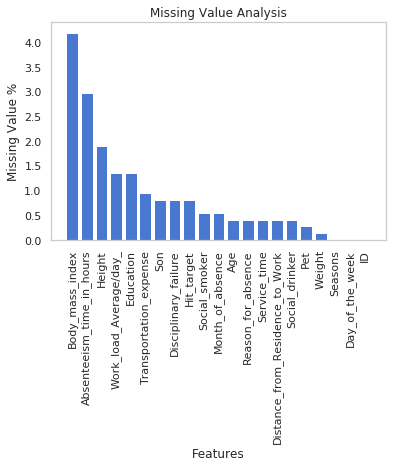

In [536]:
# calling the missing value function defined in the beginning of the code
missing_val = missing_val_percentage(df)

#Plot Missing Values
y_pos = np.arange(len(list(missing_val["Variables"])))
plt.bar(y_pos, list(missing_val["Missing_percentage"]), align='center')
plt.xticks(y_pos, list(missing_val["Variables"]), rotation='vertical')
# Set figure width to 12 and height to 9
fig_size = [8, 8]
plt.rcParams["figure.figsize"] = fig_size
plt.grid()
plt.xlabel('Features')
plt.ylabel('Missing Value %')
plt.title('Missing Value Analysis')
plt.savefig('missing_percent.pdf')
plt.show()


In [537]:
## Calling Missing values analysis function at the beginning of the code
df = Missing_Value_Analysis(df,df.columns,1)

Imputing row 1/740 with 0 missing, elapsed time: 0.131
Imputing row 101/740 with 1 missing, elapsed time: 0.133
Imputing row 201/740 with 0 missing, elapsed time: 0.134
Imputing row 301/740 with 0 missing, elapsed time: 0.135
Imputing row 401/740 with 0 missing, elapsed time: 0.136
Imputing row 501/740 with 0 missing, elapsed time: 0.136
Imputing row 601/740 with 0 missing, elapsed time: 0.137
Imputing row 701/740 with 0 missing, elapsed time: 0.137


In [538]:
# Checking for the presence of missing values
df.isnull().sum()

ID                                 0
Reason_for_absence                 0
Month_of_absence                   0
Day_of_the_week                    0
Seasons                            0
Transportation_expense             0
Distance_from_Residence_to_Work    0
Service_time                       0
Age                                0
Work_load_Average/day_             0
Hit_target                         0
Disciplinary_failure               0
Education                          0
Son                                0
Social_drinker                     0
Social_smoker                      0
Pet                                0
Weight                             0
Height                             0
Body_mass_index                    0
Absenteeism_time_in_hours          0
dtype: int64

### Distribution plot

/home/gid/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


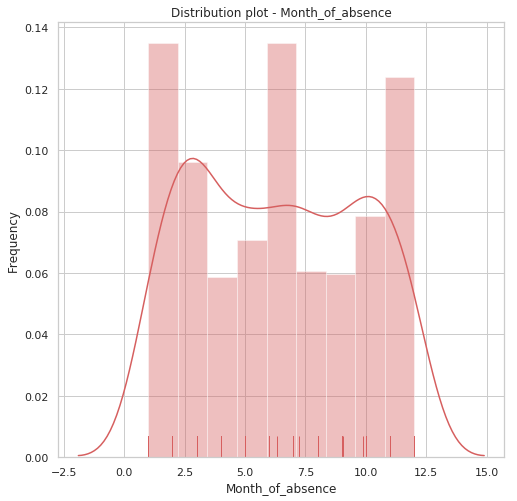

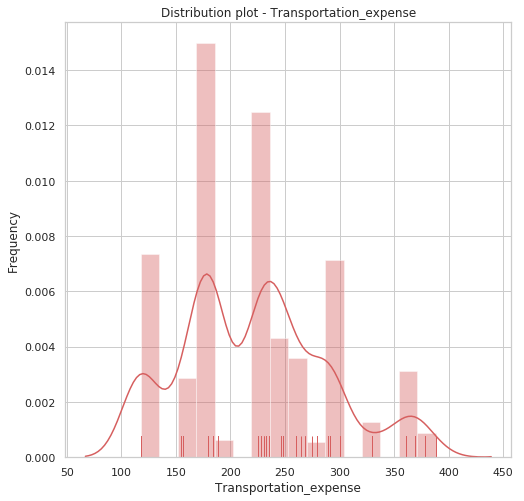

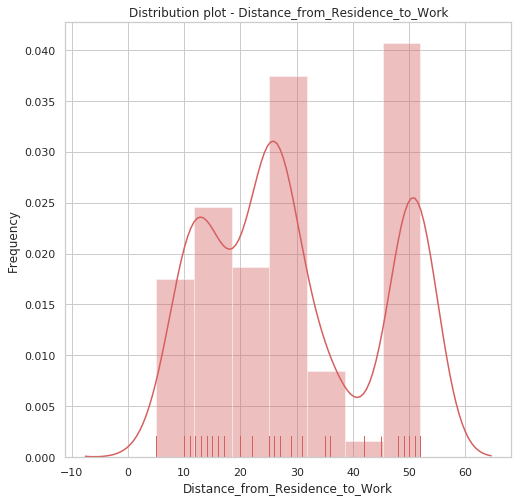

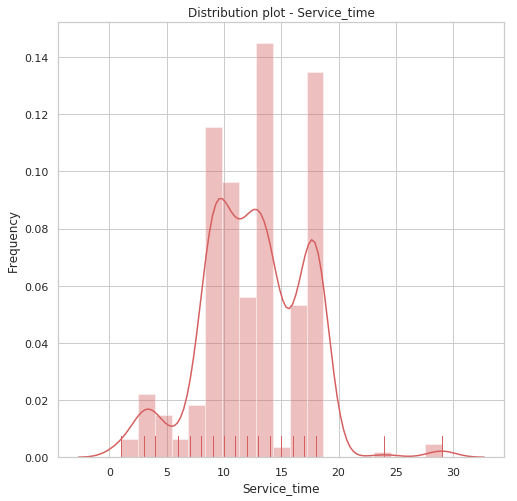

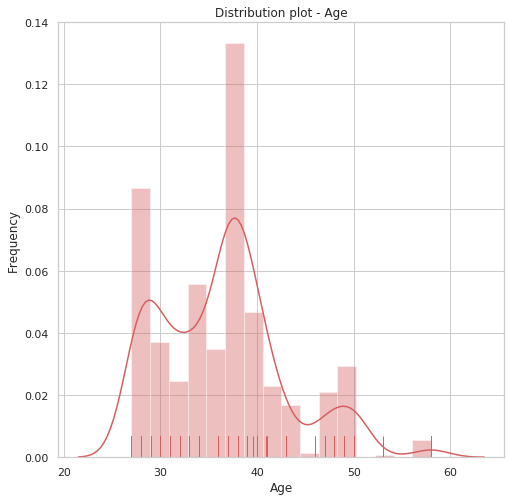

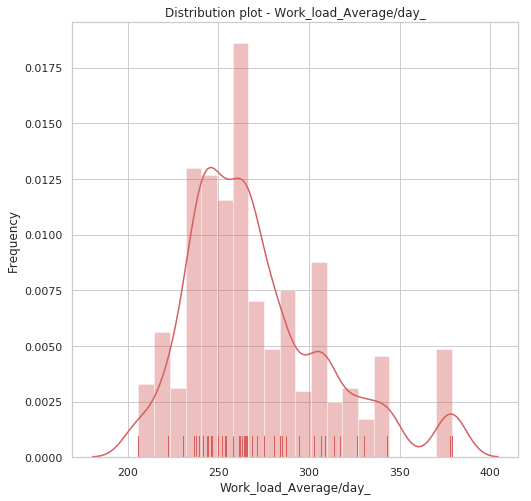

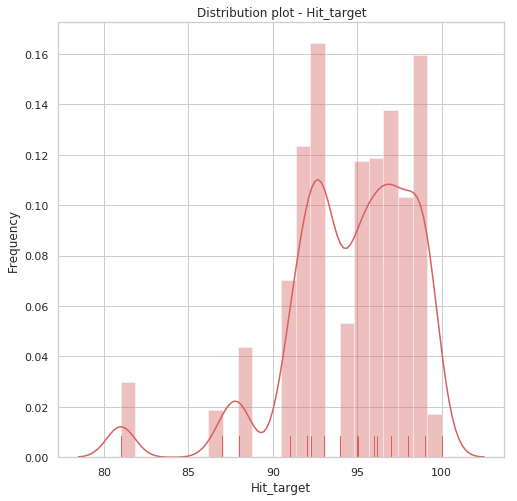

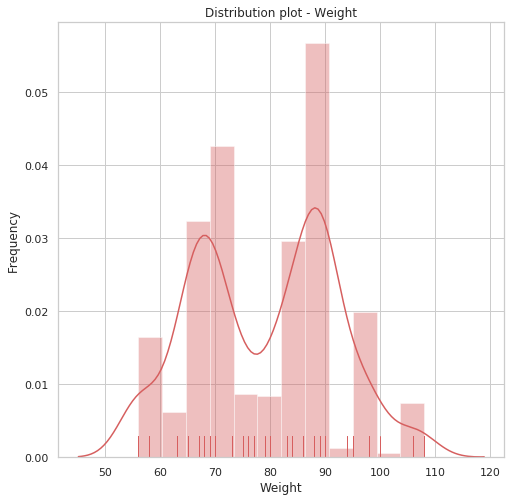

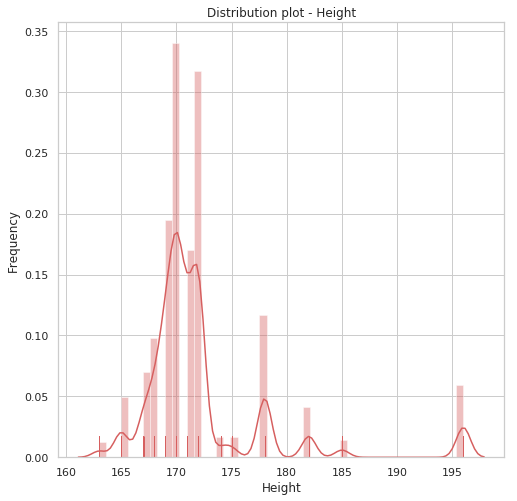

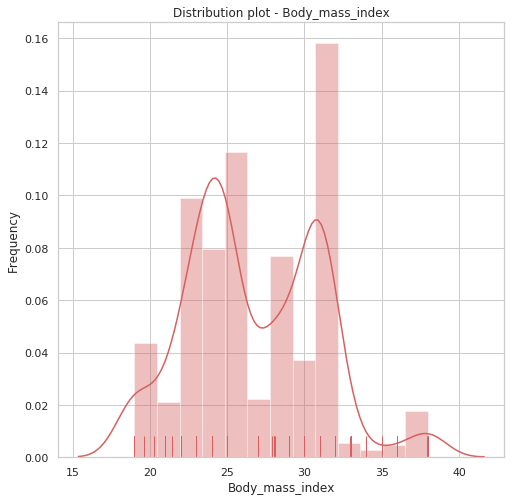

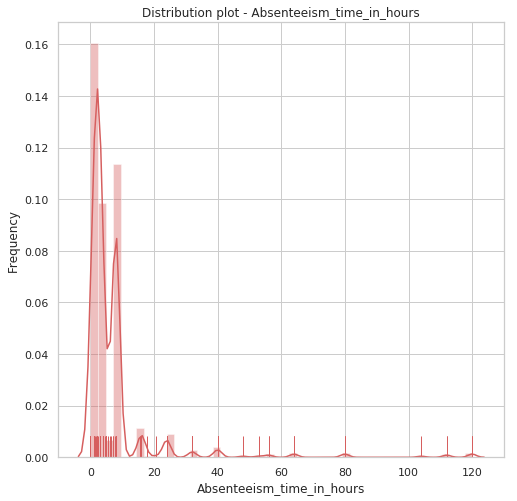

In [539]:
# Set up the figure 
sns.set(style="whitegrid", palette="muted", color_codes=True)

j = 1
# Plot Distribution plots of the numerical data
for i in num_dtype:
    ax1 = sns.distplot((df[i]), rug=True, color="r")
    ax1.set_title('Distribution plot - ' +str(i))
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(str(i))
    fname = 'dist'+str(j)+'.pdf'
    plt.savefig(fname)
    plt.show()
    j = j+1

In [540]:
# View datafram
df.head()

,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
0,10,25,7.0,1,0,289.0,36.0,13.0,33.0,239.554,...,0,0,2,1,0,1,90.0,172.0,30.0,4.0
1,35,0,7.0,1,0,118.0,13.0,18.0,50.0,239.554,...,1,0,1,1,0,0,98.0,178.0,31.0,0.0
2,2,22,7.0,2,0,179.0,51.0,18.0,38.0,239.554,...,0,0,0,1,0,0,89.0,170.0,31.0,2.0
3,6,7,7.0,3,0,279.0,5.0,14.0,39.0,239.554,...,0,0,2,1,1,0,68.0,168.0,24.0,4.0
4,10,22,7.0,3,0,289.0,36.0,13.0,33.0,239.554,...,0,0,2,1,0,1,90.0,172.0,30.0,2.0


/home/gid/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


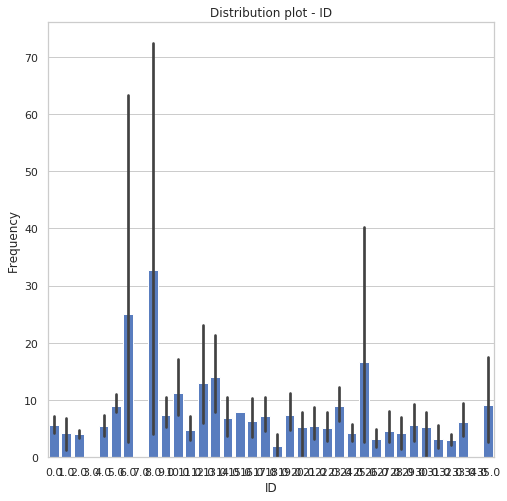

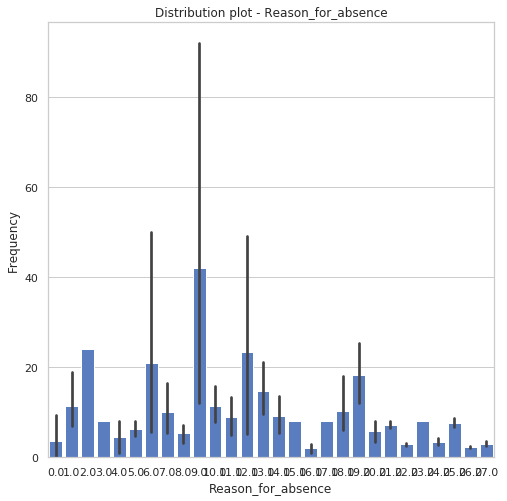

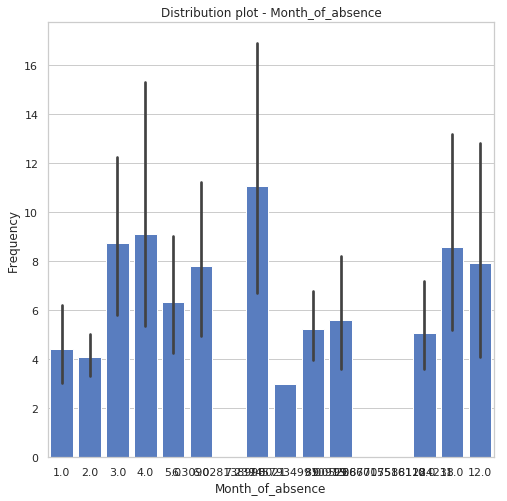

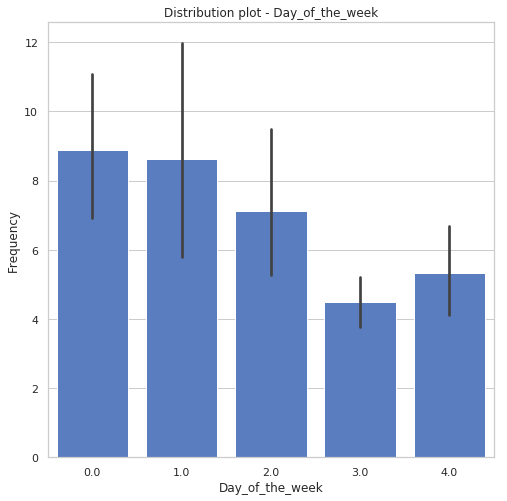

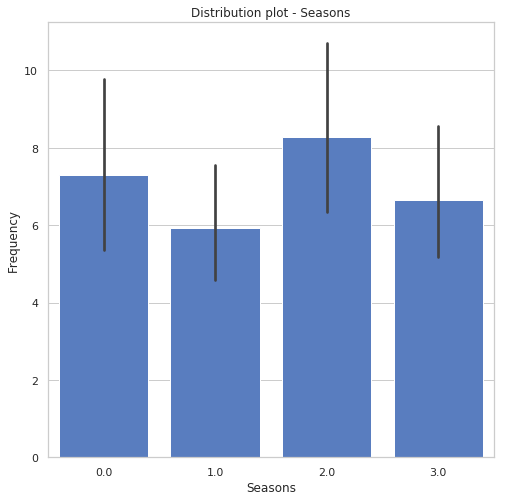

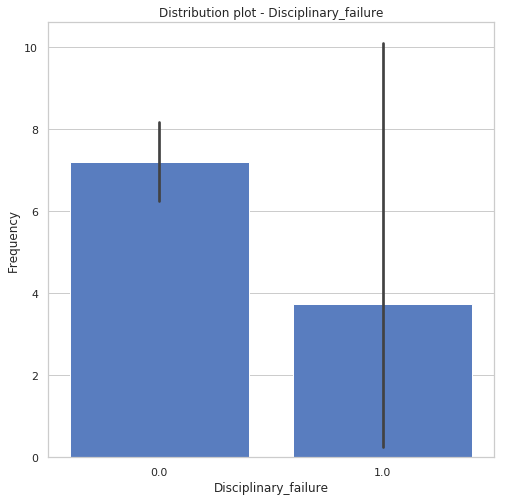

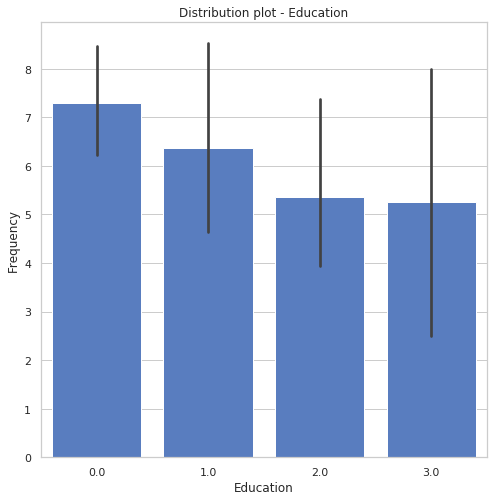

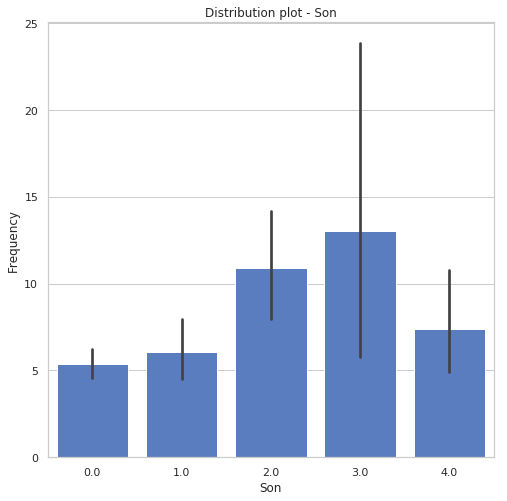

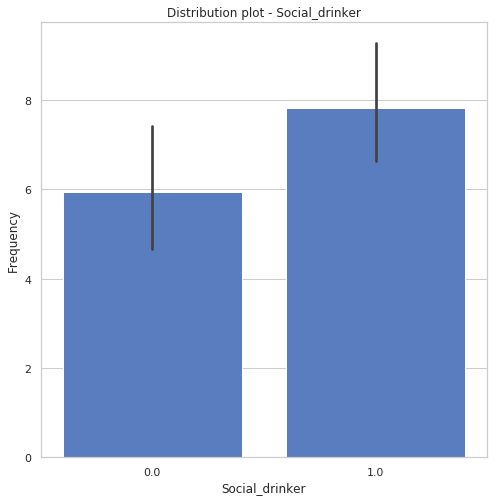

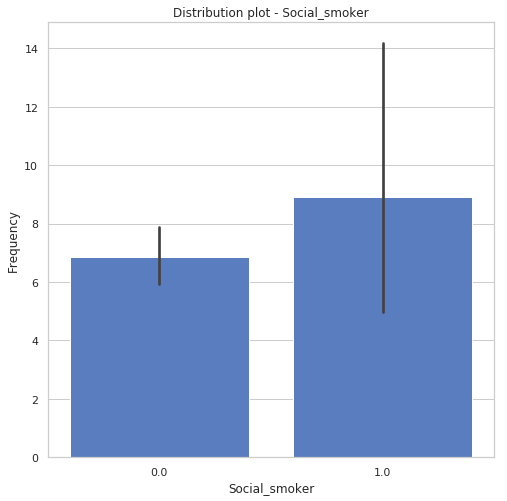

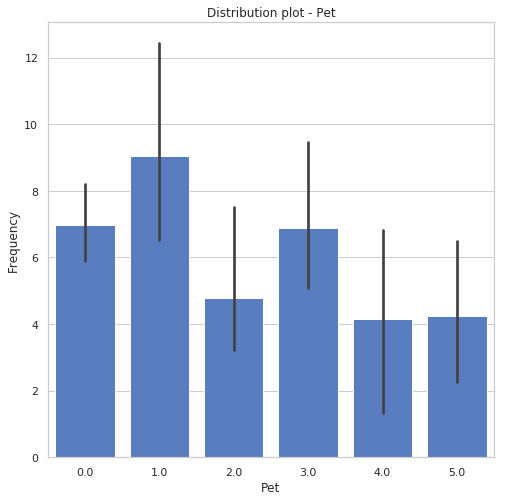

In [541]:
#Plotting the distribution of categorical variables
for i in obj_dtype:
    ax1 = sns.barplot(x=i, y="Absenteeism_time_in_hours", data=df,
                      label="Total", color="b")
    ax1.set_title('Distribution plot - ' +str(i))
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(str(i))
    plt.show()

### Skewness test

In [542]:
# Using scipy to check the skewness of the numerical variables
print("*******************************************************************")
for i in num_dtype:
    skewness = stats.describe(df.loc[:,i])
    print("statistical properities of {0:5s}:".format(i))
    print(skewness)
    print("*******************************************************************")

*******************************************************************
statistical properities of Month_of_absence:
DescribeResult(nobs=740, minmax=(1.0, 12.0), mean=6.354700578338823, variance=11.65477971915844, skewness=0.07026540073189858, kurtosis=-1.2589112442736288)
*******************************************************************
statistical properities of Transportation_expense:
DescribeResult(nobs=740, minmax=(118.0, 388.0), mean=221.31365847071507, variance=4480.378835673238, skewness=0.39566180701090514, kurtosis=-0.3221653522364045)
*******************************************************************
statistical properities of Distance_from_Residence_to_Work:
DescribeResult(nobs=740, minmax=(5.0, 52.0), mean=29.631081080006933, variance=220.1302910973327, skewness=0.3114498284184064, kurtosis=-1.2612709700406315)
*******************************************************************
statistical properities of Service_time:
DescribeResult(nobs=740, minmax=(1.0, 29.0), mean=12.554

#### We can see that the target variable has a large skew. This may be due to outliers present in the data.

# Outlier analysis

## Univariant outliers analysis

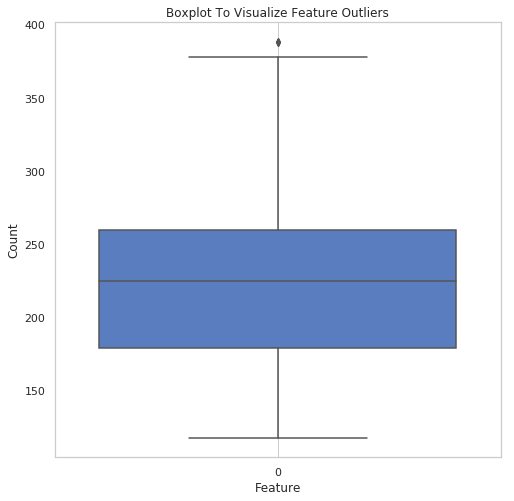

In [543]:
###############################################################################################################
## Outlier analysis
################################################################################################################

# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,5])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out1.pdf')



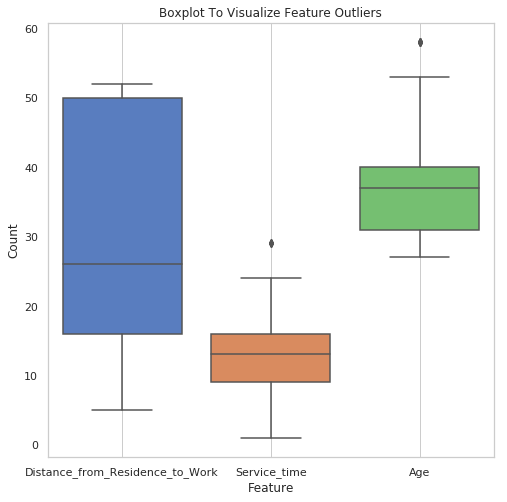

In [544]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,6:9])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out2.pdf')

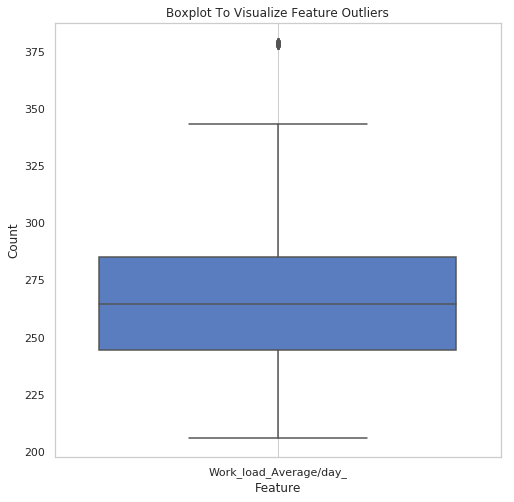

In [545]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,9:10])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out3.pdf')

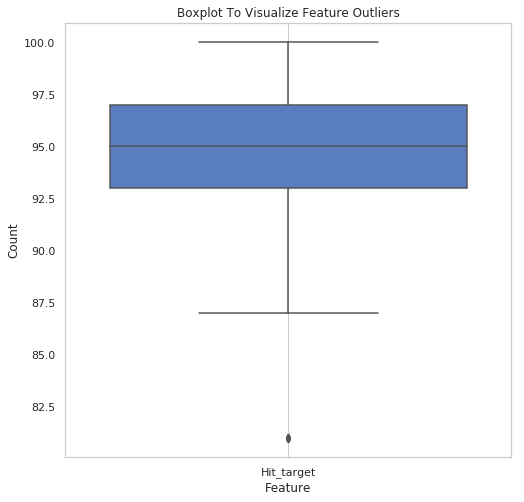

In [546]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,10:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out4.pdf')


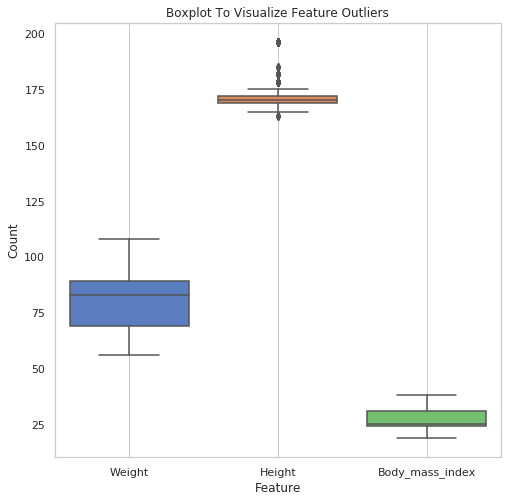

In [547]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,17:20])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out5.pdf')


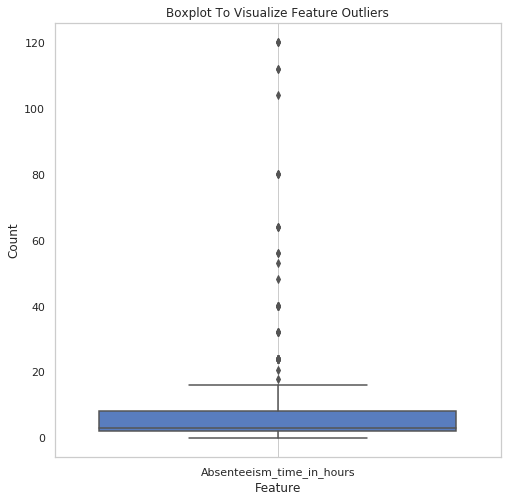

In [548]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,20:21])
ax_o1.set_title('Boxplot To Visualize Feature Outliers')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('label_out6.pdf')


## Bivariant outliers analysis

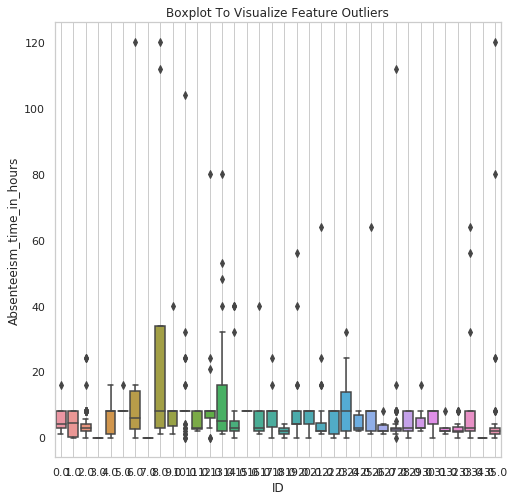

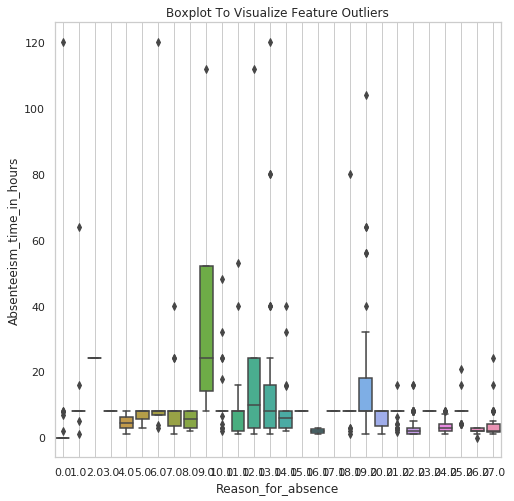

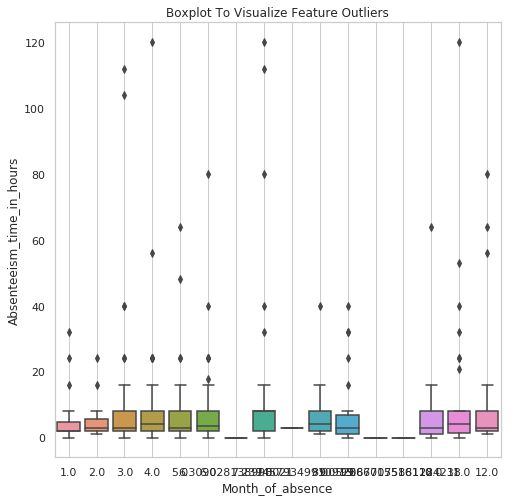

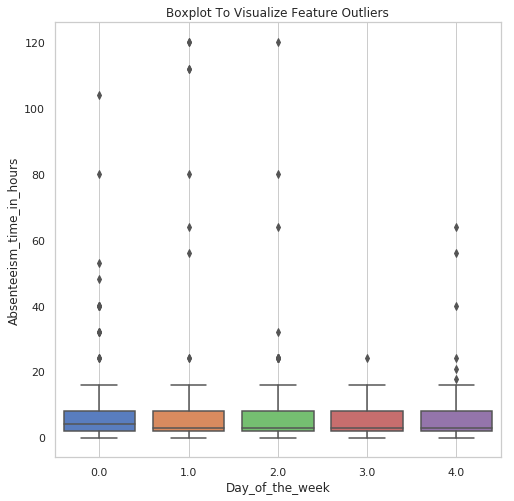

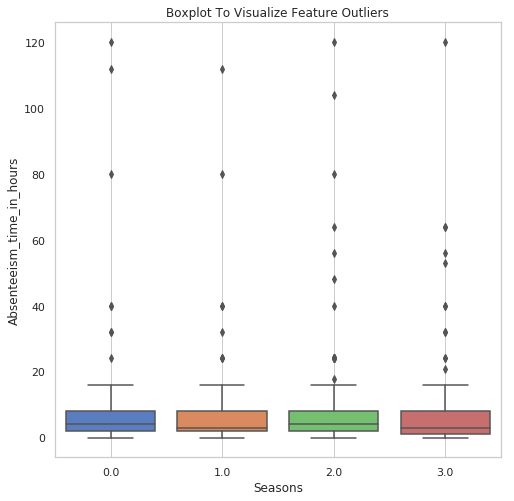

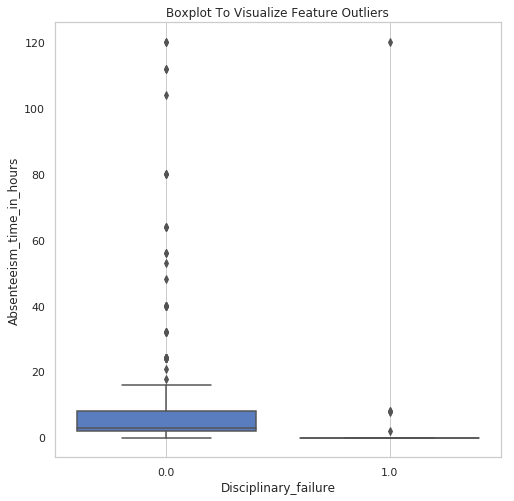

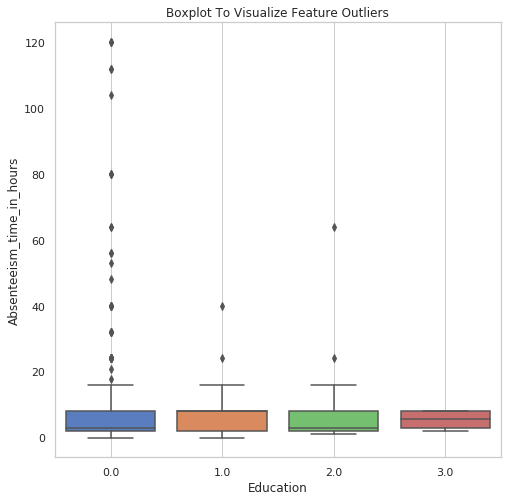

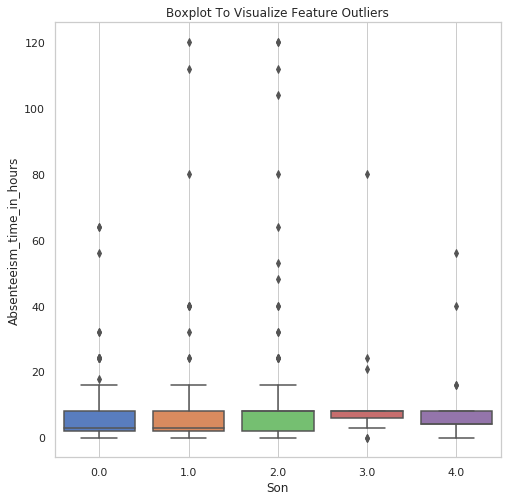

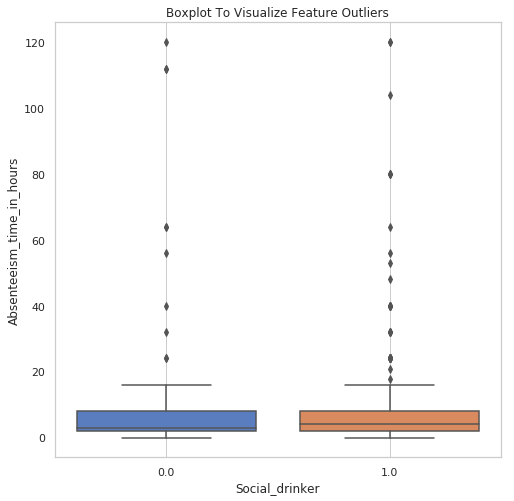

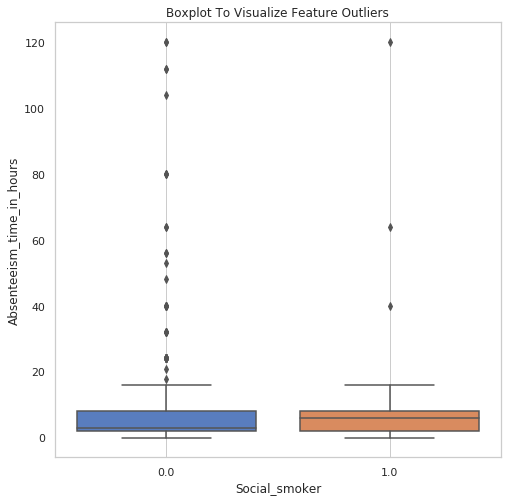

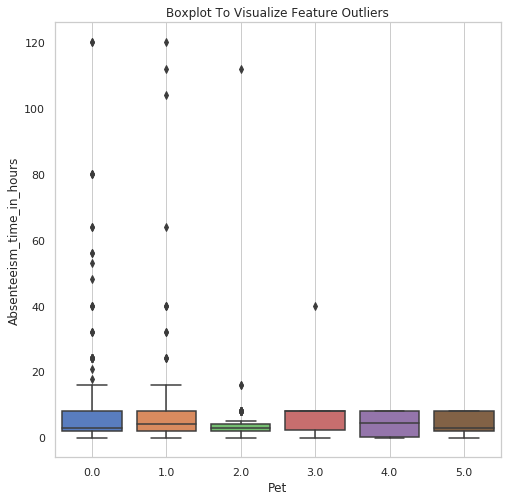

In [549]:
for i in obj_dtype:
    ax_o1 = sns.boxplot(x=i, y="Absenteeism_time_in_hours", data=df)
    ax_o1.set_title('Boxplot To Visualize Feature Outliers')
    ax_o1.set_ylabel('Absenteeism_time_in_hours')
    plt.grid()
    plt.show()

#### Calling the outlier function to compute and print outlier percent

In [550]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df,num_dtype)

Total number of outliers present = 231
Outlier percentage : 31.216


#### Calling the outlier function to perform outlier analysis. Knn imputation is performed to remove the outliers.

In [551]:
#Calling the outlier function to perform outlier analysis
method = 1
df = outlier_analysis(df, num_dtype, method)
df.describe()


Imputing row 1/740 with 0 missing, elapsed time: 0.137
Imputing row 101/740 with 1 missing, elapsed time: 0.138
Imputing row 201/740 with 0 missing, elapsed time: 0.139
Imputing row 301/740 with 0 missing, elapsed time: 0.142
Imputing row 401/740 with 0 missing, elapsed time: 0.142
Imputing row 501/740 with 0 missing, elapsed time: 0.143
Imputing row 601/740 with 0 missing, elapsed time: 0.144
Imputing row 701/740 with 0 missing, elapsed time: 0.146


,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,...,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,17.017568,18.610811,6.354054,1.914865,1.544595,220.625676,29.631081,12.445946,36.140541,266.945946,...,0.052703,0.291892,1.018919,0.567568,0.072973,0.662162,79.035135,170.206757,26.681081,4.425676
std,11.021247,8.018577,3.413980,1.421675,1.111831,66.131346,14.836788,4.169747,6.113206,32.031400,...,0.223590,0.673238,1.098489,0.495749,0.260268,1.028380,12.883211,1.923913,4.286546,3.433677
min,0.000000,0.000000,1.000000,0.000000,0.000000,118.000000,5.000000,1.000000,27.000000,206.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,165.000000,19.000000,0.000000
25%,8.000000,13.000000,3.000000,1.000000,1.000000,179.000000,16.000000,9.000000,31.000000,244.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,17.000000,22.000000,6.000000,2.000000,2.000000,225.000000,26.000000,13.000000,37.000000,264.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,27.000000,25.000000,9.000000,3.000000,3.000000,260.000000,50.000000,16.000000,40.000000,285.000000,...,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,35.000000,27.000000,12.000000,4.000000,3.000000,378.000000,52.000000,24.000000,53.000000,343.000000,...,1.000000,3.000000,4.000000,1.000000,1.000000,5.000000,108.000000,175.000000,38.000000,16.000000


#### Calling the outlier function to compute and print outlier percent

In [552]:
#Calling the outlier function to compute and print outlier percent
outlier_percent(df,num_dtype)

Total number of outliers present = 0
Outlier percentage : 0.0


## Univariant outliers analysis after outlier analysis

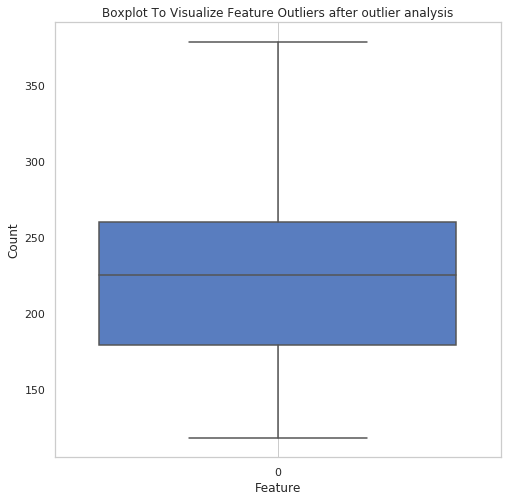

In [553]:
###############################################################################################################
## Outlier analysis
################################################################################################################

# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,5])
ax_o1.set_title('Boxplot To Visualize Feature Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a1.pdf')



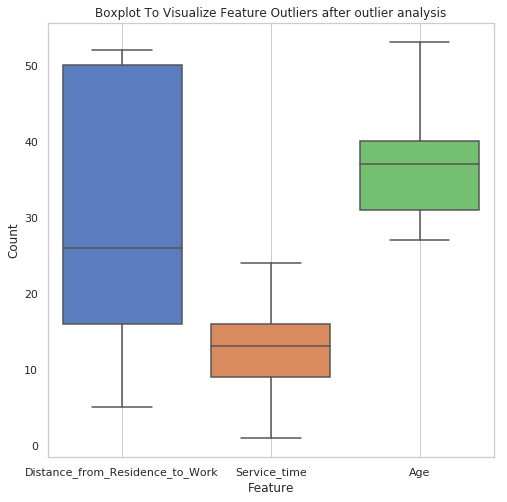

In [554]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,6:9])
ax_o1.set_title('Boxplot To Visualize Feature Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a2.pdf')

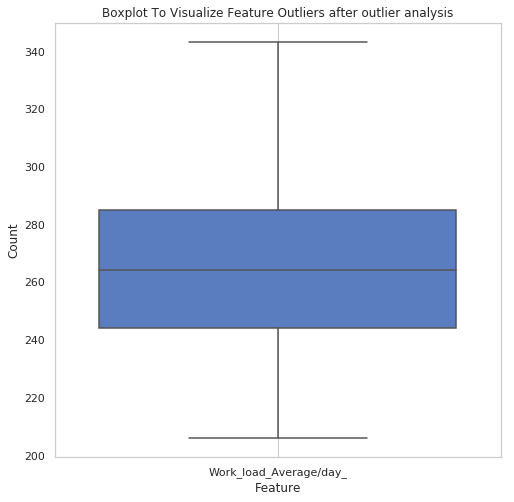

In [555]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,9:10])
ax_o1.set_title('Boxplot To Visualize Feature Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a3.pdf')

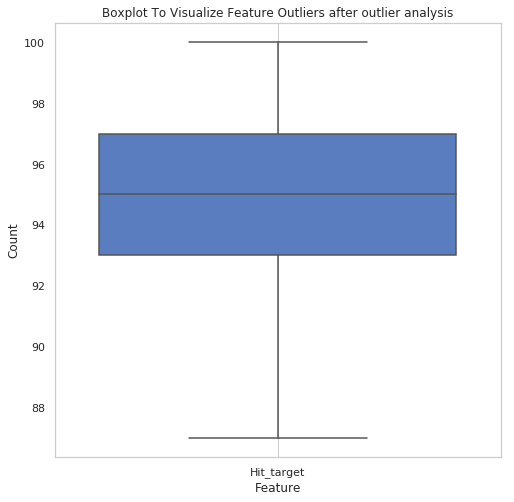

In [556]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,10:11])
ax_o1.set_title('Boxplot To Visualize Feature Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a4.pdf')


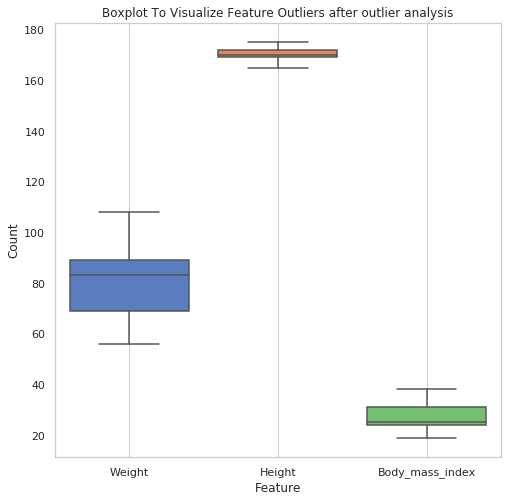

In [557]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,17:20])
ax_o1.set_title('Boxplot To Visualize Feature Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a5.pdf')

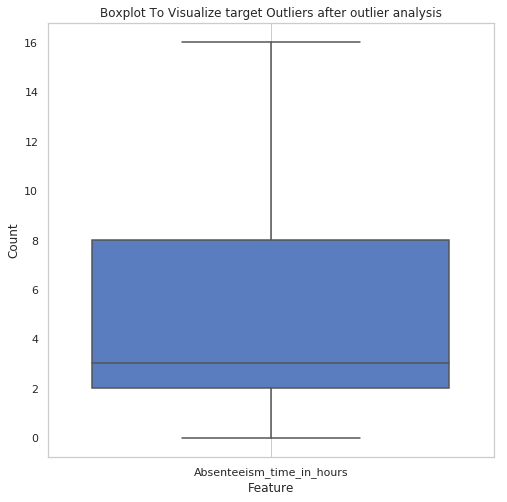

In [558]:
# #Plot boxplot to visualize Feature variable Outliers
ax_o1 = sns.boxplot(data= df.iloc[:,20:21])
ax_o1.set_title('Boxplot To Visualize target Outliers after outlier analysis')
ax_o1.set_ylabel('Count')
ax_o1.set_xlabel('Feature')
plt.grid()
plt.savefig('feat_out_a6.pdf')


## Bivariant outliers analysis after outlier analysis

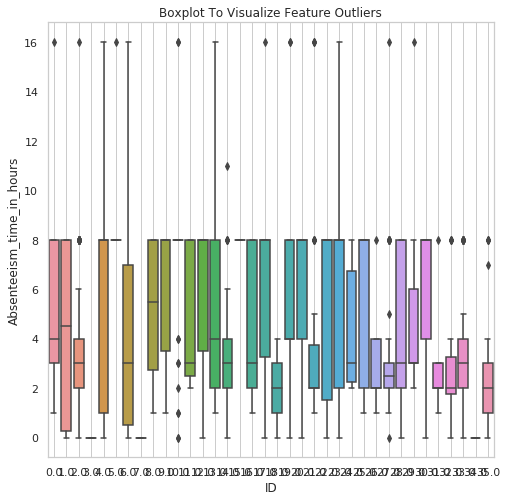

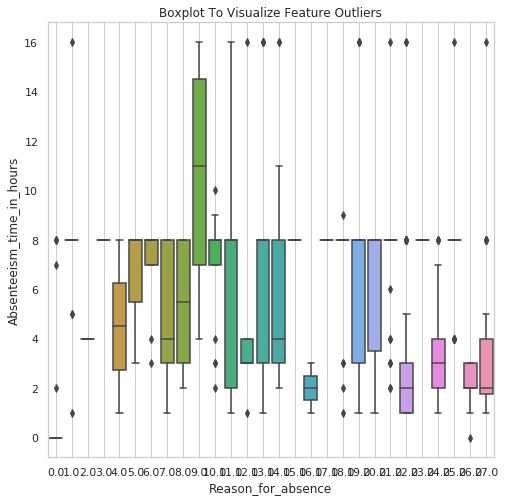

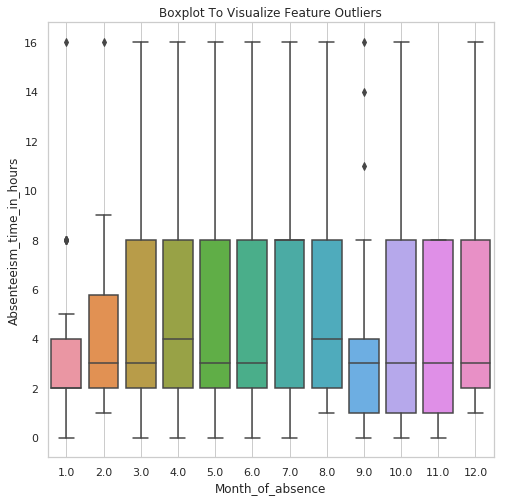

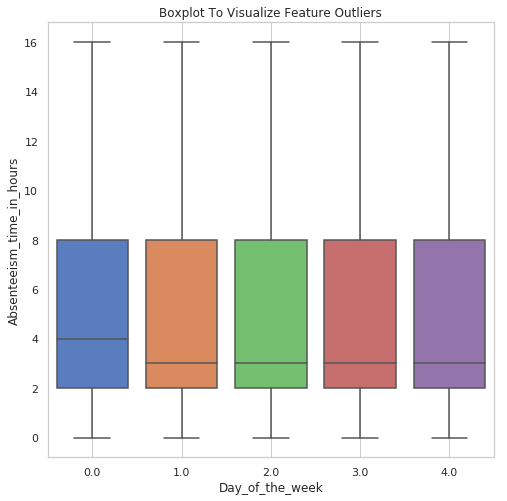

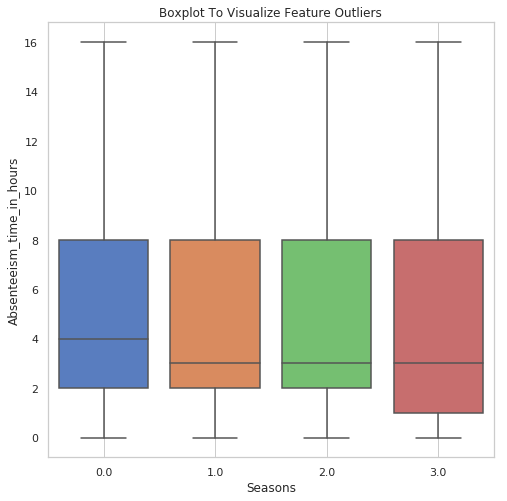

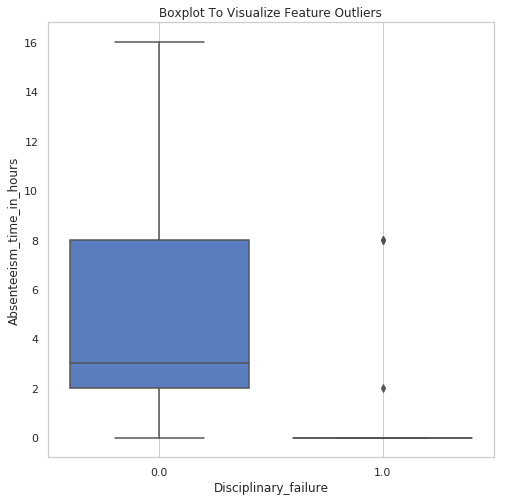

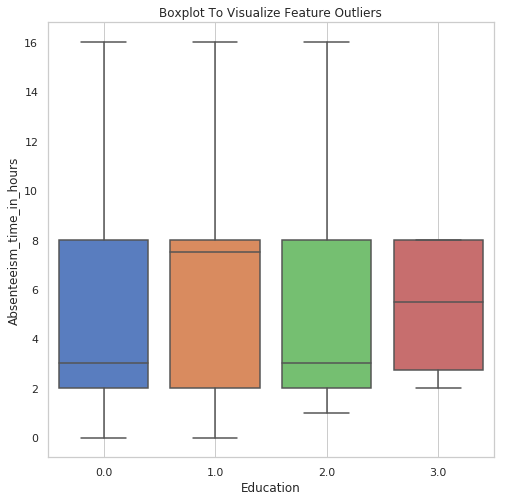

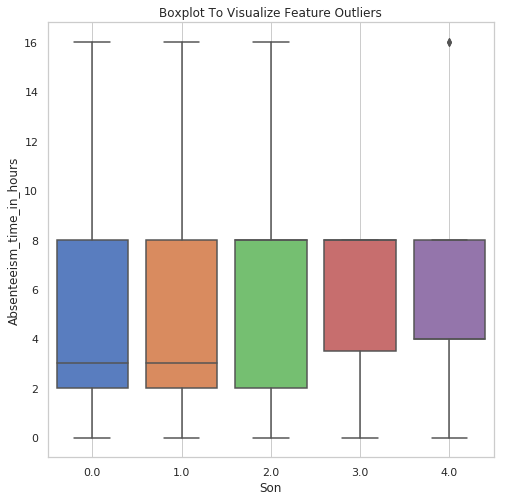

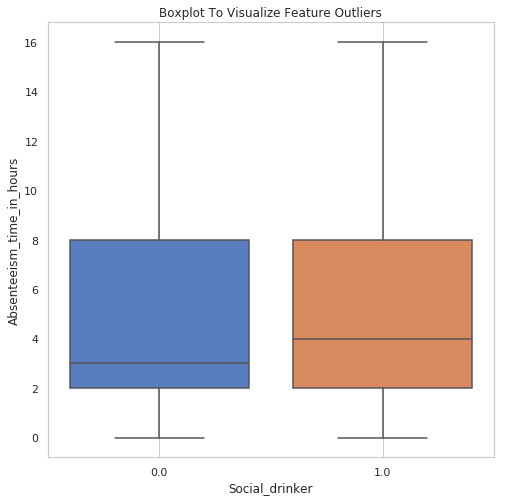

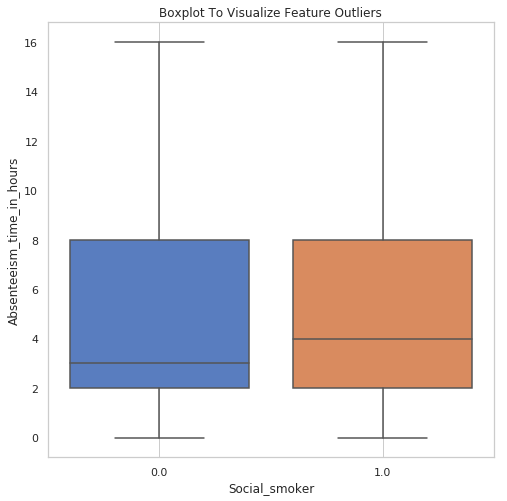

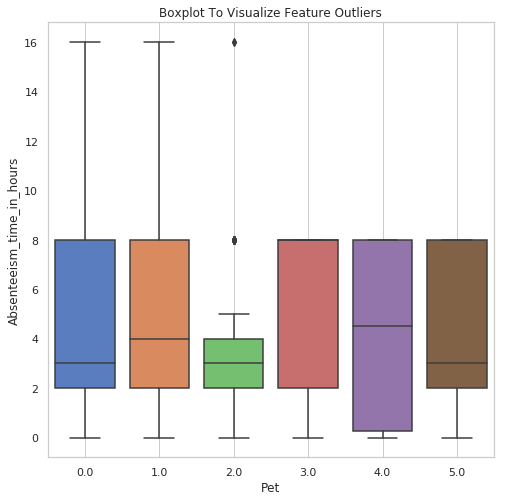

In [559]:
for i in obj_dtype:
    ax_o1 = sns.boxplot(x=i, y="Absenteeism_time_in_hours", data=df)
    ax_o1.set_title('Boxplot To Visualize Feature Outliers')
    ax_o1.set_ylabel('Absenteeism_time_in_hours')
    plt.grid()
    plt.show()

# Distribution of continous variables after outlier analysis

/home/gid/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


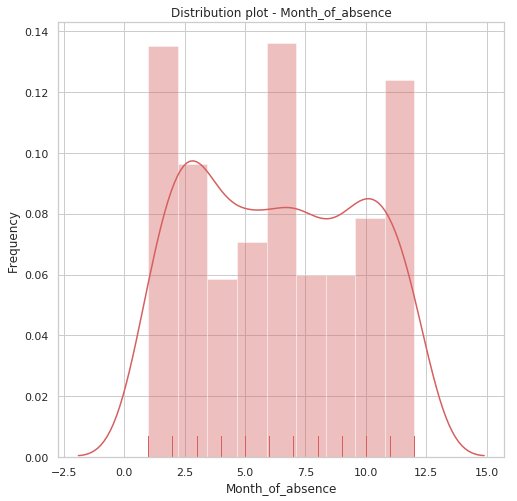

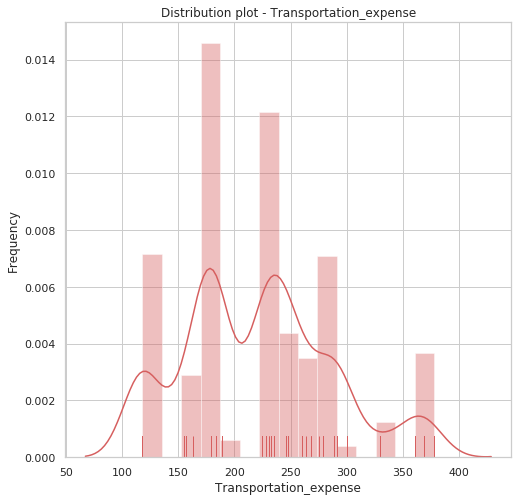

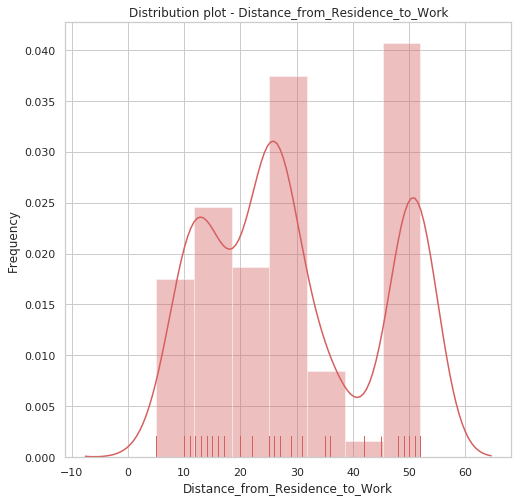

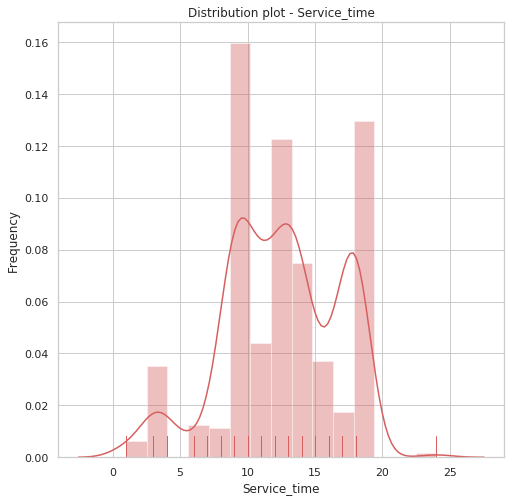

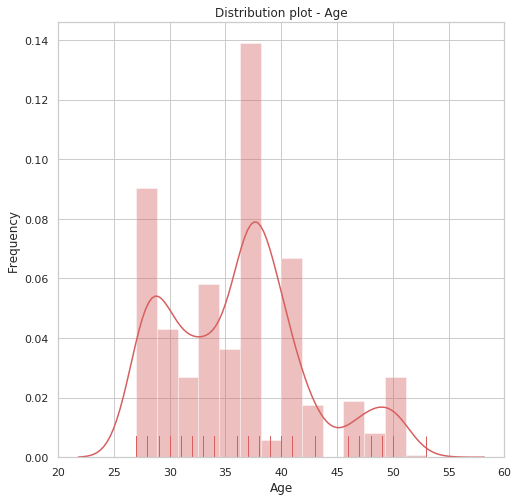

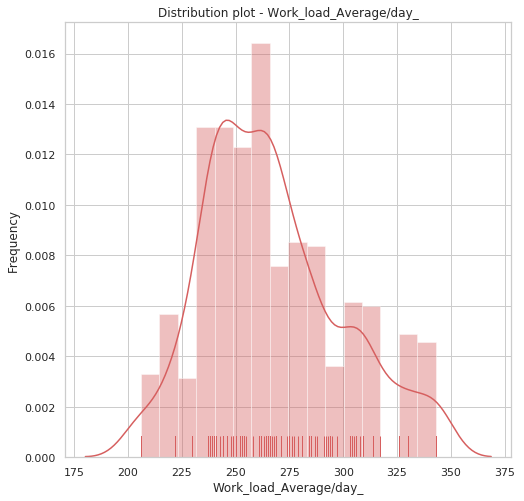

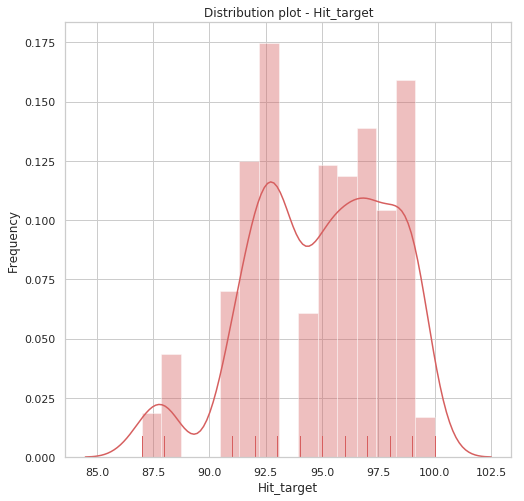

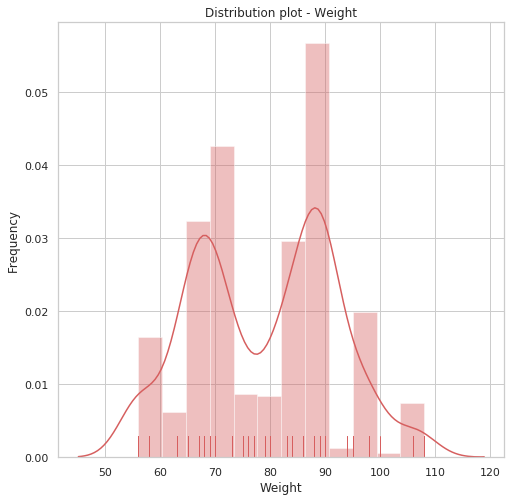

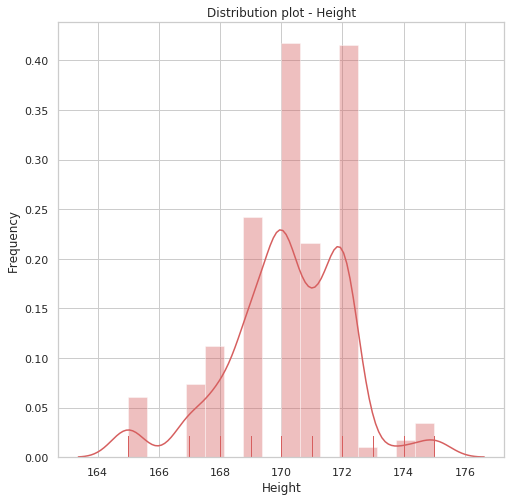

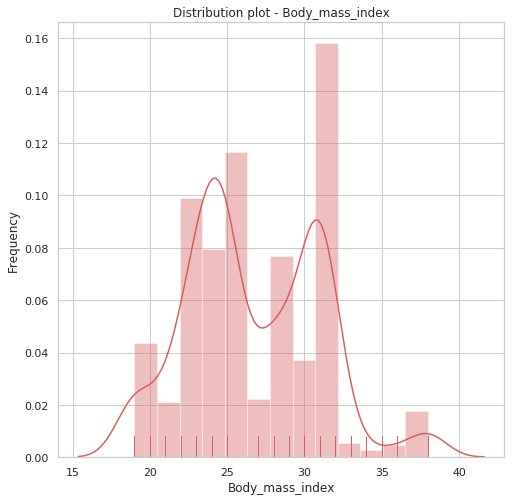

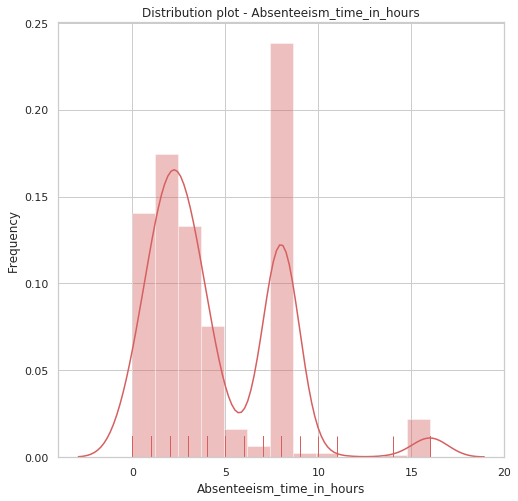

In [560]:
# Set up the figure
sns.set(style="whitegrid", palette="muted", color_codes=True)
j = 1
for i in num_dtype:
    ax1 = sns.distplot((df[i]), rug=True, color="r")
    ax1.set_title('Distribution plot - ' +str(i))
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(str(i))
    fname = 'dist'+str(j)+'_aft_out.pdf'
    plt.savefig(fname)
    plt.show()
    j = j+1

#### We can notice that there is  significient change in the distribution plots.

In [561]:
# Viewing the distribution of categorical variables
view_feature_cat(obj_dtype)

*******************************************
Feature: ID
-----------------------
2.0     113
27.0     76
33.0     55
21.0     46
19.0     42
10.0     40
14.0     37
35.0     34
23.0     30
13.0     29
9.0      24
32.0     24
0.0      23
16.0     20
4.0      19
17.0     16
12.0     15
24.0     10
8.0       8
22.0      8
5.0       8
11.0      7
26.0      7
29.0      7
6.0       6
1.0       6
25.0      5
31.0      5
28.0      5
20.0      3
18.0      3
30.0      3
7.0       2
15.0      2
3.0       1
34.0      1
Name: ID, dtype: int64
*******************************************
*******************************************
Feature: Reason_for_absence
-----------------------
22.0    149
27.0    112
26.0     69
13.0     55
0.0      43
19.0     40
21.0     37
25.0     33
24.0     31
11.0     26
10.0     25
18.0     21
14.0     20
1.0      16
7.0      15
6.0       8
12.0      8
8.0       6
20.0      6
9.0       4
23.0      3
5.0       3
16.0      3
15.0      2
4.0       2
2.0       1
17.0      1
3

In [562]:
## Note:- while seperating data types it was noticed that several of the categorical variable are stored as int.
## Hence these variables are to be converted to object data type.

## Create a list of variables which are incorrectly classified as numeric
convert_obj = ['ID',
 'Reason_for_absence',
 'Month_of_absence',
 'Day_of_the_week',
 'Seasons',
 'Disciplinary_failure',
 'Education',
 'Son',
 'Social_drinker',
 'Social_smoker',
 'Pet']
for i in convert_obj:
    df.loc[:,i] = df.loc[:,i].astype('object')

df.dtypes

ID                                  object
Reason_for_absence                  object
Month_of_absence                    object
Day_of_the_week                     object
Seasons                             object
Transportation_expense             float64
Distance_from_Residence_to_Work    float64
Service_time                       float64
Age                                float64
Work_load_Average/day_             float64
Hit_target                         float64
Disciplinary_failure                object
Education                           object
Son                                 object
Social_drinker                      object
Social_smoker                       object
Pet                                 object
Weight                             float64
Height                             float64
Body_mass_index                    float64
Absenteeism_time_in_hours          float64
dtype: object

In [563]:
df['Reason_for_absence'].value_counts()

22.0    149
27.0    112
26.0     69
13.0     55
0.0      43
19.0     40
21.0     37
25.0     33
24.0     31
11.0     26
10.0     25
18.0     21
14.0     20
1.0      16
7.0      15
6.0       8
12.0      8
8.0       6
20.0      6
9.0       4
5.0       3
23.0      3
16.0      3
4.0       2
15.0      2
3.0       1
2.0       1
17.0      1
Name: Reason_for_absence, dtype: int64

# Feature Engineering

In [564]:
# Combining similar groups in feature to simplify analysis
df['Reason_for_absence'] = df['Reason_for_absence'].replace({0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:1,
                                                             13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,21:2,22:2,23:3,
                                                             24:3,25:4,26:5,27:2})


In [565]:
# Viewing new categories in the feature
df['Reason_for_absence'].value_counts()

1    306
2    298
5     69
3     34
4     33
Name: Reason_for_absence, dtype: int64

In [566]:
df.loc[:,'Reason_for_absence'] = df.loc[:,'Reason_for_absence'].astype('object')

In [567]:
df.shape

(740, 21)

In [568]:
df1 = df.copy()

# Data Understanding

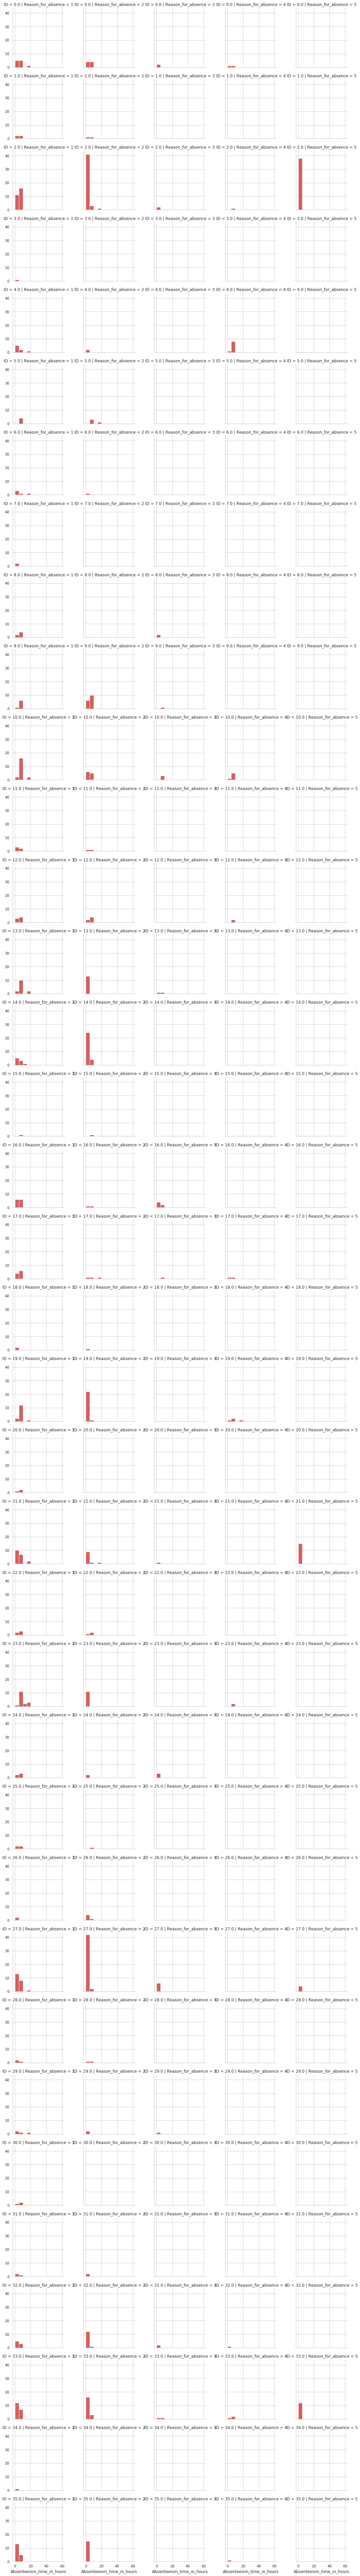

In [569]:
bins = np.arange(0, 65, 5)
g = sns.FacetGrid(df, col='Reason_for_absence',  row="ID")
g = g.map(plt.hist, "Absenteeism_time_in_hours", bins=bins, color="r")
plt.savefig('dd1.pdf')

#### The above plot shows us that the reson most often used is 1 and 2 which is desises and medical consultation 

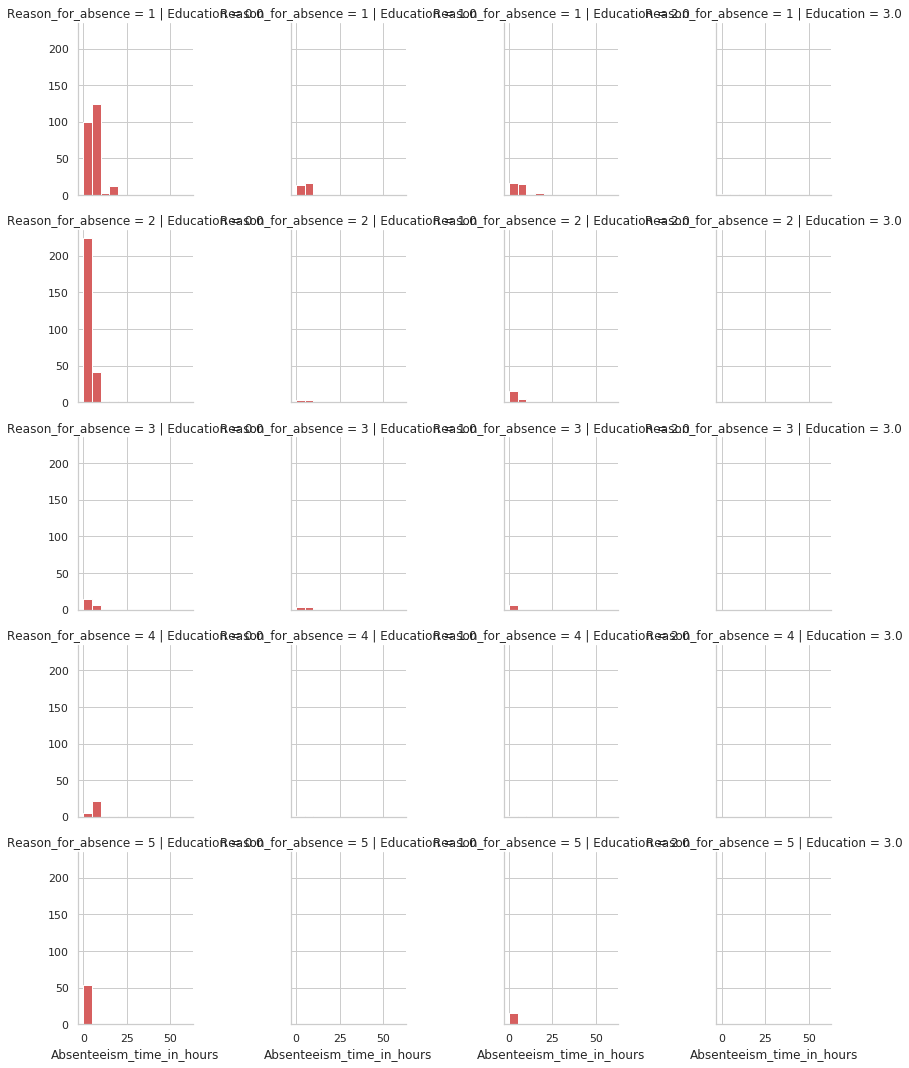

In [570]:
bins = np.arange(0, 65, 5)
g = sns.FacetGrid(df, row='Reason_for_absence',  col="Education")
g = g.map(plt.hist, "Absenteeism_time_in_hours", bins=bins, color="r")
plt.savefig('dd2.pdf')

#### According to the plot above majority of the absenteeism is by employes who only have a high school degree 

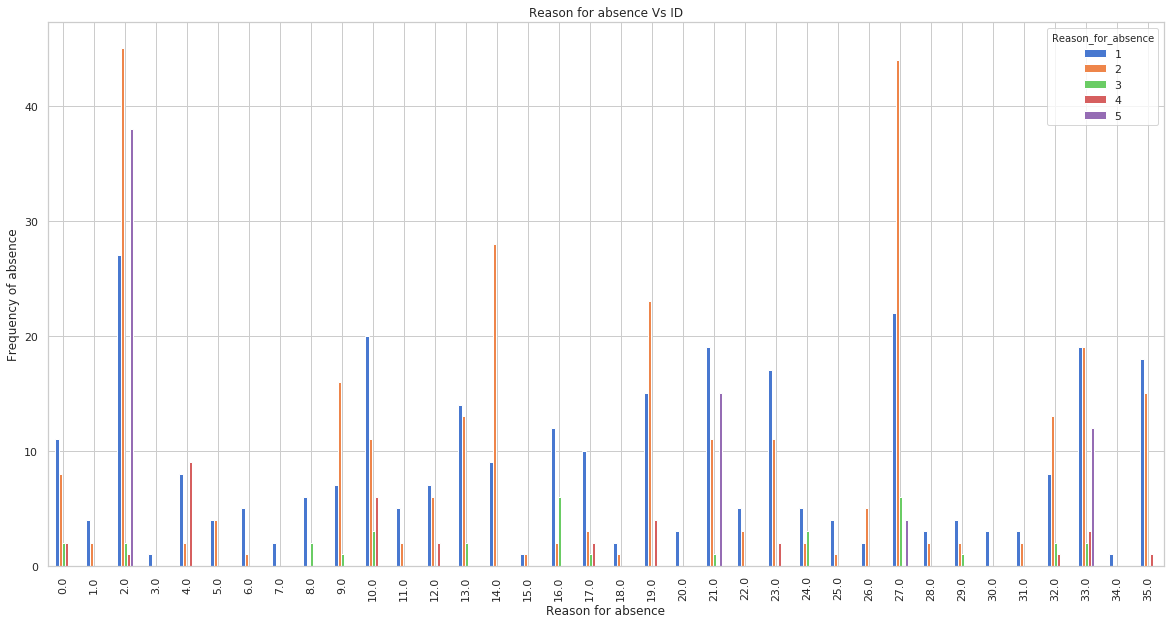

In [571]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure(figsize=(20,10))
pd.crosstab(df['ID'],df['Reason_for_absence']).plot(kind='bar',figsize=(20,10))
plt.title('Reason for absence Vs ID')
plt.xlabel('Reason for absence')
plt.ylabel('Frequency of absence')
plt.savefig('res_id.pdf')

#### From the above figure we can see that employee 2 and 27 are most frequently absent with the maine reason being medical consultation

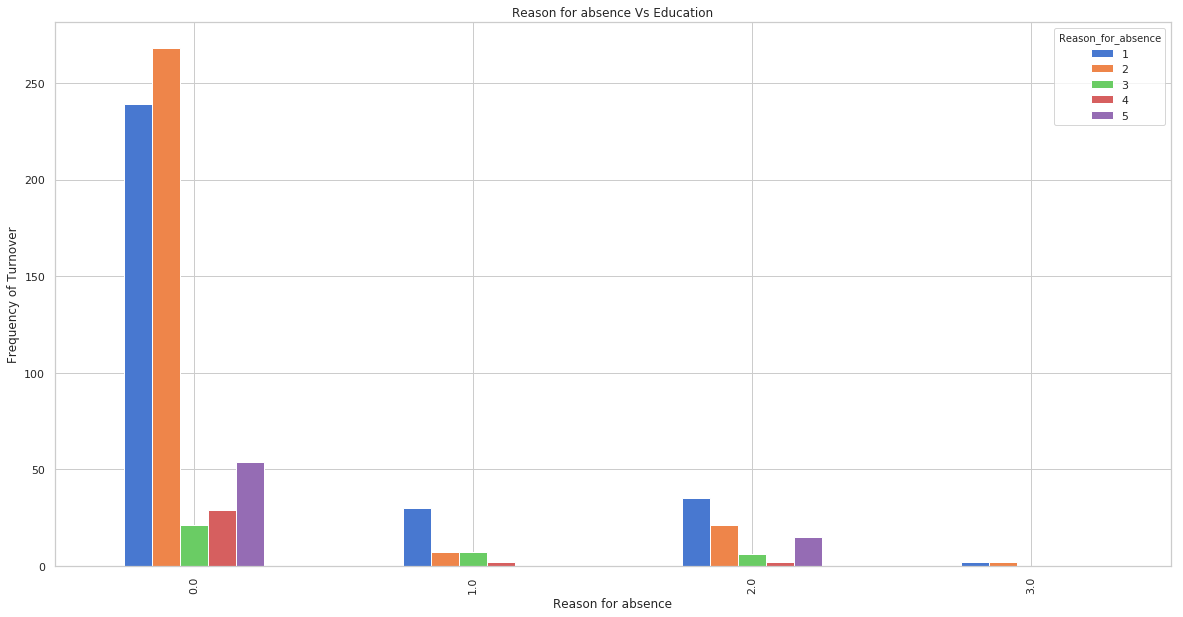

In [572]:
#plt.figure(figsize=(20,10))
pd.crosstab(df['Education'],df['Reason_for_absence']).plot(kind='bar',figsize=(20,10))
plt.title('Reason for absence Vs Education')
plt.xlabel('Reason for absence')
plt.ylabel('Frequency of Turnover')
plt.savefig('edu_res.pdf')

#### Above figure shows us that employees with ony high school degree are most frequently absent

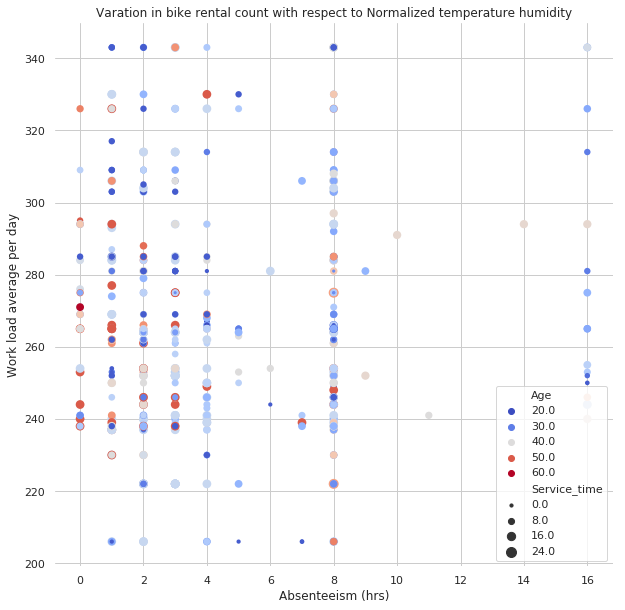

In [573]:
# variables in the dataset
f, ax = plt.subplots(figsize=(10, 10))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
ax5 = sns.scatterplot(x="Absenteeism_time_in_hours", y="Work_load_Average/day_",
                hue="Age", size="Service_time",
                palette="coolwarm",
                #hue_order=clarity_ranking,
                sizes=(10, 100), linewidth=0,
                data=df, ax=ax)
ax5.set_title("Varation in bike rental count with respect to Normalized temperature humidity")
ax5.set_ylabel("Work load average per day")
ax5.set_xlabel("Absenteeism (hrs)")
plt.savefig('work.pdf')

#### From the above figure we can see that when work load is between 240 and 300 employee age is below 30 and service time is below 8, these employees tend to be absent more frequentlly

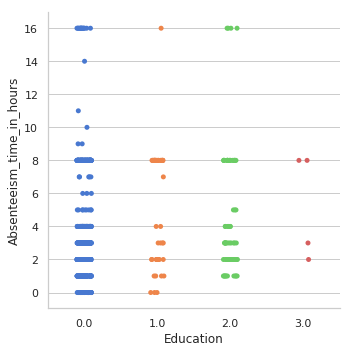

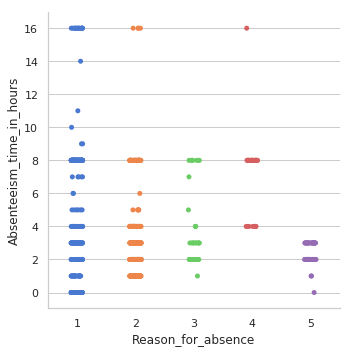

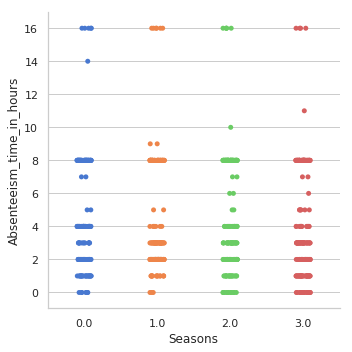

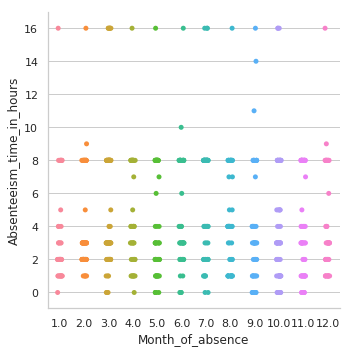

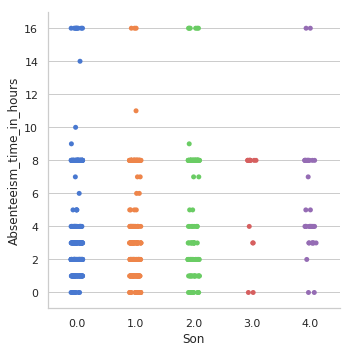

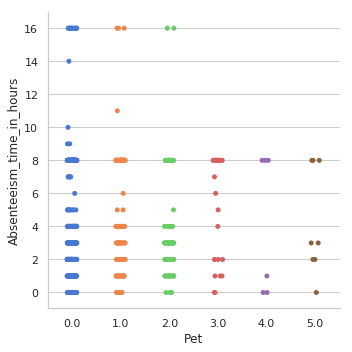

In [574]:
sns.catplot(x='Education', y="Absenteeism_time_in_hours", data=df)
plt.savefig('edu_ab.pdf')

sns.catplot(x='Reason_for_absence', y="Absenteeism_time_in_hours", data=df)
plt.savefig('reason_ab.pdf')

sns.catplot(x="Seasons", y="Absenteeism_time_in_hours", data=df)
plt.savefig('season_ab.pdf')

sns.catplot(x='Month_of_absence', y="Absenteeism_time_in_hours", data=df)
plt.savefig('month_ab.pdf')

sns.catplot(x='Son', y="Absenteeism_time_in_hours", data=df)
plt.savefig('son_ab.pdf')

sns.catplot(x='Pet', y="Absenteeism_time_in_hours", data=df)
plt.savefig('pet_ab.pdf')

#### From the above plots we can say that peoply with only a high school degree are absent more often. The reson frequently used is 1 which is code of Diseases. Absenteeism through months and days of week and seasons are almost constant or same. But we can see that people with no children or no pets tend to be absent more ofte than people who have children or pets.

# Feature Selection

## Correlation plot

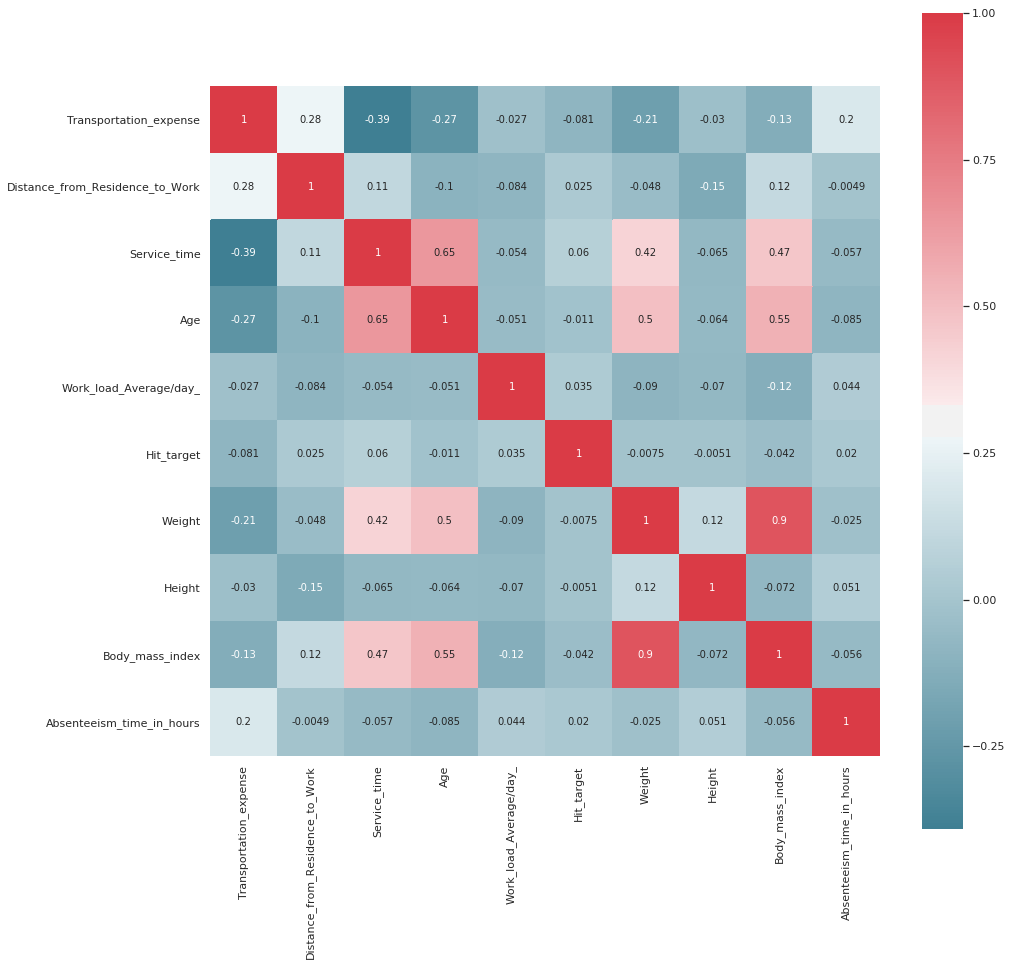

In [575]:
####################################################################################
## Correlation plot
#Correlation plot
df_corr = df.loc[:,num_dtype]
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(15, 15))
#Generate correlation matrix
corr = df_corr.corr()
#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True,ax=ax)
plt.savefig('corr_plot.pdf')

In [576]:
treshold = 0.7
corr_col = corr.columns
corr_row = corr.index
drop_feat = drop_list(corr_col, corr_row, treshold)

repeat


In [577]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, boo, un = dtype_separator(df, df.columns)
num_dtype

['Transportation_expense',
 'Distance_from_Residence_to_Work',
 'Service_time',
 'Age',
 'Work_load_Average/day_',
 'Hit_target',
 'Weight',
 'Height',
 'Body_mass_index',
 'Absenteeism_time_in_hours']

In [578]:
#Saving a copy of the dataframe
df_class = df

## ANOVA

In [579]:
label = 'Absenteeism_time_in_hours'
## ANOVA TEST FOR P VALUES
import statsmodels.api as sm
from statsmodels.formula.api import ols
anova_p = []
for  i in obj_dtype:
    buf = label + ' ~ ' + i
    mod = ols(buf,data=df).fit()
    anova_op = sm.stats.anova_lm(mod, typ=2)
    print(anova_op)
    anova_p.append(anova_op.iloc[0:1,3:4])
    p = anova_op.loc[i,'PR(>F)']
    if p >= 0.05:
        drop_feat.append(i)

               sum_sq     df         F        PR(>F)
ID        1489.036365   35.0  4.146099  1.148030e-13
Residual  7223.875798  704.0       NaN           NaN
                         sum_sq     df          F        PR(>F)
Reason_for_absence  1397.477786    4.0  35.102023  7.515585e-27
Residual            7315.434376  735.0        NaN           NaN
                       sum_sq     df         F   PR(>F)
Month_of_absence   282.115342   11.0  2.214608  0.01228
Residual          8430.796821  728.0       NaN      NaN
                      sum_sq     df         F    PR(>F)
Day_of_the_week    67.201829    4.0  1.428262  0.222809
Residual         8645.710333  735.0       NaN       NaN
               sum_sq     df         F    PR(>F)
Seasons     69.029361    3.0  1.959213  0.118713
Residual  8643.882801  736.0       NaN       NaN
                           sum_sq     df          F        PR(>F)
Disciplinary_failure   581.734796    1.0  52.799276  9.418497e-13
Residual              8131.177366 

## Skewness test

In [580]:

print("*******************************************************************")
for i in num_dtype:
    skewness = stats.describe(df.loc[:,i])
    print("statistical properities of {0:5s}:".format(i))
    print(skewness)
    print("*******************************************************************")

*******************************************************************
statistical properities of Transportation_expense:
DescribeResult(nobs=740, minmax=(118.0, 378.0), mean=220.62567567567567, variance=4373.354955564495, skewness=0.3756674357536574, kurtosis=-0.33770597431634375)
*******************************************************************
statistical properities of Distance_from_Residence_to_Work:
DescribeResult(nobs=740, minmax=(5.0, 52.0), mean=29.63108108108108, variance=220.13029111655638, skewness=0.3114498278842765, kurtosis=-1.261270969913851)
*******************************************************************
statistical properities of Service_time:
DescribeResult(nobs=740, minmax=(1.0, 24.0), mean=12.445945945945946, variance=17.386790037669606, skewness=-0.34301872345212286, kurtosis=-0.19060374758858512)
*******************************************************************
statistical properities of Age  :
DescribeResult(nobs=740, minmax=(27.0, 53.0), mean=36.1405405405

##### It is noticed that the skewness of the target is still high. Hence we use a transform in the next step.

### Log transform of target 

In [581]:
df['Absenteeism_time_in_hours'] = np.log1p(df['Absenteeism_time_in_hours'])

In [582]:
print("*******************************************************************")
for i in num_dtype:
    skewness = stats.describe(df.loc[:,i])
    print("statistical properities of {0:5s}:".format(i))
    print(skewness)
    print("*******************************************************************")

*******************************************************************
statistical properities of Transportation_expense:
DescribeResult(nobs=740, minmax=(118.0, 378.0), mean=220.62567567567567, variance=4373.354955564495, skewness=0.3756674357536574, kurtosis=-0.33770597431634375)
*******************************************************************
statistical properities of Distance_from_Residence_to_Work:
DescribeResult(nobs=740, minmax=(5.0, 52.0), mean=29.63108108108108, variance=220.13029111655638, skewness=0.3114498278842765, kurtosis=-1.261270969913851)
*******************************************************************
statistical properities of Service_time:
DescribeResult(nobs=740, minmax=(1.0, 24.0), mean=12.445945945945946, variance=17.386790037669606, skewness=-0.34301872345212286, kurtosis=-0.19060374758858512)
*******************************************************************
statistical properities of Age  :
DescribeResult(nobs=740, minmax=(27.0, 53.0), mean=36.1405405405

In [583]:
drop_feat

['Body_mass_index', 'Day_of_the_week', 'Seasons', 'Education', 'Social_smoker']

In [584]:
## The less signifient features are removed
df = df.drop(drop_feat,axis = 1)

In [585]:
# Calling function drop_features to remove the dropped features names from the list of categorical and numeric feature names.
obj_dtype, num_dtype = drop_features(drop_feat, obj_dtype, num_dtype)

In [586]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)


In [587]:
obj_dtype

['ID',
 'Reason_for_absence',
 'Month_of_absence',
 'Disciplinary_failure',
 'Son',
 'Social_drinker',
 'Pet']

In [588]:
num_dtype.remove('Absenteeism_time_in_hours')

# Feature Scaling

In [589]:
#Function to perform scaling analysis
#Standardizing the features except the target variable
scaling_fun(df,num_dtype,1)

Transportation_expense
Distance_from_Residence_to_Work
Service_time
Age
Work_load_Average/day_
Hit_target
Weight
Height


,ID,Reason_for_absence,Month_of_absence,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Son,Social_drinker,Pet,Weight,Height,Absenteeism_time_in_hours
0,10,4,7,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,1,0.851097,0.932081,1.609438
1,35,1,7,-1.551846,-1.120935,1.331988,2.267134,-0.841235,0.674640,1,1,1,0,1.472060,0.932081,0.000000
2,2,2,7,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,0.773477,-0.107467,1.098612
3,6,1,7,0.882703,-1.660136,0.372697,0.467751,-0.841235,0.674640,0,2,1,0,-0.856552,-1.147015,1.609438
4,10,2,7,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,1,0.851097,0.932081,1.098612
5,2,2,7,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,0.773477,-0.107467,1.098612
6,9,2,7,2.122659,1.507666,-2.265352,-1.331632,-0.841235,0.674640,0,1,1,3,0.074893,0.932081,2.197225
7,19,2,7,0.595396,1.372866,-0.346771,-0.022990,-0.841235,0.674640,0,4,1,0,-1.089413,-1.147015,1.609438
8,13,1,7,-0.992354,-1.188335,0.372697,-0.350150,-0.841235,0.674640,0,2,1,0,1.239199,-0.107467,1.386294
9,0,2,7,0.217360,-1.255735,0.372697,0.140591,-0.841235,0.674640,0,1,0,1,0.695856,0.932081,2.197225


In [590]:
copy_dat = df.copy()

# Creating dummy variables

In [591]:
## Creating dummy variables for multivarient linear regression 
X_l = pd.get_dummies(df, columns = obj_dtype, drop_first = True) 
X_l["b0"]=1

In [592]:
X_l.shape

(740, 71)

In [593]:
# Rearranging the variables so they are in order
col_name = X_l.columns.tolist()
col_name = col_name[70:71] + col_name[0:8]+ col_name[10:70]+ col_name[8:9]
X_l = X_l.loc[:, col_name]

# MODEL DEVLOPMENT

In [594]:
np.random.seed(0)
# Train the model using the training sets
model = sm.OLS(X_l.iloc[:,69], X_l.iloc[:,0:69]).fit()

In [595]:
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:54   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.8373      0.438      4.190      0.000       0.976       2.698
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0417      0.277     -0.151      0.880      -0.586       0.503
Service_time                        0.4672      0.660      0.707      0.480      -0.830       1.764
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5357      0.608      0.881      0.379      -0.659       1.730
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.9895      1.738     -0.569      0.569      -4.402       2.423
ID_3.0                             -1.6732      0.543     -3.081      0.002      -2.740      -0.607
ID_4.0                              0.2849      0.279      1.019      0.308      -0.264       0.834
ID_5.0                              0.7139      0.447      1.599      0.110      -0.163       1.591
ID_6.0                              0.1190      0.794      0.150      0.881      -1.441       1.679
ID_7.0                             -1.8937      0.958     -1.976      0.049      -3.776      -0.012
ID_8.0                             -1.5467      1.192     -1.298      0.195      -3.886       0.793
ID_9.0                             -0.1852      0.346     -0.534      0.593      -0.865       0.495
ID_10.0                            -1.3993      1.614     -0.867      0.386      -4.568       1.770
ID_11.0                             1.3775      0.664      2.074      0.038       0.073       2.682
ID_12.0                            -0.2646      0.575     -0.460      0.646      -1.394       0.864
ID_13.0                            -1.7860      1.765     -1.012      0.312      -5.252       1.680
ID_14.0                             0.9571      1.267      0.755      0.450      -1.530       3.444
ID_15.0                             0.0360      0.511      0.071      0.944      -0.966       1.039
ID_16.0                             0.2447      0.250      0.978      0.329      -0.247       0.736
ID_17.0                            -0.8684      0.806     -1.077      0.282      -2.451       0.714
ID_18.0                            -0.5018      0.888     -0.565      0.572      -2.245       1.241
ID_19.0                             0.4028      0.139      2.903      0.004       0.130       0.675
ID_20.

## Feature elemination

### Backward elemination

In [596]:
x_bwe = X_l.drop("ID_33.0", axis = 1)

In [597]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,68], x_bwe.iloc[:,0:68]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:55   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.8337      0.762      2.406      0.016       0.337       3.330
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0404      0.287     -0.141      0.888      -0.603       0.523
Service_time                        0.4679      0.611      0.766      0.444      -0.731       1.667
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5353      0.628      0.852      0.394      -0.698       1.768
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.9901      1.719     -0.576      0.565      -4.365       2.384
ID_3.0                             -1.6722      0.528     -3.169      0.002      -2.708      -0.636
ID_4.0                              0.2854      0.325      0.879      0.379      -0.352       0.923
ID_5.0                              0.7141      0.445      1.606      0.109      -0.159       1.587
ID_6.0                              0.1203      0.850      0.142      0.887      -1.548       1.788
ID_7.0                             -1.8949      0.937     -2.022      0.044      -3.735      -0.055
ID_8.0                             -1.5471      1.177     -1.315      0.189      -3.858       0.764
ID_9.0                             -0.1860      0.312     -0.596      0.552      -0.799       0.427
ID_10.0                            -1.4020      1.535     -0.913      0.361      -4.417       1.613
ID_11.0                             1.3764      0.728      1.891      0.059      -0.053       2.806
ID_12.0                            -0.2632      0.737     -0.357      0.721      -1.711       1.185
ID_13.0                            -1.7844      1.799     -0.992      0.322      -5.317       1.748
ID_14.0                             0.9533      1.445      0.660      0.510      -1.883       3.790
ID_15.0                             0.0349      0.585      0.060      0.952      -1.113       1.183
ID_16.0                             0.2456      0.234      1.050      0.294      -0.214       0.705
ID_17.0                            -0.8618      1.498     -0.575      0.565      -3.802       2.079
ID_18.0                            -0.5022      0.859     -0.585      0.559      -2.188       1.184
ID_19.0                             0.4027      0.135      2.976      0.003       0.137       0.668
ID_20.

In [598]:
x1 = x_bwe

In [599]:
x_bwe = x_bwe.drop("ID_20.0", axis = 1)

In [600]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,67], x_bwe.iloc[:,0:67]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:55   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7350      2.426      0.715      0.475      -3.028       6.498
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0714      0.508     -0.141      0.888      -1.070       0.927
Service_time                        0.3595      2.267      0.159      0.874      -4.092       4.811
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5160      0.799      0.646      0.518      -1.052       2.084
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.7727      4.485     -0.172      0.863      -9.578       8.032
ID_3.0                             -1.5763      1.772     -0.890      0.374      -5.055       1.903
ID_4.0                              0.3179      0.857      0.371      0.711      -1.365       2.001
ID_5.0                              0.6888      0.694      0.992      0.321      -0.674       2.052
ID_6.0                              0.0055      1.805      0.003      0.998      -3.538       3.549
ID_7.0                             -1.9206      1.057     -1.818      0.070      -3.995       0.154
ID_8.0                             -1.6083      1.500     -1.072      0.284      -4.553       1.336
ID_9.0                             -0.3124      2.294     -0.136      0.892      -4.817       4.192
ID_10.0                            -1.5433      2.947     -0.524      0.601      -7.330       4.244
ID_11.0                             1.1926      3.708      0.322      0.748      -6.089       8.474
ID_12.0                            -0.2823      0.439     -0.643      0.520      -1.144       0.579
ID_13.0                            -1.8441      1.994     -0.925      0.355      -5.760       2.071
ID_14.0                             0.8354      3.033      0.275      0.783      -5.120       6.790
ID_15.0                             0.2117      2.875      0.074      0.941      -5.434       5.857
ID_16.0                             0.3223      1.442      0.223      0.823      -2.510       3.154
ID_17.0                            -1.0039      1.496     -0.671      0.502      -3.941       1.934
ID_18.0                            -0.4788      1.163     -0.412      0.681      -2.763       1.805
ID_19.0                             0.4014      0.128      3.128      0.002       0.149       0.653
ID_21.

In [601]:
x1 = x_bwe

In [602]:
x_bwe = x_bwe.drop("ID_6.0", axis = 1)

In [603]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,66], x_bwe.iloc[:,0:66]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:55   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7343      2.229      0.778      0.437      -2.642       6.111
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0726      0.160     -0.454      0.650      -0.386       0.241
Service_time                        0.3602      2.504      0.144      0.886      -4.557       5.277
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5146      0.461      1.115      0.265      -0.391       1.421
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.7716      4.131     -0.187      0.852      -8.882       7.339
ID_3.0                             -1.5775      2.149     -0.734      0.463      -5.796       2.641
ID_4.0                              0.3174      1.018      0.312      0.755      -1.682       2.317
ID_5.0                              0.6868      0.674      1.019      0.309      -0.637       2.011
ID_7.0                             -1.9202      1.082     -1.775      0.076      -4.045       0.204
ID_8.0                             -1.6105      1.462     -1.102      0.271      -4.481       1.260
ID_9.0                             -0.3116      2.524     -0.123      0.902      -5.268       4.645
ID_10.0                            -1.5418      3.262     -0.473      0.637      -7.946       4.862
ID_11.0                             1.1931      3.869      0.308      0.758      -6.403       8.789
ID_12.0                            -0.2835      0.801     -0.354      0.724      -1.856       1.289
ID_13.0                            -1.8462      2.056     -0.898      0.370      -5.883       2.191
ID_14.0                             0.8344      2.718      0.307      0.759      -4.503       6.172
ID_15.0                             0.2059      4.688      0.044      0.965      -8.998       9.410
ID_16.0                             0.3182      2.674      0.119      0.905      -4.932       5.568
ID_17.0                            -1.0022      1.893     -0.530      0.597      -4.718       2.714
ID_18.0                            -0.4793      1.318     -0.364      0.716      -3.066       2.108
ID_19.0                             0.4012      0.138      2.914      0.004       0.131       0.672
ID_21.0                             0.0524      0.342      0.153      0.878      -0.620       0.725
ID_22.

In [604]:
x1 = x_bwe

In [605]:
x_bwe = x_bwe.drop("Pet_3.0", axis = 1)

In [606]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,65], x_bwe.iloc[:,0:65]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:55   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7350      2.305      0.753      0.452      -2.790       6.261
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0719      0.216     -0.332      0.740      -0.496       0.353
Service_time                        0.3600      2.487      0.145      0.885      -4.524       5.244
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5150      0.469      1.099      0.272      -0.405       1.435
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.7728      4.255     -0.182      0.856      -9.126       7.581
ID_3.0                             -1.5774      2.134     -0.739      0.460      -5.768       2.613
ID_4.0                              0.3160      1.176      0.269      0.788      -1.993       2.625
ID_5.0                              0.6866      0.675      1.017      0.310      -0.639       2.012
ID_7.0                             -1.9211      1.019     -1.884      0.060      -3.923       0.080
ID_8.0                             -1.6104      1.467     -1.098      0.273      -4.490       1.269
ID_9.0                             -0.3059      3.172     -0.096      0.923      -6.533       5.922
ID_10.0                            -1.5430      3.127     -0.493      0.622      -7.683       4.597
ID_11.0                             1.1919      3.746      0.318      0.750      -6.164       8.548
ID_12.0                            -0.2831      0.770     -0.368      0.713      -1.795       1.229
ID_13.0                            -1.8474      2.028     -0.911      0.363      -5.830       2.135
ID_14.0                             0.8344      2.719      0.307      0.759      -4.505       6.173
ID_15.0                             0.2056      4.720      0.044      0.965      -9.061       9.473
ID_16.0                             0.3171      2.794      0.114      0.910      -5.168       5.803
ID_17.0                            -1.0028      1.830     -0.548      0.584      -4.595       2.590
ID_18.0                            -0.4800      1.376     -0.349      0.727      -3.182       2.222
ID_19.0                             0.4009      0.167      2.398      0.017       0.073       0.729
ID_21.0                             0.0525      0.343      0.153      0.878      -0.621       0.726
ID_22.

In [607]:
x1 = x_bwe

In [608]:
x_bwe = x_bwe.drop("ID_28.0", axis = 1)

In [609]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,64], x_bwe.iloc[:,0:64]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:56   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7346      2.284      0.760      0.448      -2.749       6.219
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0721      0.211     -0.342      0.733      -0.487       0.342
Service_time                        0.3599      2.484      0.145      0.885      -4.516       5.236
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5151      0.467      1.103      0.270      -0.401       1.432
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.7724      4.238     -0.182      0.855      -9.093       7.548
ID_3.0                             -1.5778      2.152     -0.733      0.464      -5.803       2.648
ID_4.0                              0.3154      1.207      0.261      0.794      -2.055       2.686
ID_5.0                              0.6821      0.610      1.119      0.264      -0.515       1.879
ID_7.0                             -1.9260      0.764     -2.520      0.012      -3.427      -0.425
ID_8.0                             -1.6096      1.519     -1.060      0.290      -4.591       1.372
ID_9.0                             -0.3060      3.167     -0.097      0.923      -6.524       5.912
ID_10.0                            -1.5424      3.174     -0.486      0.627      -7.774       4.689
ID_11.0                             1.1921      3.755      0.317      0.751      -6.180       8.565
ID_12.0                            -0.2832      0.772     -0.367      0.714      -1.799       1.233
ID_13.0                            -1.8474      2.026     -0.912      0.362      -5.826       2.131
ID_14.0                             0.8344      2.720      0.307      0.759      -4.506       6.175
ID_15.0                             0.2059      4.703      0.044      0.965      -9.029       9.441
ID_16.0                             0.3179      2.754      0.115      0.908      -5.090       5.726
ID_17.0                            -1.0028      1.828     -0.549      0.584      -4.592       2.587
ID_18.0                            -0.4795      1.365     -0.351      0.725      -3.159       2.200
ID_19.0                             0.4011      0.156      2.566      0.011       0.094       0.708
ID_21.0                             0.0529      0.357      0.148      0.882      -0.647       0.753
ID_22.

In [610]:
x1 = x_bwe

In [611]:
x_bwe = x_bwe.drop("Pet_1.0", axis = 1)

In [612]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,63], x_bwe.iloc[:,0:63]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:56   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7423      2.798      0.623      0.534      -3.752       7.237
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0759      0.139     -0.547      0.585      -0.348       0.197
Service_time                        0.3716      3.268      0.114      0.910      -6.045       6.788
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.4963      1.135      0.437      0.662      -1.733       2.726
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.7889      5.330     -0.148      0.882     -11.254       9.676
ID_3.0                             -1.5600      1.006     -1.551      0.121      -3.535       0.415
ID_4.0                              0.3811      3.302      0.115      0.908      -6.103       6.865
ID_5.0                              0.6681      1.431      0.467      0.641      -2.141       3.477
ID_7.0                             -1.9093      1.464     -1.304      0.193      -4.784       0.965
ID_8.0                             -1.6516      3.109     -0.531      0.595      -7.756       4.453
ID_9.0                             -0.2421      7.422     -0.033      0.974     -14.814      14.330
ID_10.0                            -1.5473      2.907     -0.532      0.595      -7.256       4.161
ID_11.0                             1.2090      4.896      0.247      0.805      -8.403      10.821
ID_12.0                            -0.3013      1.964     -0.153      0.878      -4.157       3.554
ID_13.0                            -1.8062      3.302     -0.547      0.585      -8.289       4.677
ID_14.0                             0.8098      1.237      0.655      0.513      -1.618       3.238
ID_15.0                             0.1907      5.723      0.033      0.973     -11.045      11.427
ID_16.0                             0.3199      2.618      0.122      0.903      -4.821       5.460
ID_17.0                            -0.9831      3.074     -0.320      0.749      -7.019       5.053
ID_18.0                            -0.5146      3.656     -0.141      0.888      -7.694       6.665
ID_19.0                             0.3849      1.192      0.323      0.747      -1.956       2.726
ID_21.0                             0.0203      2.247      0.009      0.993      -4.392       4.433
ID_22.

In [613]:
x1 = x_bwe

In [614]:
x_bwe = x_bwe.drop("ID_21.0", axis = 1)

In [615]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,62], x_bwe.iloc[:,0:62]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.488
Method:                        Least Squares   F-statistic:                     13.36
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.40e-78
Time:                               20:45:56   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1047.
Df Residuals:                            682   BIC:                             1314.
Df Model:                                 57                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7718      0.716      2.474      0.014       0.366       3.178
Transportation_expense              0.0814      0.430      0.189      0.850      -0.764       0.927
Distance_from_Residence_to_Work    -0.0543      2.456     -0.022      0.982      -4.876       4.768
Service_time                        0.3739      3.017      0.124      0.901      -5.551       6.298
Age                                -0.9778      1.108     -0.882      0.378      -3.154       1.198
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.4974      1.250      0.398      0.691      -1.956       2.951
Height                              0.1264      0.114      1.106      0.269      -0.098       0.351
ID_2.0                             -0.8436      1.320     -0.639      0.523      -3.435       1.748
ID_3.0                             -1.5435      2.761     -0.559      0.576      -6.965       3.878
ID_4.0                              0.3768      3.779      0.100      0.921      -7.043       7.796
ID_5.0                              0.6413      1.605      0.400      0.690      -2.509       3.792
ID_7.0                             -1.9384      4.502     -0.431      0.667     -10.778       6.901
ID_8.0                             -1.6753      1.307     -1.282      0.200      -4.241       0.891
ID_9.0                             -0.2852     12.089     -0.024      0.981     -24.021      23.451
ID_10.0                            -1.5937      7.526     -0.212      0.832     -16.371      13.183
ID_11.0                             1.1810      7.947      0.149      0.882     -14.422      16.784
ID_12.0                            -0.3015      1.944     -0.155      0.877      -4.119       3.516
ID_13.0                            -1.8187      4.416     -0.412      0.681     -10.490       6.853
ID_14.0                             0.7929      2.940      0.270      0.787      -4.980       6.565
ID_15.0                             0.1701      3.513      0.048      0.961      -6.728       7.068
ID_16.0                             0.2842      1.462      0.194      0.846      -2.587       3.155
ID_17.0                            -0.9886      3.649     -0.271      0.787      -8.152       6.175
ID_18.0                            -0.5625      1.755     -0.321      0.749      -4.008       2.883
ID_19.0                             0.3613      1.462      0.247      0.805      -2.509       3.231
ID_22.0                             0.2832      8.956      0.032      0.975     -17.302      17.869
ID_23.

In [616]:
x1 = x_bwe

In [617]:
x_bwe = x_bwe.drop("ID_26.0", axis = 1)

In [618]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,61], x_bwe.iloc[:,0:61]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.489
Method:                        Least Squares   F-statistic:                     13.62
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.45e-78
Time:                               20:45:57   Log-Likelihood:                -465.60
No. Observations:                        740   AIC:                             1045.
Df Residuals:                            683   BIC:                             1308.
Df Model:                                 56                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7752      0.559      3.173      0.002       0.677       2.874
Transportation_expense              0.0785      0.201      0.391      0.696      -0.315       0.472
Distance_from_Residence_to_Work    -0.0358      0.371     -0.097      0.923      -0.764       0.692
Service_time                        0.3513      0.605      0.581      0.562      -0.837       1.539
Age                                -0.9749      1.041     -0.936      0.349      -3.019       1.069
Work_load_Average/day_             -0.0114      0.023     -0.503      0.615      -0.056       0.033
Hit_target                         -0.0019      0.026     -0.074      0.941      -0.053       0.049
Weight                              0.5066      0.327      1.547      0.122      -0.136       1.149
Height                              0.1265      0.113      1.116      0.265      -0.096       0.349
ID_2.0                             -0.8500      1.023     -0.831      0.406      -2.859       1.159
ID_3.0                             -1.5231      0.716     -2.126      0.034      -2.930      -0.116
ID_4.0                              0.3482      0.526      0.662      0.508      -0.685       1.381
ID_5.0                              0.6293      0.315      2.001      0.046       0.012       1.247
ID_7.0                             -1.9723      0.758     -2.601      0.010      -3.461      -0.483
ID_8.0                             -1.6750      1.306     -1.283      0.200      -4.238       0.888
ID_9.0                             -0.3770      1.286     -0.293      0.770      -2.903       2.149
ID_10.0                            -1.6505      1.160     -1.422      0.155      -3.929       0.628
ID_11.0                             1.1210      1.176      0.953      0.341      -1.188       3.430
ID_12.0                            -0.2870      0.429     -0.669      0.503      -1.129       0.555
ID_13.0                            -1.8500      1.667     -1.110      0.268      -5.123       1.423
ID_14.0                             0.7724      1.182      0.653      0.514      -1.549       3.094
ID_15.0                             0.1960      0.928      0.211      0.833      -1.625       2.017
ID_16.0                             0.2743      0.684      0.401      0.689      -1.069       1.618
ID_17.0                            -1.0157      0.812     -1.250      0.212      -2.611       0.579
ID_18.0                            -0.5750      0.600     -0.958      0.338      -1.753       0.603
ID_19.0                             0.3507      0.456      0.770      0.442      -0.544       1.245
ID_22.0                             0.2162      1.751      0.123      0.902      -3.222       3.654
ID_23.

In [619]:
x1 = x_bwe

In [620]:
x_bwe = x_bwe.drop("Hit_target", axis = 1)

In [621]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,60], x_bwe.iloc[:,0:60]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.490
Method:                        Least Squares   F-statistic:                     13.89
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.89e-79
Time:                               20:45:57   Log-Likelihood:                -465.61
No. Observations:                        740   AIC:                             1043.
Df Residuals:                            684   BIC:                             1301.
Df Model:                                 55                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7714      0.557      3.182      0.002       0.678       2.865
Transportation_expense              0.0775      0.200      0.388      0.698      -0.315       0.470
Distance_from_Residence_to_Work    -0.0372      0.370     -0.101      0.920      -0.764       0.689
Service_time                        0.3519      0.605      0.582      0.561      -0.835       1.539
Age                                -0.9790      1.039     -0.942      0.346      -3.019       1.061
Work_load_Average/day_             -0.0113      0.023     -0.502      0.615      -0.056       0.033
Weight                              0.5076      0.327      1.553      0.121      -0.134       1.149
Height                              0.1265      0.113      1.118      0.264      -0.096       0.349
ID_2.0                             -0.8489      1.022     -0.830      0.407      -2.856       1.158
ID_3.0                             -1.5250      0.715     -2.131      0.033      -2.930      -0.120
ID_4.0                              0.3496      0.526      0.665      0.506      -0.682       1.381
ID_5.0                              0.6304      0.314      2.008      0.045       0.014       1.247
ID_7.0                             -1.9733      0.758     -2.604      0.009      -3.461      -0.486
ID_8.0                             -1.6801      1.303     -1.290      0.198      -4.238       0.878
ID_9.0                             -0.3771      1.286     -0.293      0.769      -2.901       2.147
ID_10.0                            -1.6538      1.159     -1.427      0.154      -3.929       0.622
ID_11.0                             1.1223      1.175      0.955      0.340      -1.185       3.430
ID_12.0                            -0.2876      0.428     -0.671      0.502      -1.129       0.553
ID_13.0                            -1.8576      1.663     -1.117      0.264      -5.122       1.407
ID_14.0                             0.7759      1.180      0.657      0.511      -1.542       3.094
ID_15.0                             0.1954      0.927      0.211      0.833      -1.625       2.015
ID_16.0                             0.2768      0.683      0.405      0.685      -1.064       1.618
ID_17.0                            -1.0179      0.811     -1.255      0.210      -2.611       0.575
ID_18.0                            -0.5735      0.599     -0.957      0.339      -1.750       0.603
ID_19.0                             0.3526      0.455      0.775      0.438      -0.540       1.245
ID_22.0                             0.2217      1.748      0.127      0.899      -3.211       3.654
ID_23.0                             0.7645      0.819      0.934      0.351      -0.843       2.372
ID_24.

In [622]:
x1 = x_bwe

In [623]:
x_bwe = x_bwe.drop("ID_27.0", axis = 1)

In [624]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,59], x_bwe.iloc[:,0:59]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.490
Method:                        Least Squares   F-statistic:                     14.16
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.03e-79
Time:                               20:45:57   Log-Likelihood:                -465.61
No. Observations:                        740   AIC:                             1041.
Df Residuals:                            685   BIC:                             1295.
Df Model:                                 54                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7441      0.428      4.073      0.000       0.903       2.585
Transportation_expense              0.0739      0.194      0.381      0.704      -0.307       0.455
Distance_from_Residence_to_Work    -0.0445      0.357     -0.124      0.901      -0.746       0.657
Service_time                        0.3302      0.534      0.618      0.537      -0.718       1.379
Age                                -0.9763      1.037     -0.941      0.347      -3.013       1.061
Work_load_Average/day_             -0.0113      0.023     -0.500      0.617      -0.055       0.033
Weight                              0.5032      0.322      1.565      0.118      -0.128       1.135
Height                              0.1267      0.113      1.120      0.263      -0.095       0.349
ID_2.0                             -0.7882      0.648     -1.217      0.224      -2.060       0.483
ID_3.0                             -1.5150      0.703     -2.155      0.032      -2.895      -0.135
ID_4.0                              0.3469      0.524      0.662      0.508      -0.682       1.376
ID_5.0                              0.6258      0.308      2.033      0.042       0.021       1.230
ID_7.0                             -1.9647      0.749     -2.624      0.009      -3.435      -0.495
ID_8.0                             -1.6593      1.273     -1.303      0.193      -4.159       0.841
ID_9.0                             -0.4123      1.200     -0.344      0.731      -2.769       1.944
ID_10.0                            -1.6335      1.128     -1.449      0.148      -3.847       0.580
ID_11.0                             1.0881      1.087      1.001      0.317      -1.046       3.222
ID_12.0                            -0.2775      0.407     -0.681      0.496      -1.078       0.522
ID_13.0                            -1.8500      1.659     -1.115      0.265      -5.107       1.407
ID_14.0                             0.7658      1.172      0.653      0.514      -1.536       3.067
ID_15.0                             0.2419      0.701      0.345      0.730      -1.134       1.618
ID_16.0                             0.2988      0.620      0.482      0.630      -0.918       1.515
ID_17.0                            -1.0301      0.795     -1.296      0.196      -2.591       0.531
ID_18.0                            -0.5432      0.451     -1.204      0.229      -1.429       0.342
ID_19.0                             0.3632      0.433      0.839      0.402      -0.487       1.213
ID_22.0                             0.2393      1.732      0.138      0.890      -3.161       3.639
ID_23.0                             0.7969      0.701      1.138      0.256      -0.578       2.172
ID_24.

In [625]:
x1 = x_bwe

In [626]:
x_bwe = x_bwe.drop("ID_25.0", axis = 1)

In [627]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,58], x_bwe.iloc[:,0:58]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.491
Method:                        Least Squares   F-statistic:                     14.45
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           2.71e-80
Time:                               20:45:58   Log-Likelihood:                -465.62
No. Observations:                        740   AIC:                             1039.
Df Residuals:                            686   BIC:                             1288.
Df Model:                                 53                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7134      0.339      5.049      0.000       1.047       2.380
Transportation_expense              0.0580      0.140      0.415      0.678      -0.216       0.332
Distance_from_Residence_to_Work    -0.0834      0.137     -0.610      0.542      -0.352       0.185
Service_time                        0.3846      0.270      1.426      0.154      -0.145       0.914
Age                                -1.0733      0.632     -1.698      0.090      -2.314       0.168
Work_load_Average/day_             -0.0113      0.022     -0.502      0.616      -0.055       0.033
Weight                              0.5244      0.267      1.965      0.050       0.001       1.048
Height                              0.1199      0.097      1.231      0.219      -0.071       0.311
ID_2.0                             -0.8097      0.621     -1.304      0.193      -2.029       0.409
ID_3.0                             -1.5829      0.404     -3.921      0.000      -2.375      -0.790
ID_4.0                              0.3930      0.348      1.128      0.260      -0.291       1.077
ID_5.0                              0.6409      0.280      2.291      0.022       0.092       1.190
ID_7.0                             -1.9204      0.647     -2.967      0.003      -3.191      -0.649
ID_8.0                             -1.7644      0.908     -1.943      0.052      -3.547       0.018
ID_9.0                             -0.2992      0.721     -0.415      0.678      -1.715       1.117
ID_10.0                            -1.6513      1.117     -1.479      0.140      -3.844       0.541
ID_11.0                             1.2026      0.488      2.466      0.014       0.245       2.160
ID_12.0                            -0.3128      0.277     -1.131      0.259      -0.856       0.230
ID_13.0                            -1.9744      1.279     -1.544      0.123      -4.486       0.537
ID_14.0                             0.8877      0.552      1.609      0.108      -0.196       1.971
ID_15.0                             0.2261      0.688      0.329      0.742      -1.124       1.576
ID_16.0                             0.3526      0.420      0.840      0.401      -0.471       1.176
ID_17.0                            -1.0240      0.793     -1.292      0.197      -2.581       0.533
ID_18.0                            -0.5214      0.411     -1.269      0.205      -1.328       0.286
ID_19.0                             0.4068      0.225      1.809      0.071      -0.035       0.848
ID_22.0                             0.4374      0.419      1.044      0.297      -0.385       1.260
ID_23.0                             0.8325      0.632      1.318      0.188      -0.408       2.073
ID_24.

In [628]:
x1 = x_bwe

In [629]:
x_bwe = x_bwe.drop("Month_of_absence_8.0", axis = 1)

In [630]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,57], x_bwe.iloc[:,0:57]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.528
Model:                                   OLS   Adj. R-squared:                  0.492
Method:                        Least Squares   F-statistic:                     14.75
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           7.07e-81
Time:                               20:45:58   Log-Likelihood:                -465.63
No. Observations:                        740   AIC:                             1037.
Df Residuals:                            687   BIC:                             1281.
Df Model:                                 52                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7231      0.333      5.182      0.000       1.070       2.376
Transportation_expense              0.0594      0.139      0.427      0.670      -0.214       0.333
Distance_from_Residence_to_Work    -0.0839      0.137     -0.614      0.539      -0.352       0.184
Service_time                        0.3841      0.270      1.425      0.155      -0.145       0.913
Age                                -1.0731      0.632     -1.699      0.090      -2.313       0.167
Work_load_Average/day_             -0.0129      0.020     -0.651      0.515      -0.052       0.026
Weight                              0.5242      0.267      1.966      0.050       0.001       1.048
Height                              0.1201      0.097      1.234      0.218      -0.071       0.311
ID_2.0                             -0.8074      0.620     -1.302      0.193      -2.025       0.410
ID_3.0                             -1.5814      0.403     -3.922      0.000      -2.373      -0.790
ID_4.0                              0.3933      0.348      1.130      0.259      -0.290       1.077
ID_5.0                              0.6429      0.279      2.302      0.022       0.095       1.191
ID_7.0                             -1.9182      0.647     -2.966      0.003      -3.188      -0.649
ID_8.0                             -1.7641      0.907     -1.944      0.052      -3.546       0.018
ID_9.0                             -0.3020      0.720     -0.419      0.675      -1.717       1.113
ID_10.0                            -1.6516      1.116     -1.480      0.139      -3.842       0.539
ID_11.0                             1.2015      0.487      2.465      0.014       0.245       2.158
ID_12.0                            -0.3148      0.276     -1.140      0.255      -0.857       0.227
ID_13.0                            -1.9734      1.278     -1.544      0.123      -4.483       0.536
ID_14.0                             0.8866      0.551      1.608      0.108      -0.196       1.969
ID_15.0                             0.2275      0.687      0.331      0.741      -1.121       1.576
ID_16.0                             0.3535      0.419      0.843      0.399      -0.469       1.176
ID_17.0                            -1.0270      0.792     -1.297      0.195      -2.582       0.528
ID_18.0                            -0.5193      0.410     -1.265      0.206      -1.325       0.287
ID_19.0                             0.4068      0.225      1.810      0.071      -0.035       0.848
ID_22.0                             0.4351      0.418      1.040      0.299      -0.387       1.257
ID_23.0                             0.8321      0.631      1.318      0.188      -0.407       2.072
ID_24.

In [631]:
x1 = x_bwe

In [632]:
x_bwe = x_bwe.drop("ID_15.0", axis = 1)

In [633]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,56], x_bwe.iloc[:,0:56]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.492
Method:                        Least Squares   F-statistic:                     15.06
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.91e-81
Time:                               20:45:58   Log-Likelihood:                -465.69
No. Observations:                        740   AIC:                             1035.
Df Residuals:                            688   BIC:                             1275.
Df Model:                                 51                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7426      0.327      5.328      0.000       1.100       2.385
Transportation_expense              0.0449      0.132      0.340      0.734      -0.214       0.304
Distance_from_Residence_to_Work    -0.0760      0.134     -0.565      0.572      -0.340       0.188
Service_time                        0.4460      0.194      2.300      0.022       0.065       0.827
Age                                -1.1156      0.618     -1.805      0.071      -2.329       0.098
Work_load_Average/day_             -0.0127      0.020     -0.642      0.521      -0.051       0.026
Weight                              0.5321      0.265      2.005      0.045       0.011       1.053
Height                              0.1290      0.094      1.379      0.168      -0.055       0.313
ID_2.0                             -0.9433      0.465     -2.029      0.043      -1.856      -0.031
ID_3.0                             -1.6362      0.368     -4.451      0.000      -2.358      -0.914
ID_4.0                              0.4289      0.331      1.296      0.195      -0.221       1.079
ID_5.0                              0.5938      0.236      2.512      0.012       0.130       1.058
ID_7.0                             -1.9898      0.609     -3.267      0.001      -3.186      -0.794
ID_8.0                             -1.8661      0.853     -2.188      0.029      -3.541      -0.192
ID_9.0                             -0.2187      0.675     -0.324      0.746      -1.544       1.106
ID_10.0                            -1.7212      1.095     -1.572      0.116      -3.871       0.429
ID_11.0                             1.2931      0.401      3.224      0.001       0.506       2.081
ID_12.0                            -0.3246      0.274     -1.183      0.237      -0.863       0.214
ID_13.0                            -2.0622      1.249     -1.651      0.099      -4.514       0.390
ID_14.0                             0.9240      0.539      1.713      0.087      -0.135       1.983
ID_16.0                             0.3053      0.393      0.777      0.437      -0.466       1.077
ID_17.0                            -0.9643      0.769     -1.255      0.210      -2.473       0.545
ID_18.0                            -0.5648      0.386     -1.462      0.144      -1.324       0.194
ID_19.0                             0.4047      0.225      1.803      0.072      -0.036       0.846
ID_22.0                             0.4565      0.413      1.105      0.270      -0.355       1.268
ID_23.0                             0.7877      0.616      1.278      0.202      -0.423       1.998
ID_24.0                            -0.2014      0.220     -0.913      0.361      -0.634       0.232
ID_29.

In [634]:
x1 = x_bwe

In [635]:
x_bwe = x_bwe.drop("ID_9.0", axis = 1)

In [636]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,55], x_bwe.iloc[:,0:55]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.492
Method:                        Least Squares   F-statistic:                     15.06
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.91e-81
Time:                               20:45:58   Log-Likelihood:                -465.69
No. Observations:                        740   AIC:                             1035.
Df Residuals:                            688   BIC:                             1275.
Df Model:                                 51                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7426      0.327      5.328      0.000       1.100       2.385
Transportation_expense              0.0449      0.132      0.340      0.734      -0.214       0.304
Distance_from_Residence_to_Work    -0.0760      0.134     -0.565      0.572      -0.340       0.188
Service_time                        0.4460      0.194      2.300      0.022       0.065       0.827
Age                                -1.1156      0.618     -1.805      0.071      -2.329       0.098
Work_load_Average/day_             -0.0127      0.020     -0.642      0.521      -0.051       0.026
Weight                              0.5321      0.265      2.005      0.045       0.011       1.053
Height                              0.1290      0.094      1.379      0.168      -0.055       0.313
ID_2.0                             -0.7245      0.776     -0.934      0.351      -2.248       0.799
ID_3.0                             -1.5632      0.394     -3.967      0.000      -2.337      -0.790
ID_4.0                              0.6477      0.837      0.774      0.439      -0.996       2.291
ID_5.0                              0.3750      0.709      0.529      0.597      -1.018       1.768
ID_7.0                             -1.9898      0.609     -3.267      0.001      -3.186      -0.794
ID_8.0                             -2.0849      1.428     -1.460      0.145      -4.889       0.720
ID_10.0                            -1.7212      1.095     -1.572      0.116      -3.871       0.429
ID_11.0                             1.3660      0.416      3.285      0.001       0.549       2.183
ID_12.0                            -0.2153      0.371     -0.581      0.561      -0.943       0.512
ID_13.0                            -2.0622      1.249     -1.651      0.099      -4.514       0.390
ID_14.0                             1.1428      1.102      1.037      0.300      -1.021       3.307
ID_16.0                             0.0866      0.505      0.171      0.864      -0.905       1.078
ID_17.0                            -0.9643      0.769     -1.255      0.210      -2.473       0.545
ID_18.0                            -0.3461      0.785     -0.441      0.660      -1.888       1.196
ID_19.0                             0.5141      0.520      0.988      0.323      -0.507       1.536
ID_22.0                             0.2378      0.792      0.300      0.764      -1.317       1.792
ID_23.0                             1.0065      1.260      0.799      0.425      -1.467       3.479
ID_24.0                            -0.2014      0.220     -0.913      0.361      -0.634       0.232
ID_29.0                            -0.2979      0.396     -0.752      0.453      -1.076       0.480
ID_30.

In [637]:
x1 = x_bwe

In [638]:
x_bwe = x_bwe.drop("ID_16.0", axis = 1)

In [639]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,54], x_bwe.iloc[:,0:54]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.493
Method:                        Least Squares   F-statistic:                     15.38
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           4.89e-82
Time:                               20:45:59   Log-Likelihood:                -465.70
No. Observations:                        740   AIC:                             1033.
Df Residuals:                            689   BIC:                             1268.
Df Model:                                 50                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7182      0.294      5.836      0.000       1.140       2.296
Transportation_expense              0.0329      0.112      0.294      0.769      -0.187       0.253
Distance_from_Residence_to_Work    -0.0710      0.131     -0.542      0.588      -0.329       0.186
Service_time                        0.4349      0.183      2.382      0.017       0.076       0.793
Age                                -1.1550      0.573     -2.014      0.044      -2.281      -0.029
Work_load_Average/day_             -0.0127      0.020     -0.644      0.520      -0.051       0.026
Weight                              0.5522      0.238      2.320      0.021       0.085       1.020
Height                              0.1336      0.090      1.491      0.136      -0.042       0.309
ID_2.0                             -0.6329      0.562     -1.126      0.261      -1.737       0.471
ID_3.0                             -1.5357      0.360     -4.271      0.000      -2.242      -0.830
ID_4.0                              0.7334      0.671      1.093      0.275      -0.584       2.051
ID_5.0                              0.2771      0.421      0.659      0.510      -0.549       1.103
ID_7.0                             -2.0250      0.573     -3.534      0.000      -3.150      -0.900
ID_8.0                             -2.2344      1.131     -1.976      0.049      -4.454      -0.015
ID_10.0                            -1.8202      0.930     -1.957      0.051      -3.646       0.006
ID_11.0                             1.3626      0.415      3.283      0.001       0.548       2.178
ID_12.0                            -0.1610      0.193     -0.835      0.404      -0.540       0.218
ID_13.0                            -2.1724      1.070     -2.030      0.043      -4.274      -0.071
ID_14.0                             1.2546      0.888      1.413      0.158      -0.489       2.998
ID_17.0                            -1.0067      0.727     -1.384      0.167      -2.434       0.421
ID_18.0                            -0.2480      0.537     -0.461      0.645      -1.303       0.807
ID_19.0                             0.5729      0.391      1.465      0.143      -0.195       1.341
ID_22.0                             0.1278      0.464      0.276      0.783      -0.783       1.039
ID_23.0                             1.1671      0.841      1.387      0.166      -0.485       2.819
ID_24.0                            -0.2001      0.220     -0.909      0.364      -0.632       0.232
ID_29.0                            -0.2726      0.368     -0.742      0.459      -0.994       0.449
ID_30.0                             3.3147      1.539      2.153      0.032       0.292       6.337
ID_31.

In [640]:
x1 = x_bwe

In [641]:
x_bwe = x_bwe.drop("ID_22.0", axis = 1)

In [642]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,53], x_bwe.iloc[:,0:53]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.494
Method:                        Least Squares   F-statistic:                     15.71
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.27e-82
Time:                               20:45:59   Log-Likelihood:                -465.74
No. Observations:                        740   AIC:                             1031.
Df Residuals:                            690   BIC:                             1262.
Df Model:                                 49                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7391      0.284      6.118      0.000       1.181       2.297
Transportation_expense              0.0512      0.090      0.568      0.570      -0.126       0.228
Distance_from_Residence_to_Work    -0.0709      0.131     -0.541      0.589      -0.328       0.186
Service_time                        0.4538      0.169      2.685      0.007       0.122       0.786
Age                                -1.2146      0.531     -2.289      0.022      -2.257      -0.173
Work_load_Average/day_             -0.0123      0.020     -0.624      0.533      -0.051       0.026
Weight                              0.5860      0.204      2.874      0.004       0.186       0.986
Height                              0.1473      0.074      1.986      0.047       0.002       0.293
ID_2.0                             -0.6258      0.561     -1.115      0.265      -1.728       0.476
ID_3.0                             -1.5086      0.346     -4.365      0.000      -2.187      -0.830
ID_4.0                              0.8349      0.560      1.490      0.137      -0.265       1.935
ID_5.0                              0.2121      0.348      0.610      0.542      -0.471       0.895
ID_7.0                             -2.1006      0.503     -4.180      0.000      -3.087      -1.114
ID_8.0                             -2.3734      1.011     -2.347      0.019      -4.359      -0.388
ID_10.0                            -1.9445      0.813     -2.393      0.017      -3.540      -0.349
ID_11.0                             1.4130      0.372      3.794      0.000       0.682       2.144
ID_12.0                            -0.1755      0.186     -0.946      0.345      -0.540       0.189
ID_13.0                            -2.2555      1.026     -2.198      0.028      -4.270      -0.241
ID_14.0                             1.3738      0.775      1.773      0.077      -0.148       2.895
ID_17.0                            -1.1372      0.551     -2.063      0.040      -2.220      -0.055
ID_18.0                            -0.2332      0.534     -0.436      0.663      -1.282       0.816
ID_19.0                             0.6100      0.367      1.663      0.097      -0.110       1.330
ID_23.0                             1.2519      0.782      1.600      0.110      -0.284       2.788
ID_24.0                            -0.2265      0.198     -1.143      0.253      -0.616       0.163
ID_29.0                            -0.2623      0.365     -0.718      0.473      -0.980       0.455
ID_30.0                             3.4524      1.455      2.373      0.018       0.596       6.309
ID_31.0                             1.1566      1.259      0.918      0.359      -1.316       3.629
ID_32.

In [643]:
x1 = x_bwe

In [644]:
x_bwe = x_bwe.drop("Social_drinker_1.0", axis = 1)

In [645]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,52], x_bwe.iloc[:,0:52]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.495
Method:                        Least Squares   F-statistic:                     16.06
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.17e-83
Time:                               20:45:59   Log-Likelihood:                -465.75
No. Observations:                        740   AIC:                             1030.
Df Residuals:                            691   BIC:                             1255.
Df Model:                                 48                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7342      0.281      6.171      0.000       1.182       2.286
Transportation_expense              0.0512      0.090      0.569      0.570      -0.126       0.228
Distance_from_Residence_to_Work    -0.0728      0.130     -0.561      0.575      -0.328       0.182
Service_time                        0.4481      0.162      2.764      0.006       0.130       0.766
Age                                -1.2181      0.530     -2.300      0.022      -2.258      -0.178
Work_load_Average/day_             -0.0125      0.020     -0.638      0.524      -0.051       0.026
Weight                              0.5891      0.202      2.916      0.004       0.192       0.986
Height                              0.1470      0.074      1.984      0.048       0.002       0.292
ID_2.0                             -0.5958      0.502     -1.188      0.235      -1.581       0.389
ID_3.0                             -1.5011      0.340     -4.419      0.000      -2.168      -0.834
ID_4.0                              0.8482      0.549      1.546      0.123      -0.229       1.926
ID_5.0                              0.2047      0.342      0.598      0.550      -0.467       0.876
ID_7.0                             -2.0928      0.498     -4.203      0.000      -3.070      -1.115
ID_8.0                             -2.3853      1.005     -2.372      0.018      -4.359      -0.411
ID_10.0                            -1.9453      0.812     -2.396      0.017      -3.539      -0.351
ID_11.0                             1.4110      0.372      3.795      0.000       0.681       2.141
ID_12.0                            -0.1666      0.170     -0.982      0.326      -0.500       0.166
ID_13.0                            -2.2591      1.025     -2.204      0.028      -4.271      -0.247
ID_14.0                             1.3941      0.756      1.845      0.065      -0.090       2.878
ID_17.0                            -1.1507      0.539     -2.134      0.033      -2.210      -0.092
ID_18.0                            -0.2088      0.493     -0.423      0.672      -1.177       0.760
ID_19.0                             0.6224      0.352      1.771      0.077      -0.068       1.313
ID_23.0                             1.2829      0.738      1.739      0.082      -0.165       2.731
ID_24.0                            -0.2310      0.194     -1.188      0.235      -0.613       0.151
ID_29.0                            -0.2529      0.357     -0.709      0.479      -0.953       0.447
ID_30.0                             3.4596      1.453      2.381      0.018       0.607       6.312
ID_31.0                             1.1717      1.252      0.936      0.350      -1.287       3.630
ID_32.

In [646]:
x1 = x_bwe

In [647]:
x_bwe = x_bwe.drop("Pet_5.0", axis = 1)

In [648]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,51], x_bwe.iloc[:,0:51]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.495
Method:                        Least Squares   F-statistic:                     16.06
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.17e-83
Time:                               20:46:00   Log-Likelihood:                -465.75
No. Observations:                        740   AIC:                             1030.
Df Residuals:                            691   BIC:                             1255.
Df Model:                                 48                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.7342      0.281      6.171      0.000       1.182       2.286
Transportation_expense              0.0512      0.090      0.569      0.570      -0.126       0.228
Distance_from_Residence_to_Work    -0.0728      0.130     -0.561      0.575      -0.328       0.182
Service_time                        0.4481      0.162      2.764      0.006       0.130       0.766
Age                                -1.2181      0.530     -2.300      0.022      -2.258      -0.178
Work_load_Average/day_             -0.0125      0.020     -0.638      0.524      -0.051       0.026
Weight                              0.5891      0.202      2.916      0.004       0.192       0.986
Height                              0.1470      0.074      1.984      0.048       0.002       0.292
ID_2.0                             -0.5958      0.502     -1.188      0.235      -1.581       0.389
ID_3.0                             -1.5912      0.522     -3.049      0.002      -2.616      -0.567
ID_4.0                              0.8482      0.549      1.546      0.123      -0.229       1.926
ID_5.0                              0.2047      0.342      0.598      0.550      -0.467       0.876
ID_7.0                             -2.0928      0.498     -4.203      0.000      -3.070      -1.115
ID_8.0                             -2.3853      1.005     -2.372      0.018      -4.359      -0.411
ID_10.0                            -1.9453      0.812     -2.396      0.017      -3.539      -0.351
ID_11.0                             1.3209      0.584      2.262      0.024       0.174       2.467
ID_12.0                            -0.1666      0.170     -0.982      0.326      -0.500       0.166
ID_13.0                            -2.2591      1.025     -2.204      0.028      -4.271      -0.247
ID_14.0                             1.3941      0.756      1.845      0.065      -0.090       2.878
ID_17.0                            -1.1507      0.539     -2.134      0.033      -2.210      -0.092
ID_18.0                            -0.2088      0.493     -0.423      0.672      -1.177       0.760
ID_19.0                             0.6224      0.352      1.771      0.077      -0.068       1.313
ID_23.0                             1.2829      0.738      1.739      0.082      -0.165       2.731
ID_24.0                            -0.2310      0.194     -1.188      0.235      -0.613       0.151
ID_29.0                            -0.2529      0.357     -0.709      0.479      -0.953       0.447
ID_30.0                             3.4596      1.453      2.381      0.018       0.607       6.312
ID_31.0                             1.1717      1.252      0.936      0.350      -1.287       3.630
ID_32.

In [649]:
x1 = x_bwe

In [650]:
x_bwe = x_bwe.drop("ID_18.0", axis = 1)

In [651]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,50], x_bwe.iloc[:,0:50]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.495
Method:                        Least Squares   F-statistic:                     16.42
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           8.45e-84
Time:                               20:46:00   Log-Likelihood:                -465.85
No. Observations:                        740   AIC:                             1028.
Df Residuals:                            692   BIC:                             1249.
Df Model:                                 47                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6373      0.163     10.051      0.000       1.317       1.957
Transportation_expense              0.0277      0.071      0.391      0.696      -0.111       0.167
Distance_from_Residence_to_Work    -0.1117      0.092     -1.214      0.225      -0.292       0.069
Service_time                        0.4433      0.162      2.743      0.006       0.126       0.761
Age                                -1.3359      0.450     -2.968      0.003      -2.220      -0.452
Work_load_Average/day_             -0.0127      0.020     -0.652      0.515      -0.051       0.026
Weight                              0.6238      0.185      3.381      0.001       0.262       0.986
Height                              0.1643      0.062      2.662      0.008       0.043       0.285
ID_2.0                             -0.4406      0.342     -1.288      0.198      -1.113       0.231
ID_3.0                             -1.5698      0.519     -3.024      0.003      -2.589      -0.551
ID_4.0                              0.9920      0.431      2.304      0.022       0.147       1.837
ID_5.0                              0.1473      0.314      0.469      0.639      -0.469       0.764
ID_7.0                             -2.1100      0.496     -4.255      0.000      -3.084      -1.136
ID_8.0                             -2.6203      0.838     -3.128      0.002      -4.265      -0.976
ID_10.0                            -2.1049      0.719     -2.929      0.004      -3.516      -0.694
ID_11.0                             1.3865      0.563      2.464      0.014       0.282       2.491
ID_12.0                            -0.1402      0.158     -0.889      0.374      -0.450       0.169
ID_13.0                            -2.5073      0.840     -2.985      0.003      -4.156      -0.858
ID_14.0                             1.5795      0.615      2.567      0.010       0.371       2.788
ID_17.0                            -1.2605      0.473     -2.667      0.008      -2.188      -0.333
ID_19.0                             0.7316      0.239      3.063      0.002       0.263       1.200
ID_23.0                             1.5084      0.510      2.958      0.003       0.507       2.509
ID_24.0                            -0.2279      0.194     -1.174      0.241      -0.609       0.153
ID_29.0                            -0.3261      0.312     -1.046      0.296      -0.938       0.286
ID_30.0                             3.7901      1.224      3.096      0.002       1.386       6.194
ID_31.0                             1.5506      0.875      1.773      0.077      -0.167       3.268
ID_32.0                             0.9788      0.505      1.940      0.053      -0.012       1.969
ID_34.

In [652]:
x1 = x_bwe

In [653]:
x_bwe = x_bwe.drop("Transportation_expense", axis = 1)

In [654]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,49], x_bwe.iloc[:,0:49]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.496
Method:                        Least Squares   F-statistic:                     16.79
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           2.20e-84
Time:                               20:46:00   Log-Likelihood:                -465.93
No. Observations:                        740   AIC:                             1026.
Df Residuals:                            693   BIC:                             1242.
Df Model:                                 46                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6050      0.140     11.435      0.000       1.329       1.881
Distance_from_Residence_to_Work    -0.1072      0.091     -1.175      0.240      -0.286       0.072
Service_time                        0.4478      0.161      2.779      0.006       0.131       0.764
Age                                -1.3900      0.428     -3.247      0.001      -2.230      -0.550
Work_load_Average/day_             -0.0130      0.020     -0.667      0.505      -0.051       0.025
Weight                              0.6462      0.175      3.685      0.000       0.302       0.990
Height                              0.1692      0.060      2.803      0.005       0.051       0.288
ID_2.0                             -0.4381      0.342     -1.281      0.201      -1.109       0.233
ID_3.0                             -1.5974      0.514     -3.108      0.002      -2.607      -0.588
ID_4.0                              1.0315      0.418      2.466      0.014       0.210       1.853
ID_5.0                              0.1052      0.295      0.357      0.721      -0.473       0.684
ID_7.0                             -2.1475      0.486     -4.417      0.000      -3.102      -1.193
ID_8.0                             -2.7148      0.802     -3.387      0.001      -4.289      -1.141
ID_10.0                            -2.1902      0.684     -3.201      0.001      -3.534      -0.847
ID_11.0                             1.3849      0.562      2.463      0.014       0.281       2.489
ID_12.0                            -0.1043      0.128     -0.814      0.416      -0.356       0.147
ID_13.0                            -2.6374      0.771     -3.422      0.001      -4.151      -1.124
ID_14.0                             1.6617      0.578      2.875      0.004       0.527       2.796
ID_17.0                            -1.2590      0.472     -2.666      0.008      -2.186      -0.332
ID_19.0                             0.7681      0.220      3.498      0.000       0.337       1.199
ID_23.0                             1.6129      0.434      3.717      0.000       0.761       2.465
ID_24.0                            -0.2058      0.186     -1.108      0.268      -0.570       0.159
ID_29.0                            -0.3710      0.290     -1.281      0.201      -0.940       0.198
ID_30.0                             3.9565      1.147      3.449      0.001       1.704       6.209
ID_31.0                             1.6988      0.788      2.156      0.031       0.152       3.246
ID_32.0                             1.0277      0.488      2.104      0.036       0.069       1.987
ID_34.0                             2.1161      1.409      1.502      0.134      -0.650       4.882
ID_35.

In [655]:
x1 = x_bwe

In [656]:
x_bwe = x_bwe.drop("ID_5.0", axis = 1)

In [657]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,48], x_bwe.iloc[:,0:48]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.496
Method:                        Least Squares   F-statistic:                     17.19
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           5.59e-85
Time:                               20:46:01   Log-Likelihood:                -466.00
No. Observations:                        740   AIC:                             1024.
Df Residuals:                            694   BIC:                             1236.
Df Model:                                 45                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6009      0.140     11.452      0.000       1.326       1.875
Distance_from_Residence_to_Work    -0.1197      0.084     -1.422      0.156      -0.285       0.046
Service_time                        0.4844      0.124      3.904      0.000       0.241       0.728
Age                                -1.4990      0.300     -4.998      0.000      -2.088      -0.910
Work_load_Average/day_             -0.0130      0.019     -0.665      0.506      -0.051       0.025
Weight                              0.6920      0.119      5.799      0.000       0.458       0.926
Height                              0.1793      0.053      3.366      0.001       0.075       0.284
ID_2.0                             -0.4655      0.333     -1.398      0.163      -1.119       0.188
ID_3.0                             -1.5536      0.499     -3.115      0.002      -2.533      -0.574
ID_4.0                              1.1205      0.336      3.338      0.001       0.462       1.780
ID_7.0                             -2.2406      0.410     -5.462      0.000      -3.046      -1.435
ID_8.0                             -2.9151      0.572     -5.095      0.000      -4.038      -1.792
ID_10.0                            -2.3725      0.455     -5.212      0.000      -3.266      -1.479
ID_11.0                             1.5180      0.421      3.610      0.000       0.692       2.344
ID_12.0                            -0.1319      0.102     -1.290      0.198      -0.333       0.069
ID_13.0                            -2.8395      0.523     -5.432      0.000      -3.866      -1.813
ID_14.0                             1.8111      0.398      4.547      0.000       1.029       2.593
ID_17.0                            -1.3715      0.351     -3.903      0.000      -2.061      -0.682
ID_19.0                             0.8149      0.176      4.628      0.000       0.469       1.161
ID_23.0                             1.7125      0.332      5.156      0.000       1.060       2.365
ID_24.0                            -0.2264      0.176     -1.283      0.200      -0.573       0.120
ID_29.0                            -0.4289      0.240     -1.788      0.074      -0.900       0.042
ID_30.0                             4.2387      0.831      5.102      0.000       2.608       5.870
ID_31.0                             1.8463      0.670      2.754      0.006       0.530       3.163
ID_32.0                             1.1282      0.399      2.827      0.005       0.345       1.912
ID_34.0                             2.4546      1.041      2.358      0.019       0.410       4.499
ID_35.0                             1.7535      0.473      3.708      0.000       0.825       2.682
Reason

In [658]:
x1 = x_bwe

In [659]:
x_bwe = x_bwe.drop("Month_of_absence_12.0", axis = 1)

In [660]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,47], x_bwe.iloc[:,0:47]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.497
Method:                        Least Squares   F-statistic:                     17.59
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.44e-85
Time:                               20:46:01   Log-Likelihood:                -466.09
No. Observations:                        740   AIC:                             1022.
Df Residuals:                            695   BIC:                             1229.
Df Model:                                 44                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6102      0.138     11.669      0.000       1.339       1.881
Distance_from_Residence_to_Work    -0.1213      0.084     -1.444      0.149      -0.286       0.044
Service_time                        0.4847      0.124      3.908      0.000       0.241       0.728
Age                                -1.5016      0.300     -5.010      0.000      -2.090      -0.913
Work_load_Average/day_             -0.0141      0.019     -0.731      0.465      -0.052       0.024
Weight                              0.6917      0.119      5.801      0.000       0.458       0.926
Height                              0.1801      0.053      3.385      0.001       0.076       0.285
ID_2.0                             -0.4582      0.332     -1.379      0.168      -1.111       0.194
ID_3.0                             -1.5517      0.498     -3.113      0.002      -2.530      -0.573
ID_4.0                              1.1258      0.335      3.359      0.001       0.468       1.784
ID_7.0                             -2.2374      0.410     -5.459      0.000      -3.042      -1.433
ID_8.0                             -2.9213      0.572     -5.111      0.000      -4.044      -1.799
ID_10.0                            -2.3759      0.455     -5.224      0.000      -3.269      -1.483
ID_11.0                             1.5239      0.420      3.628      0.000       0.699       2.349
ID_12.0                            -0.1322      0.102     -1.294      0.196      -0.333       0.068
ID_13.0                            -2.8414      0.522     -5.439      0.000      -3.867      -1.816
ID_14.0                             1.8136      0.398      4.557      0.000       1.032       2.595
ID_17.0                            -1.3762      0.351     -3.921      0.000      -2.065      -0.687
ID_19.0                             0.8183      0.176      4.654      0.000       0.473       1.163
ID_23.0                             1.7172      0.332      5.177      0.000       1.066       2.369
ID_24.0                            -0.2257      0.176     -1.280      0.201      -0.572       0.121
ID_29.0                            -0.4293      0.240     -1.791      0.074      -0.900       0.041
ID_30.0                             4.2466      0.830      5.116      0.000       2.617       5.876
ID_31.0                             1.8544      0.670      2.769      0.006       0.539       3.169
ID_32.0                             1.1347      0.398      2.848      0.005       0.352       1.917
ID_34.0                             2.4631      1.040      2.368      0.018       0.420       4.506
ID_35.0                             1.7579      0.473      3.720      0.000       0.830       2.686
Reason

In [661]:
x1 = x_bwe

In [662]:
x_bwe = x_bwe.drop("Month_of_absence_5.0", axis = 1)

In [663]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,46], x_bwe.iloc[:,0:46]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.498
Method:                        Least Squares   F-statistic:                     18.02
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.73e-86
Time:                               20:46:01   Log-Likelihood:                -466.21
No. Observations:                        740   AIC:                             1020.
Df Residuals:                            696   BIC:                             1223.
Df Model:                                 43                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6212      0.136     11.934      0.000       1.354       1.888
Distance_from_Residence_to_Work    -0.1204      0.084     -1.434      0.152      -0.285       0.044
Service_time                        0.4823      0.124      3.895      0.000       0.239       0.725
Age                                -1.4961      0.299     -4.999      0.000      -2.084      -0.909
Work_load_Average/day_             -0.0160      0.019     -0.853      0.394      -0.053       0.021
Weight                              0.6892      0.119      5.789      0.000       0.455       0.923
Height                              0.1790      0.053      3.368      0.001       0.075       0.283
ID_2.0                             -0.4570      0.332     -1.376      0.169      -1.109       0.195
ID_3.0                             -1.5525      0.498     -3.117      0.002      -2.531      -0.574
ID_4.0                              1.1229      0.335      3.352      0.001       0.465       1.781
ID_7.0                             -2.2391      0.410     -5.466      0.000      -3.043      -1.435
ID_8.0                             -2.9138      0.571     -5.103      0.000      -4.035      -1.793
ID_10.0                            -2.3726      0.455     -5.220      0.000      -3.265      -1.480
ID_11.0                             1.5146      0.419      3.612      0.000       0.691       2.338
ID_12.0                            -0.1304      0.102     -1.278      0.202      -0.331       0.070
ID_13.0                            -2.8306      0.522     -5.426      0.000      -3.855      -1.806
ID_14.0                             1.8097      0.398      4.551      0.000       1.029       2.590
ID_17.0                            -1.3675      0.350     -3.904      0.000      -2.055      -0.680
ID_19.0                             0.8145      0.176      4.641      0.000       0.470       1.159
ID_23.0                             1.7110      0.331      5.165      0.000       1.061       2.361
ID_24.0                            -0.2182      0.175     -1.243      0.214      -0.563       0.126
ID_29.0                            -0.4316      0.240     -1.801      0.072      -0.902       0.039
ID_30.0                             4.2404      0.829      5.112      0.000       2.612       5.869
ID_31.0                             1.8461      0.669      2.759      0.006       0.532       3.160
ID_32.0                             1.1230      0.397      2.826      0.005       0.343       1.903
ID_34.0                             2.4491      1.039      2.356      0.019       0.409       4.490
ID_35.0                             1.7537      0.472      3.714      0.000       0.827       2.681
Reason

In [664]:
x1 = x_bwe

In [665]:
x_bwe = x_bwe.drop("Month_of_absence_11.0", axis = 1)

In [666]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,45], x_bwe.iloc[:,0:45]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.527
Model:                                   OLS   Adj. R-squared:                  0.498
Method:                        Least Squares   F-statistic:                     18.47
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           9.16e-87
Time:                               20:46:01   Log-Likelihood:                -466.28
No. Observations:                        740   AIC:                             1019.
Df Residuals:                            697   BIC:                             1217.
Df Model:                                 42                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6247      0.135     11.998      0.000       1.359       1.891
Distance_from_Residence_to_Work    -0.1218      0.084     -1.453      0.147      -0.286       0.043
Service_time                        0.4827      0.124      3.901      0.000       0.240       0.726
Age                                -1.5004      0.299     -5.020      0.000      -2.087      -0.914
Work_load_Average/day_             -0.0149      0.019     -0.806      0.421      -0.051       0.021
Weight                              0.6909      0.119      5.811      0.000       0.457       0.924
Height                              0.1803      0.053      3.403      0.001       0.076       0.284
ID_2.0                             -0.4513      0.332     -1.361      0.174      -1.102       0.200
ID_3.0                             -1.5497      0.498     -3.113      0.002      -2.527      -0.572
ID_4.0                              1.1296      0.334      3.380      0.001       0.473       1.786
ID_7.0                             -2.2432      0.409     -5.482      0.000      -3.047      -1.440
ID_8.0                             -2.9222      0.570     -5.125      0.000      -4.042      -1.803
ID_10.0                            -2.3793      0.454     -5.242      0.000      -3.270      -1.488
ID_11.0                             1.5197      0.419      3.628      0.000       0.697       2.342
ID_12.0                            -0.1299      0.102     -1.274      0.203      -0.330       0.070
ID_13.0                            -2.8385      0.521     -5.450      0.000      -3.861      -1.816
ID_14.0                             1.8194      0.397      4.588      0.000       1.041       2.598
ID_17.0                            -1.3736      0.350     -3.928      0.000      -2.060      -0.687
ID_19.0                             0.8188      0.175      4.678      0.000       0.475       1.162
ID_23.0                             1.7183      0.330      5.200      0.000       1.070       2.367
ID_24.0                            -0.2171      0.175     -1.238      0.216      -0.561       0.127
ID_29.0                            -0.4364      0.239     -1.825      0.068      -0.906       0.033
ID_30.0                             4.2476      0.829      5.125      0.000       2.621       5.875
ID_31.0                             1.8516      0.669      2.770      0.006       0.539       3.164
ID_32.0                             1.1324      0.396      2.857      0.004       0.354       1.911
ID_34.0                             2.4635      1.038      2.374      0.018       0.426       4.501
ID_35.0                             1.7600      0.472      3.732      0.000       0.834       2.686
Reason

In [667]:
x1 = x_bwe

In [668]:
x_bwe = x_bwe.drop("Month_of_absence_4.0", axis = 1)

In [669]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,44], x_bwe.iloc[:,0:44]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.526
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     18.92
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           2.64e-87
Time:                               20:46:02   Log-Likelihood:                -466.54
No. Observations:                        740   AIC:                             1017.
Df Residuals:                            698   BIC:                             1211.
Df Model:                                 41                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6280      0.135     12.034      0.000       1.362       1.894
Distance_from_Residence_to_Work    -0.1239      0.084     -1.480      0.139      -0.288       0.041
Service_time                        0.4864      0.124      3.935      0.000       0.244       0.729
Age                                -1.5130      0.298     -5.073      0.000      -2.099      -0.927
Work_load_Average/day_             -0.0142      0.019     -0.764      0.445      -0.051       0.022
Weight                              0.6945      0.119      5.849      0.000       0.461       0.928
Height                              0.1838      0.053      3.488      0.001       0.080       0.287
ID_2.0                             -0.4474      0.331     -1.350      0.177      -1.098       0.203
ID_3.0                             -1.5403      0.497     -3.097      0.002      -2.517      -0.564
ID_4.0                              1.1464      0.333      3.440      0.001       0.492       1.801
ID_7.0                             -2.2473      0.409     -5.494      0.000      -3.050      -1.444
ID_8.0                             -2.9465      0.569     -5.179      0.000      -4.064      -1.829
ID_10.0                            -2.3980      0.453     -5.295      0.000      -3.287      -1.509
ID_11.0                             1.5358      0.418      3.674      0.000       0.715       2.357
ID_12.0                            -0.1286      0.102     -1.261      0.208      -0.329       0.072
ID_13.0                            -2.8549      0.520     -5.489      0.000      -3.876      -1.834
ID_14.0                             1.8372      0.396      4.644      0.000       1.061       2.614
ID_17.0                            -1.3853      0.349     -3.967      0.000      -2.071      -0.700
ID_19.0                             0.8280      0.174      4.746      0.000       0.485       1.171
ID_23.0                             1.7342      0.330      5.262      0.000       1.087       2.381
ID_24.0                            -0.2131      0.175     -1.216      0.224      -0.557       0.131
ID_29.0                            -0.4439      0.239     -1.859      0.063      -0.913       0.025
ID_30.0                             4.2799      0.827      5.174      0.000       2.656       5.904
ID_31.0                             1.8724      0.668      2.805      0.005       0.562       3.183
ID_32.0                             1.1584      0.394      2.937      0.003       0.384       1.933
ID_34.0                             2.4995      1.036      2.412      0.016       0.465       4.534
ID_35.0                             1.7862      0.470      3.801      0.000       0.864       2.709
Reason

In [670]:
x1 = x_bwe

In [671]:
x_bwe = x_bwe.drop("Reason_for_absence_4", axis = 1)

In [672]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,43], x_bwe.iloc[:,0:43]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.526
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     19.39
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           7.82e-88
Time:                               20:46:02   Log-Likelihood:                -466.84
No. Observations:                        740   AIC:                             1016.
Df Residuals:                            699   BIC:                             1205.
Df Model:                                 40                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6351      0.135     12.119      0.000       1.370       1.900
Distance_from_Residence_to_Work    -0.1238      0.084     -1.479      0.140      -0.288       0.041
Service_time                        0.4892      0.124      3.961      0.000       0.247       0.732
Age                                -1.5162      0.298     -5.086      0.000      -2.101      -0.931
Work_load_Average/day_             -0.0139      0.019     -0.748      0.454      -0.050       0.022
Weight                              0.6971      0.119      5.875      0.000       0.464       0.930
Height                              0.1846      0.053      3.504      0.000       0.081       0.288
ID_2.0                             -0.4545      0.331     -1.372      0.170      -1.105       0.196
ID_3.0                             -1.5485      0.497     -3.115      0.002      -2.525      -0.572
ID_4.0                              1.1765      0.331      3.557      0.000       0.527       1.826
ID_7.0                             -2.2482      0.409     -5.498      0.000      -3.051      -1.445
ID_8.0                             -2.9545      0.569     -5.195      0.000      -4.071      -1.838
ID_10.0                            -2.3954      0.453     -5.291      0.000      -3.284      -1.506
ID_11.0                             1.5388      0.418      3.682      0.000       0.718       2.359
ID_12.0                            -0.1256      0.102     -1.233      0.218      -0.326       0.074
ID_13.0                            -2.8624      0.520     -5.506      0.000      -3.883      -1.842
ID_14.0                             1.8399      0.395      4.653      0.000       1.063       2.616
ID_17.0                            -1.3824      0.349     -3.961      0.000      -2.068      -0.697
ID_19.0                             0.8318      0.174      4.771      0.000       0.490       1.174
ID_23.0                             1.7371      0.329      5.273      0.000       1.090       2.384
ID_24.0                            -0.2151      0.175     -1.228      0.220      -0.559       0.129
ID_29.0                            -0.4463      0.239     -1.870      0.062      -0.915       0.022
ID_30.0                             4.2865      0.827      5.184      0.000       2.663       5.910
ID_31.0                             1.8673      0.667      2.798      0.005       0.557       3.178
ID_32.0                             1.1663      0.394      2.959      0.003       0.392       1.940
ID_34.0                             2.4983      1.036      2.412      0.016       0.464       4.532
ID_35.0                             1.7859      0.470      3.802      0.000       0.864       2.708
Reason

In [673]:
x1 = x_bwe

In [674]:
x_bwe = x_bwe.drop("Work_load_Average/day_", axis = 1)

In [675]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,42], x_bwe.iloc[:,0:42]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.526
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     19.88
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           2.27e-88
Time:                               20:46:02   Log-Likelihood:                -467.14
No. Observations:                        740   AIC:                             1014.
Df Residuals:                            700   BIC:                             1199.
Df Model:                                 39                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6318      0.135     12.105      0.000       1.367       1.896
Distance_from_Residence_to_Work    -0.1242      0.084     -1.484      0.138      -0.289       0.040
Service_time                        0.4939      0.123      4.005      0.000       0.252       0.736
Age                                -1.5296      0.297     -5.142      0.000      -2.114      -0.946
Weight                              0.7044      0.118      5.959      0.000       0.472       0.937
Height                              0.1879      0.052      3.580      0.000       0.085       0.291
ID_2.0                             -0.4574      0.331     -1.382      0.168      -1.107       0.193
ID_3.0                             -1.5439      0.497     -3.107      0.002      -2.520      -0.568
ID_4.0                              1.1872      0.330      3.593      0.000       0.539       1.836
ID_7.0                             -2.2628      0.408     -5.542      0.000      -3.064      -1.461
ID_8.0                             -2.9696      0.568     -5.227      0.000      -4.085      -1.854
ID_10.0                            -2.4198      0.451     -5.360      0.000      -3.306      -1.533
ID_11.0                             1.5546      0.417      3.726      0.000       0.735       2.374
ID_12.0                            -0.1259      0.102     -1.237      0.217      -0.326       0.074
ID_13.0                            -2.8941      0.518     -5.587      0.000      -3.911      -1.877
ID_14.0                             1.8513      0.395      4.686      0.000       1.076       2.627
ID_17.0                            -1.3964      0.348     -4.008      0.000      -2.080      -0.712
ID_19.0                             0.8388      0.174      4.820      0.000       0.497       1.181
ID_23.0                             1.7515      0.329      5.327      0.000       1.106       2.397
ID_24.0                            -0.2095      0.175     -1.198      0.231      -0.553       0.134
ID_29.0                            -0.4523      0.238     -1.897      0.058      -0.920       0.016
ID_30.0                             4.3119      0.826      5.221      0.000       2.690       5.933
ID_31.0                             1.8734      0.667      2.808      0.005       0.564       3.183
ID_32.0                             1.1870      0.393      3.020      0.003       0.415       1.959
ID_34.0                             2.5329      1.035      2.448      0.015       0.502       4.564
ID_35.0                             1.8050      0.469      3.849      0.000       0.884       2.726
Reason_for_absence_2               -0.5311      0.041    -13.033      0.000      -0.611      -0.451
Reason

In [676]:
x1 = x_bwe

In [677]:
x_bwe = x_bwe.drop("Month_of_absence_2.0", axis = 1)

In [678]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,41], x_bwe.iloc[:,0:41]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.525
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     20.39
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           7.27e-89
Time:                               20:46:02   Log-Likelihood:                -467.56
No. Observations:                        740   AIC:                             1013.
Df Residuals:                            701   BIC:                             1193.
Df Model:                                 38                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6398      0.134     12.194      0.000       1.376       1.904
Distance_from_Residence_to_Work    -0.1230      0.084     -1.470      0.142      -0.287       0.041
Service_time                        0.4988      0.123      4.050      0.000       0.257       0.741
Age                                -1.5395      0.297     -5.179      0.000      -2.123      -0.956
Weight                              0.7089      0.118      6.003      0.000       0.477       0.941
Height                              0.1852      0.052      3.536      0.000       0.082       0.288
ID_2.0                             -0.4608      0.331     -1.392      0.164      -1.111       0.189
ID_3.0                             -1.5378      0.497     -3.095      0.002      -2.513      -0.562
ID_4.0                              1.1874      0.330      3.595      0.000       0.539       1.836
ID_7.0                             -2.2736      0.408     -5.571      0.000      -3.075      -1.472
ID_8.0                             -2.9834      0.568     -5.254      0.000      -4.098      -1.868
ID_10.0                            -2.4342      0.451     -5.396      0.000      -3.320      -1.549
ID_11.0                             1.5789      0.416      3.793      0.000       0.762       2.396
ID_12.0                            -0.1294      0.102     -1.272      0.204      -0.329       0.070
ID_13.0                            -2.9101      0.518     -5.622      0.000      -3.926      -1.894
ID_14.0                             1.8646      0.395      4.724      0.000       1.090       2.640
ID_17.0                            -1.3939      0.348     -4.001      0.000      -2.078      -0.710
ID_19.0                             0.8397      0.174      4.825      0.000       0.498       1.181
ID_23.0                             1.7648      0.328      5.374      0.000       1.120       2.410
ID_24.0                            -0.2054      0.175     -1.175      0.240      -0.549       0.138
ID_29.0                            -0.4498      0.238     -1.887      0.060      -0.918       0.018
ID_30.0                             4.3724      0.823      5.313      0.000       2.757       5.988
ID_31.0                             1.8810      0.667      2.820      0.005       0.572       3.191
ID_32.0                             1.1894      0.393      3.026      0.003       0.418       1.961
ID_34.0                             2.5692      1.034      2.486      0.013       0.540       4.599
ID_35.0                             1.8214      0.468      3.888      0.000       0.902       2.741
Reason_for_absence_2               -0.5312      0.041    -13.036      0.000      -0.611      -0.451
Reason

In [679]:
x1 = x_bwe

In [680]:
x_bwe = x_bwe.drop("ID_12.0", axis = 1)

In [681]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,40], x_bwe.iloc[:,0:40]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.525
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     20.39
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           7.27e-89
Time:                               20:46:03   Log-Likelihood:                -467.56
No. Observations:                        740   AIC:                             1013.
Df Residuals:                            701   BIC:                             1193.
Df Model:                                 38                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6398      0.134     12.194      0.000       1.376       1.904
Distance_from_Residence_to_Work    -0.1230      0.084     -1.470      0.142      -0.287       0.041
Service_time                        0.4988      0.123      4.050      0.000       0.257       0.741
Age                                -1.5395      0.297     -5.179      0.000      -2.123      -0.956
Weight                              0.7089      0.118      6.003      0.000       0.477       0.941
Height                              0.1852      0.052      3.536      0.000       0.082       0.288
ID_2.0                             -0.4608      0.331     -1.392      0.164      -1.111       0.189
ID_3.0                             -1.5378      0.497     -3.095      0.002      -2.513      -0.562
ID_4.0                              1.1874      0.330      3.595      0.000       0.539       1.836
ID_7.0                             -2.2736      0.408     -5.571      0.000      -3.075      -1.472
ID_8.0                             -2.9834      0.568     -5.254      0.000      -4.098      -1.868
ID_10.0                            -2.4342      0.451     -5.396      0.000      -3.320      -1.549
ID_11.0                             1.5789      0.416      3.793      0.000       0.762       2.396
ID_13.0                            -2.9101      0.518     -5.622      0.000      -3.926      -1.894
ID_14.0                             1.8646      0.395      4.724      0.000       1.090       2.640
ID_17.0                            -1.3939      0.348     -4.001      0.000      -2.078      -0.710
ID_19.0                             0.8397      0.174      4.825      0.000       0.498       1.181
ID_23.0                             1.7648      0.328      5.374      0.000       1.120       2.410
ID_24.0                            -0.2054      0.175     -1.175      0.240      -0.549       0.138
ID_29.0                            -0.4498      0.238     -1.887      0.060      -0.918       0.018
ID_30.0                             4.3724      0.823      5.313      0.000       2.757       5.988
ID_31.0                             1.8810      0.667      2.820      0.005       0.572       3.191
ID_32.0                             1.1894      0.393      3.026      0.003       0.418       1.961
ID_34.0                             2.5692      1.034      2.486      0.013       0.540       4.599
ID_35.0                             1.8214      0.468      3.888      0.000       0.902       2.741
Reason_for_absence_2               -0.5312      0.041    -13.036      0.000      -0.611      -0.451
Reason_for_absence_3               -0.3612      0.087     -4.139      0.000      -0.533      -0.190
Reason

In [682]:
x1 = x_bwe

In [683]:
x_bwe = x_bwe.drop("ID_24.0", axis = 1)

In [684]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,39], x_bwe.iloc[:,0:39]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.524
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     20.89
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.04e-89
Time:                               20:46:03   Log-Likelihood:                -468.29
No. Observations:                        740   AIC:                             1013.
Df Residuals:                            702   BIC:                             1188.
Df Model:                                 37                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6490      0.134     12.280      0.000       1.385       1.913
Distance_from_Residence_to_Work    -0.0958      0.080     -1.191      0.234      -0.254       0.062
Service_time                        0.4831      0.122      3.944      0.000       0.243       0.724
Age                                -1.4412      0.285     -5.051      0.000      -2.001      -0.881
Weight                              0.6701      0.113      5.909      0.000       0.447       0.893
Height                              0.1859      0.052      3.547      0.000       0.083       0.289
ID_2.0                             -0.4918      0.330     -1.490      0.137      -1.140       0.156
ID_3.0                             -1.5620      0.497     -3.146      0.002      -2.537      -0.587
ID_4.0                              1.1316      0.327      3.461      0.001       0.490       1.774
ID_7.0                             -2.2492      0.408     -5.517      0.000      -3.050      -1.449
ID_8.0                             -2.8075      0.548     -5.124      0.000      -3.883      -1.732
ID_10.0                            -2.2939      0.435     -5.272      0.000      -3.148      -1.440
ID_11.0                             1.4973      0.411      3.647      0.000       0.691       2.303
ID_13.0                            -2.7228      0.493     -5.528      0.000      -3.690      -1.756
ID_14.0                             1.7321      0.378      4.578      0.000       0.989       2.475
ID_17.0                            -1.2667      0.331     -3.824      0.000      -1.917      -0.616
ID_19.0                             0.7930      0.169      4.679      0.000       0.460       1.126
ID_23.0                             1.6614      0.316      5.250      0.000       1.040       2.283
ID_29.0                            -0.3753      0.230     -1.633      0.103      -0.827       0.076
ID_30.0                             4.1442      0.800      5.180      0.000       2.574       5.715
ID_31.0                             1.6670      0.642      2.597      0.010       0.407       2.927
ID_32.0                             1.1195      0.389      2.881      0.004       0.356       1.883
ID_34.0                             2.2245      0.991      2.244      0.025       0.278       4.171
ID_35.0                             1.6584      0.448      3.705      0.000       0.780       2.537
Reason_for_absence_2               -0.5294      0.041    -12.997      0.000      -0.609      -0.449
Reason_for_absence_3               -0.3756      0.086     -4.345      0.000      -0.545      -0.206
Reason_for_absence_5               -0.5620      0.071     -7.865      0.000      -0.702      -0.422
Month_

In [685]:
x1 = x_bwe

In [686]:
x_bwe = x_bwe.drop("Son_3.0", axis = 1)

In [687]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,38], x_bwe.iloc[:,0:38]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.523
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     21.45
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.03e-89
Time:                               20:46:03   Log-Likelihood:                -468.79
No. Observations:                        740   AIC:                             1012.
Df Residuals:                            703   BIC:                             1182.
Df Model:                                 36                                         
Covariance Type:                   nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
b0                                  1.6414      0.134     12.244      0.000       1.378       1.905
Distance_from_Residence_to_Work    -0.0754      0.078     -0.971      0.332      -0.228       0.077
Service_time                        0.4018      0.090      4.460      0.000       0.225       0.579
Age                                -1.2501      0.208     -6.006      0.000      -1.659      -0.841
Weight                              0.5968      0.085      7.005      0.000       0.430       0.764
Height                              0.1695      0.050      3.413      0.001       0.072       0.267
ID_2.0                             -0.4090      0.319     -1.282      0.200      -1.035       0.217
ID_3.0                             -1.6148      0.494     -3.272      0.001      -2.584      -0.646
ID_4.0                              1.0022      0.299      3.351      0.001       0.415       1.589
ID_7.0                             -2.1575      0.397     -5.438      0.000      -2.936      -1.379
ID_8.0                             -2.4720      0.428     -5.780      0.000      -3.312      -1.632
ID_10.0                            -2.0135      0.328     -6.146      0.000      -2.657      -1.370
ID_11.0                             1.2605      0.332      3.799      0.000       0.609       1.912
ID_13.0                            -2.4078      0.373     -6.454      0.000      -3.140      -1.675
ID_14.0                             1.5076      0.301      5.009      0.000       0.917       2.099
ID_17.0                            -1.0941      0.280     -3.901      0.000      -1.645      -0.544
ID_19.0                             0.7220      0.153      4.713      0.000       0.421       1.023
ID_23.0                             1.5234      0.283      5.376      0.000       0.967       2.080
ID_29.0                            -0.2822      0.209     -1.348      0.178      -0.693       0.129
ID_30.0                             3.6530      0.623      5.862      0.000       2.430       4.876
ID_31.0                             1.3761      0.569      2.419      0.016       0.259       2.493
ID_32.0                             0.9149      0.328      2.792      0.005       0.272       1.558
ID_34.0                             1.6741      0.817      2.050      0.041       0.071       3.278
ID_35.0                             1.4128      0.371      3.810      0.000       0.685       2.141
Reason_for_absence_2               -0.5295      0.041    -13.001      0.000      -0.610      -0.450
Reason_for_absence_3               -0.3725      0.086     -4.312      0.000      -0.542      -0.203
Reason_for_absence_5               -0.5597      0.071     -7.836      0.000      -0.700      -0.419
Month_

In [688]:
x1 = x_bwe

In [689]:
x_bwe = x_bwe.drop("Distance_from_Residence_to_Work", axis = 1)

In [690]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,37], x_bwe.iloc[:,0:37]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.523
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     22.04
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           3.41e-90
Time:                               20:46:03   Log-Likelihood:                -469.29
No. Observations:                        740   AIC:                             1011.
Df Residuals:                            704   BIC:                             1176.
Df Model:                                 35                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
b0                           1.7573      0.061     28.833      0.000       1.638       1.877
Service_time                 0.4167      0.089      4.693      0.000       0.242       0.591
Age                         -1.1389      0.174     -6.553      0.000      -1.480      -0.798
Weight                       0.5810      0.084      6.948      0.000       0.417       0.745
Height                       0.1507      0.046      3.296      0.001       0.061       0.240
ID_2.0                      -0.6772      0.159     -4.247      0.000      -0.990      -0.364
ID_3.0                      -1.6834      0.488     -3.446      0.001      -2.642      -0.724
ID_4.0                       0.8289      0.240      3.454      0.001       0.358       1.300
ID_7.0                      -2.2158      0.392     -5.650      0.000      -2.986      -1.446
ID_8.0                      -2.2280      0.346     -6.439      0.000      -2.907      -1.549
ID_10.0                     -1.9021      0.307     -6.199      0.000      -2.505      -1.300
ID_11.0                      1.1598      0.315      3.681      0.000       0.541       1.778
ID_13.0                     -2.2054      0.309     -7.128      0.000      -2.813      -1.598
ID_14.0                      1.3373      0.245      5.469      0.000       0.857       1.817
ID_17.0                     -0.9248      0.220     -4.211      0.000      -1.356      -0.494
ID_19.0                      0.5966      0.082      7.244      0.000       0.435       0.758
ID_23.0                      1.3139      0.184      7.155      0.000       0.953       1.674
ID_29.0                     -0.2304      0.202     -1.139      0.255      -0.628       0.167
ID_30.0                      3.3656      0.548      6.138      0.000       2.289       4.442
ID_31.0                      0.9250      0.328      2.818      0.005       0.281       1.569
ID_32.0                      0.7519      0.281      2.672      0.008       0.199       1.304
ID_34.0                      1.2285      0.676      1.819      0.069      -0.098       2.555
ID_35.0                      1.1699      0.274      4.276      0.000       0.633       1.707
Reason_for_absence_2        -0.5315      0.041    -13.065      0.000      -0.611      -0.452
Reason_for_absence_3        -0.3708      0.086     -4.293      0.000      -0.540      -0.201
Reason_for_absence_5        -0.5586      0.071     -7.822      0.000      -0.699      -0.418
Month_of_absence_3.0         0.1884      0.057      3.324      0.001       0.077       0.300
Month_of_absence_6.0         0.1255      0.070      1.782      0.075      -0.013       0.264
Month_of_absence_7.0         0.1346      0.063      2.146      0.032       0.011       0.258
Month_of_absence_9.0         0

In [691]:
x1 = x_bwe

In [692]:
x_bwe = x_bwe.drop("ID_29.0", axis = 1)

In [693]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,36], x_bwe.iloc[:,0:36]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.522
Model:                                   OLS   Adj. R-squared:                  0.499
Method:                        Least Squares   F-statistic:                     22.64
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           1.32e-90
Time:                               20:46:04   Log-Likelihood:                -469.97
No. Observations:                        740   AIC:                             1010.
Df Residuals:                            705   BIC:                             1171.
Df Model:                                 34                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
b0                           1.7488      0.060     28.906      0.000       1.630       1.868
Service_time                 0.3938      0.087      4.552      0.000       0.224       0.564
Age                         -1.0644      0.161     -6.609      0.000      -1.381      -0.748
Weight                       0.5448      0.077      7.043      0.000       0.393       0.697
Height                       0.1383      0.044      3.114      0.002       0.051       0.225
ID_2.0                      -0.6362      0.155     -4.095      0.000      -0.941      -0.331
ID_3.0                      -1.7203      0.488     -3.529      0.000      -2.677      -0.763
ID_4.0                       0.7610      0.233      3.273      0.001       0.304       1.218
ID_7.0                      -2.1437      0.387     -5.538      0.000      -2.904      -1.384
ID_8.0                      -2.1054      0.329     -6.401      0.000      -2.751      -1.460
ID_10.0                     -1.7702      0.284     -6.229      0.000      -2.328      -1.212
ID_11.0                      1.0746      0.306      3.510      0.000       0.474       1.676
ID_13.0                     -2.0772      0.288     -7.207      0.000      -2.643      -1.511
ID_14.0                      1.2321      0.226      5.441      0.000       0.787       1.677
ID_17.0                     -0.8278      0.202     -4.088      0.000      -1.225      -0.430
ID_19.0                      0.5703      0.079      7.212      0.000       0.415       0.726
ID_23.0                      1.2464      0.174      7.170      0.000       0.905       1.588
ID_30.0                      3.1772      0.523      6.076      0.000       2.151       4.204
ID_31.0                      0.8642      0.324      2.668      0.008       0.228       1.500
ID_32.0                      0.6622      0.270      2.451      0.014       0.132       1.193
ID_34.0                      1.0126      0.649      1.561      0.119      -0.261       2.286
ID_35.0                      1.0534      0.254      4.151      0.000       0.555       1.552
Reason_for_absence_2        -0.5301      0.041    -13.033      0.000      -0.610      -0.450
Reason_for_absence_3        -0.3769      0.086     -4.372      0.000      -0.546      -0.208
Reason_for_absence_5        -0.5551      0.071     -7.779      0.000      -0.695      -0.415
Month_of_absence_3.0         0.1872      0.057      3.303      0.001       0.076       0.299
Month_of_absence_6.0         0.1288      0.070      1.831      0.068      -0.009       0.267
Month_of_absence_7.0         0.1353      0.063      2.157      0.031       0.012       0.258
Month_of_absence_9.0         0.1215      0.072      1.688      0.092      -0.020       0.263
Month_of_absence_10.0        0

In [694]:
x1 = x_bwe

In [695]:
x_bwe = x_bwe.drop("Month_of_absence_10.0", axis = 1)

In [696]:
# Train the model using the training sets
model = sm.OLS(x_bwe.iloc[:,35], x_bwe.iloc[:,0:35]).fit()
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Absenteeism_time_in_hours   R-squared:                       0.520
Model:                                   OLS   Adj. R-squared:                  0.498
Method:                        Least Squares   F-statistic:                     23.22
Date:                       Thu, 31 Jan 2019   Prob (F-statistic):           7.59e-91
Time:                               20:46:04   Log-Likelihood:                -471.09
No. Observations:                        740   AIC:                             1010.
Df Residuals:                            706   BIC:                             1167.
Df Model:                                 33                                         
Covariance Type:                   nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
b0                           1.7668      0.059     29.799      0.000       1.650       1.883
Service_time                 0.4040      0.086      4.681      0.000       0.235       0.573
Age                         -1.0824      0.161     -6.735      0.000      -1.398      -0.767
Weight                       0.5501      0.077      7.113      0.000       0.398       0.702
Height                       0.1407      0.044      3.168      0.002       0.054       0.228
ID_2.0                      -0.6545      0.155     -4.222      0.000      -0.959      -0.350
ID_3.0                      -1.7066      0.488     -3.498      0.000      -2.664      -0.749
ID_4.0                       0.7904      0.232      3.409      0.001       0.335       1.246
ID_7.0                      -2.1472      0.387     -5.543      0.000      -2.908      -1.387
ID_8.0                      -2.1191      0.329     -6.440      0.000      -2.765      -1.473
ID_10.0                     -1.7825      0.284     -6.270      0.000      -2.341      -1.224
ID_11.0                      1.0978      0.306      3.587      0.000       0.497       1.699
ID_13.0                     -2.1004      0.288     -7.293      0.000      -2.666      -1.535
ID_14.0                      1.2624      0.226      5.594      0.000       0.819       1.706
ID_17.0                     -0.8533      0.202     -4.226      0.000      -1.250      -0.457
ID_19.0                      0.5738      0.079      7.253      0.000       0.418       0.729
ID_23.0                      1.2493      0.174      7.182      0.000       0.908       1.591
ID_30.0                      3.2047      0.523      6.128      0.000       2.178       4.231
ID_31.0                      0.9256      0.321      2.880      0.004       0.295       1.557
ID_32.0                      0.6987      0.269      2.595      0.010       0.170       1.227
ID_34.0                      1.1428      0.643      1.777      0.076      -0.120       2.405
ID_35.0                      1.0828      0.253      4.276      0.000       0.586       1.580
Reason_for_absence_2        -0.5273      0.041    -12.969      0.000      -0.607      -0.448
Reason_for_absence_3        -0.3824      0.086     -4.436      0.000      -0.552      -0.213
Reason_for_absence_5        -0.5656      0.071     -7.959      0.000      -0.705      -0.426
Month_of_absence_3.0         0.1748      0.056      3.116      0.002       0.065       0.285
Month_of_absence_6.0         0.1136      0.070      1.632      0.103      -0.023       0.250
Month_of_absence_7.0         0.1222      0.062      1.966      0.050       0.000       0.244
Month_of_absence_9.0         0.1025      0.071      1.447      0.148      -0.037       0.242
Disciplinary_failure_1.0    -1

Since the Adj-Rsquared dropped from 0.499 to 0.498 in the last step. We take the result of the tep before the last step as our dataframe.

In [697]:
df = x1

In [698]:
df.shape

(740, 37)

### Multivariant linear regression

In [699]:
#Divide data into train and test
train, test = train_test_split(df, test_size=0.2)

In [700]:
# Train the model using the training sets
model = sm.OLS(train.iloc[:,36], train.iloc[:,0:36]).fit()

# make the predictions by the model
predictions_LR = model.predict(test.iloc[:,0:36])

r2 = r2_score(test.iloc[:,36], predictions_LR)
mse = mean_squared_error(test.iloc[:,36], predictions_LR)

print('Linear Regression Model Performance:')
print('R-squared = {:0.2}.'.format(r2))
print('MSE = ',mse)

Linear Regression Model Performance:
R-squared = 0.41.
MSE =  0.24742723773384243


### Decision tree

In [701]:
#dropping column b0
train = train.drop(["b0"],axis = 1)
test = test.drop(["b0"],axis = 1)

In [702]:
#Decision Regressor

X_train = train.iloc[:,0:35]
y_train = train.iloc[:,35]

X_test = test.iloc[:,0:35]
y_test = test.iloc[:,35]

DT_reg = DecisionTreeRegressor(random_state=0).fit(X_train,y_train)

DT_reg.get_params()

#Apply model on test data
predictions_DT = DT_reg.predict(X_test)

#R^2
DT_r2 = r2_score(y_test, predictions_DT)
#Calculating MSE
DT_mse = mean_squared_error(y_test, predictions_DT)

print('Decision Regressor Model Performance:')
print('Default Parameters = ',DT_reg.get_params())
print('R-squared = {:0.2}.'.format(DT_r2))
print('MSE = ',DT_mse)

Decision Regressor Model Performance:
Default Parameters =  {'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
R-squared = 0.038.
MSE =  0.4015202539881518


### Decision tree Random Search CV

In [703]:
##Random Search CV

np.random.seed(0)
RDT = DecisionTreeRegressor(random_state = 0)
depth = list(range(5,50,5))
# Create the random grid
randDT_grid = {'max_depth': depth}

randomcv_DT = RandomizedSearchCV(RDT, param_distributions = randDT_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_DT = randomcv_DT.fit(X_train,y_train)

predictions_RDT = randomcv_DT.predict(X_test)

view_best_params_RDT = randomcv_DT.best_params_

best_model = randomcv_DT.best_estimator_

predictions_RDT = best_model.predict(X_test)

#R^2
RDT_r2 = r2_score(y_test, predictions_RDT)
#Calculate MSE
RDT_mse = mean_squared_error(y_test, predictions_RDT)

print('Random Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RDT)
print('R-squared = {:0.2}.'.format(RDT_r2))
print('MSE = ',RDT_mse)
print('******************************************')

Random Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 10}
R-squared = 0.21.
MSE =  0.32953047191433227
******************************************


### Decision tree Grid Search CV

In [704]:
##Grid Search CV

Gridregr = DecisionTreeRegressor(random_state = 0)
depth = list(range(1,10,1))

# Create the grid
grid_search = {'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GDT = GridSearchCV(Gridregr, param_grid = grid_search, cv = 5)
gridcv_GDT = gridcv_GDT.fit(X_train,y_train)
view_best_params_GDT = gridcv_GDT.best_params_

#Apply model on test data
predictions_GDT = gridcv_GDT.predict(X_test)

#R^2
GDT_r2 = r2_score(y_test, predictions_GDT)
#Calculate MSE
GDT_mse = mean_squared_error(y_test, predictions_GDT)
#Calculate MAPE
GDT_mape = MAPE(y_test, predictions_GDT)

print('Grid Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GDT)
print('R-squared = {:0.2}.'.format(GDT_r2))
print('MSE = ',(GDT_mse))
print('******************************************')

Grid Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 7}
R-squared = 0.18.
MSE =  0.34127194268942496
******************************************


### Random forest

In [705]:
RF_reg = RandomForestRegressor(random_state=0).fit(X_train,y_train)
RF_reg.get_params()

#Apply model on test data
predictions_RF = RF_reg.predict(X_test)

#R^2
RF_r2 = r2_score(y_test, predictions_RF)
#Calculating MSE
RF_mse = np.mean(( y_test - predictions_RF)**2)

print('Random Forest Regressor Model Performance:')
print('Default Parameters = ',RF_reg.get_params())
print('R-squared = {:0.2}.'.format(RF_r2))
print('MSE = ',RF_mse)
print('**********************************************')

Random Forest Regressor Model Performance:
Default Parameters =  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
R-squared = 0.23.
MSE =  0.3230720690534794
**********************************************


### Random forest random Search CV


In [706]:
##Random Search CV

RRF = RandomForestRegressor(random_state = 0)
n_estimator = list(range(1,20,2))
depth = list(range(1,100,2))

# Create the random grid
rand_grid = {'n_estimators': n_estimator,
               'max_depth': depth}

randomcv_rf = RandomizedSearchCV(RRF, param_distributions = rand_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_rf = randomcv_rf.fit(X_train,y_train)
predictions_RRF = randomcv_rf.predict(X_test)

view_best_params_RRF = randomcv_rf.best_params_

best_model = randomcv_rf.best_estimator_

predictions_RRF = best_model.predict(X_test)


#R^2
RRF_r2 = r2_score(y_test, predictions_RRF)
#Calculating MSE
RRF_mse = np.mean(( y_test - predictions_RRF)**2)

print('Random Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RRF)
print('R-squared = {:0.2}.'.format(RRF_r2))
print('MSE = ',RRF_mse)

Random Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'n_estimators': 15, 'max_depth': 9}
R-squared = 0.29.
MSE =  0.29844963753444115


### Random forest Grid Search CV

In [707]:
## Grid Search CV

regr = RandomForestRegressor(random_state = 0)
n_estimator = list(range(11,20,1))
depth = list(range(5,15,2))

# Create the grid
grid_search = {'n_estimators': n_estimator,
               'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_rf = GridSearchCV(regr, param_grid = grid_search, cv = 5)
gridcv_rf = gridcv_rf.fit(X_train,y_train)
view_best_params_GRF = gridcv_rf.best_params_

#Apply model on test data
predictions_GRF = gridcv_rf.predict(X_test)

#R^2
GRF_r2 = r2_score(y_test, predictions_GRF)
#Calculating MSE
GRF_mse = np.mean(( y_test - predictions_GRF)**2)

print('Grid Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GRF)
print('R-squared = {:0.2}.'.format(GRF_r2))
print('MSE = ',(GRF_mse))


Grid Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'max_depth': 7, 'n_estimators': 18}
R-squared = 0.29.
MSE =  0.2979419859804356


### Gradient Boost

In [708]:
#Gradient Boost

gbt = GradientBoostingRegressor(random_state= 0).fit(X_train,y_train)

predictions_gbt = gbt.predict(X_test)

gbt.get_params()

#R^2
GBR_r2 = r2_score(y_test, predictions_gbt)
#Calculate MSE
GBR_mse = mean_squared_error(y_test, predictions_gbt)

print('Gradient Boosting Regressor Model Performance:')
print('Default Parameters = ',gbt.get_params())
print('R-squared = {:0.2}.'.format(GBR_r2))
print('MSE = ',GBR_mse)
print('*************************************************')


Gradient Boosting Regressor Model Performance:
Default Parameters =  {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
R-squared = 0.28.
MSE =  0.3004434155173034
*************************************************


### Random Search CV Gradient boosting

In [709]:
##Random Search CV
rGBR = GradientBoostingRegressor(random_state = 0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(50,150,10))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,10,2))

# Create the random grid
rand_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

randomcv_gbt = RandomizedSearchCV(rGBR, param_distributions = rand_GBT, n_iter = 5, cv = 5, random_state=0)
randomcv_gbt = randomcv_gbt.fit(X_train,y_train)
predictions_GBT = randomcv_gbt.predict(X_test)


view_best_params_GBT = randomcv_gbt.best_params_

#R^2
rGBR_r2 = r2_score(y_test, predictions_GBT)
#Calculate MSE
rGBR_mse = mean_squared_error(y_test, predictions_GBT)

print('Random Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GBT)
print('R-squared = {:0.2}.'.format(rGBR_r2))
print('MSE = ',rGBR_mse)
print('*************************************************')

Random Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'n_estimators': 50, 'max_depth': 3}
R-squared = 0.25.
MSE =  0.31125407863782906
*************************************************


### Gradient Boosting Gride Search CV

In [710]:
## Gride Search CV

gGBR = GradientBoostingRegressor(random_state=0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(40,80,5))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,5,1))

# Create the random grid
grid_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GBT = GridSearchCV(gGBR, param_grid = grid_GBT, cv = 5)
gridcv_GBT = gridcv_GBT.fit(X_train,y_train)
view_best_params_gridGRF = gridcv_GBT.best_params_

#Apply model on test data
predictions_gridGBT = gridcv_GBT.predict(X_test)

#R^2
gGBR_r2 = r2_score(y_test, predictions_gridGBT)
#Calculate MSE
gGBR_mse = mean_squared_error(y_test, predictions_gridGBT)

print('Grid Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_gridGRF)
print('R-squared = {:0.2}.'.format(gGBR_r2))
print('MSE = ', gGBR_mse)
print('*************************************************')

Grid Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'max_depth': 4, 'n_estimators': 45}
R-squared = 0.27.
MSE =  0.3065385845417901
*************************************************


## PCA

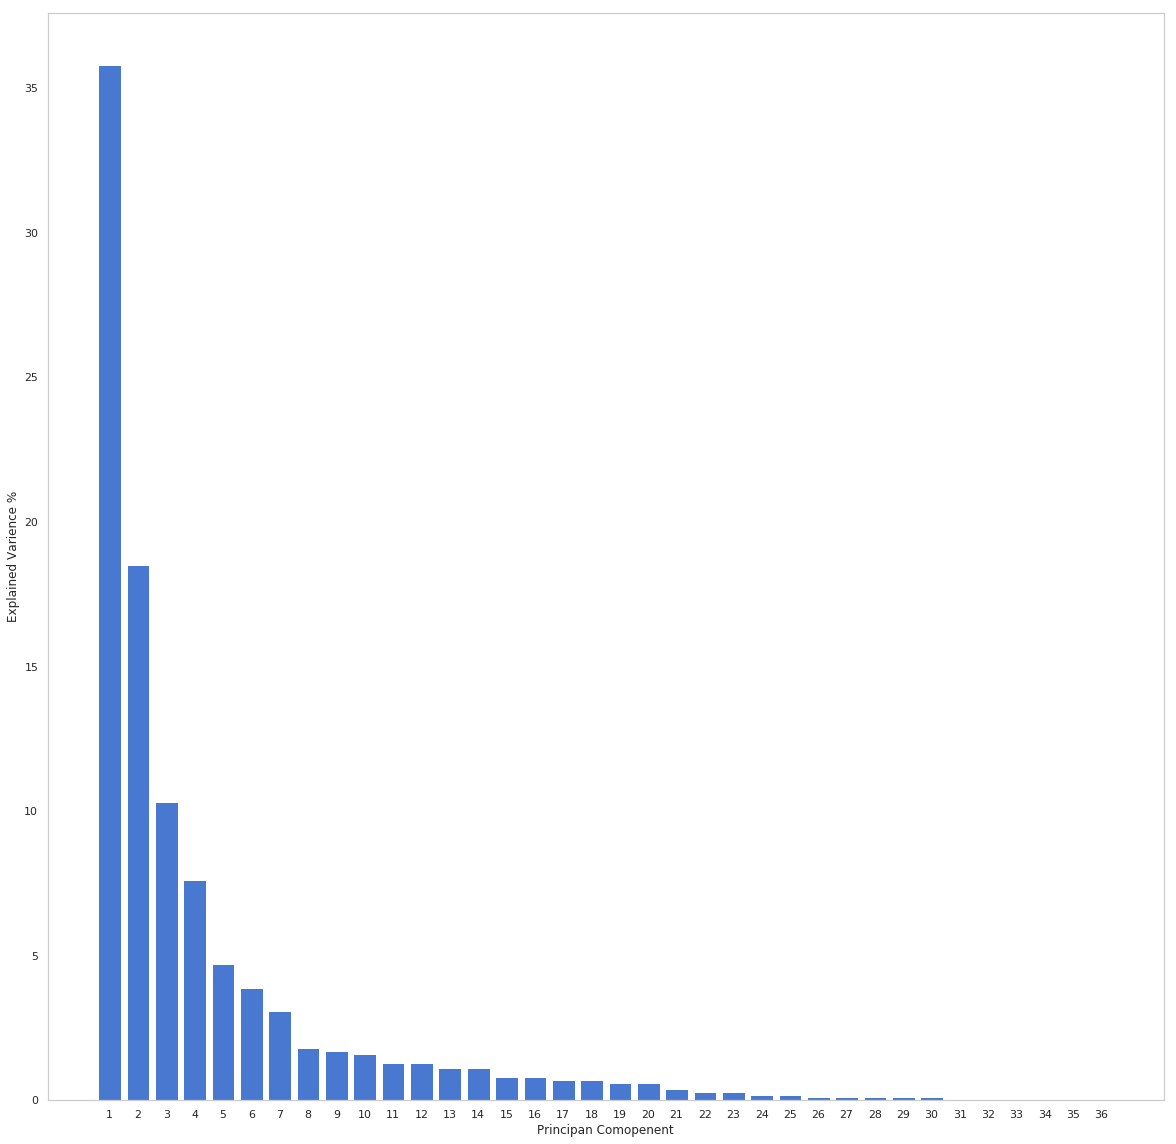

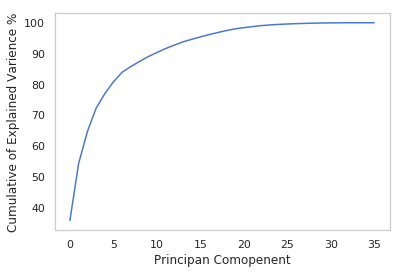

In [711]:
X = df.drop(['Absenteeism_time_in_hours'],axis=1)
y = df['Absenteeism_time_in_hours']

#################################################################################################################
#################################################################################################################

#scaled_data = preprocessing.scale(X)
X1= X.values
pca = PCA()
pca.fit(X1)
pca_data = pca.transform(X1)

per_var = np.round(pca.explained_variance_ratio_*100,decimals = 1)
lables = [ str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(20,20))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=lables)
plt.grid()
plt.ylabel('Explained Varience %')
plt.xlabel('Principan Comopenent')
plt.savefig('PCA1.pdf')
plt.show()

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var)
plt.grid()
plt.ylabel('Cumulative of Explained Varience %')
plt.xlabel('Principan Comopenent')
plt.savefig('PCA2.pdf')
plt.show()

In [712]:
var           # cumulative explained variance 

array([35.79, 54.25, 64.57, 72.16, 76.9 , 80.78, 83.91, 85.75, 87.41,
       88.98, 90.33, 91.6 , 92.71, 93.77, 94.61, 95.39, 96.13, 96.81,
       97.45, 98.01, 98.39, 98.74, 99.06, 99.28, 99.45, 99.59, 99.69,
       99.78, 99.85, 99.91, 99.94, 99.97, 99.99, 99.99, 99.99, 99.99])

In [713]:
# From the above plot selecting 30 components since it explains almost 95+ % data variance
pca = PCA(n_components=20)
# Fitting the selected components to the data
pca.fit(X)
pca_data = pca.fit_transform(X)
# Using train_test_split sampling function for test and train data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pca_data, y, test_size = 0.20, random_state = 0)

In [714]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
#lr.score(X_train, y_train)

mse_lr =mean_squared_error(y_test,lr_pred)
lr_r2 = r2_score(y_test,lr_pred)

print("Mean Squared Error For Test data = "+str(mse_lr))
print("R^2 Score(coefficient of determination")
print(lr_r2)

Mean Squared Error For Test data = 0.2986236045027647
R^2 Score(coefficient of determination
0.28477851075892124


In [715]:
#Decision Regressor

DT_reg = DecisionTreeRegressor(max_depth = 2, random_state=0).fit(X_train,y_train)

DT_reg.get_params()

#Apply model on test data
predictions_DT = DT_reg.predict(X_test)

#R^2
DT_r2 = r2_score(y_test, predictions_DT)
#Calculating MSE
DT_mse = mean_squared_error(y_test, predictions_DT)

print('Decision Regressor Model Performance:')
print('Default Parameters = ',DT_reg.get_params())
print('R-squared = {:0.4}.'.format(DT_r2))
print('MSE = ',DT_mse)
print('******************************************')

Decision Regressor Model Performance:
Default Parameters =  {'criterion': 'mse', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
R-squared = 0.1032.
MSE =  0.3744484881210333
******************************************


### Decision tree Random Search CV

In [716]:
##Random Search CV

np.random.seed(0)
RDT = DecisionTreeRegressor(random_state = 0)
depth = list(range(5,50,5))
# Create the random grid
randDT_grid = {'max_depth': depth}

randomcv_DT = RandomizedSearchCV(RDT, param_distributions = randDT_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_DT = randomcv_DT.fit(X_train,y_train)

predictions_RDT = randomcv_DT.predict(X_test)

view_best_params_RDT = randomcv_DT.best_params_

best_model = randomcv_DT.best_estimator_

predictions_RDT = best_model.predict(X_test)

#R^2
RDT_r2 = r2_score(y_test, predictions_RDT)
#Calculate MSE
RDT_mse = mean_squared_error(y_test, predictions_RDT)

print('Random Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RDT)
print('R-squared = {:0.2}.'.format(RDT_r2))
print('MSE = ',RDT_mse)
print('******************************************')

Random Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 10}
R-squared = 0.015.
MSE =  0.41137102943099124
******************************************


### Decision tree Grid Search CV

In [717]:
##Grid Search CV

Gridregr = DecisionTreeRegressor(random_state = 0)
depth = list(range(1,15,1))

# Create the grid
grid_search = {'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GDT = GridSearchCV(Gridregr, param_grid = grid_search, cv = 5)
gridcv_GDT = gridcv_GDT.fit(X_train,y_train)
view_best_params_GDT = gridcv_GDT.best_params_

#Apply model on test data
predictions_GDT = gridcv_GDT.predict(X_test)

#R^2
GDT_r2 = r2_score(y_test, predictions_GDT)
#Calculate MSE
GDT_mse = mean_squared_error(y_test, predictions_GDT)
#Calculate MAPE
GDT_mape = MAPE(y_test, predictions_GDT)

print('Grid Search CV Decision Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GDT)
print('R-squared = {:0.2}.'.format(GDT_r2))
print('MSE = ',(GDT_mse))
print('******************************************')

Grid Search CV Decision Regressor Model Performance:
Best Parameters =  {'max_depth': 5}
R-squared = 0.21.
MSE =  0.3294611813627842
******************************************


### Random forest

In [718]:

RF_reg = RandomForestRegressor(n_estimators = 1000, random_state=0).fit(X_train,y_train)
RF_reg.get_params()

#Apply model on test data
predictions_RF = RF_reg.predict(X_test)

#R^2
RF_r2 = r2_score(y_test, predictions_RF)
#Calculating MSE
RF_mse = np.mean(( y_test - predictions_RF)**2)

print('Random Forest Regressor Model Performance:')
print('Default Parameters = ',RF_reg.get_params())
print('R-squared = {:0.4}.'.format(RF_r2))
print('MSE = ',RF_mse)
print('**********************************************')


Random Forest Regressor Model Performance:
Default Parameters =  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': 1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
R-squared = 0.2736.
MSE =  0.30330721444799214
**********************************************


### Random forest random Search CV


In [719]:
##Random Search CV

RRF = RandomForestRegressor(random_state = 0)
n_estimator = list(range(1,20,2))
depth = list(range(1,100,2))

# Create the random grid
rand_grid = {'n_estimators': n_estimator,
               'max_depth': depth}

randomcv_rf = RandomizedSearchCV(RRF, param_distributions = rand_grid, n_iter = 5, cv = 5, random_state=0)
randomcv_rf = randomcv_rf.fit(X_train,y_train)
predictions_RRF = randomcv_rf.predict(X_test)

view_best_params_RRF = randomcv_rf.best_params_

best_model = randomcv_rf.best_estimator_

predictions_RRF = best_model.predict(X_test)


#R^2
RRF_r2 = r2_score(y_test, predictions_RRF)
#Calculating MSE
RRF_mse = np.mean(( y_test - predictions_RRF)**2)

print('Random Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_RRF)
print('R-squared = {:0.2}.'.format(RRF_r2))
print('MSE = ',RRF_mse)

Random Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'n_estimators': 15, 'max_depth': 9}
R-squared = 0.26.
MSE =  0.30971718768557643


### Random forest Grid Search CV

In [720]:
## Grid Search CV
regr = RandomForestRegressor(random_state = 0)
n_estimator = list(range(11,20,1))
depth = list(range(5,15,2))

# Create the grid
grid_search = {'n_estimators': n_estimator,
               'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_rf = GridSearchCV(regr, param_grid = grid_search, cv = 5)
gridcv_rf = gridcv_rf.fit(X_train,y_train)
view_best_params_GRF = gridcv_rf.best_params_

#Apply model on test data
predictions_GRF = gridcv_rf.predict(X_test)

#R^2
GRF_r2 = r2_score(y_test, predictions_GRF)
#Calculating MSE
GRF_mse = np.mean(( y_test - predictions_GRF)**2)

print('Grid Search CV Random Forest Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GRF)
print('R-squared = {:0.2}.'.format(GRF_r2))
print('MSE = ',(GRF_mse))


Grid Search CV Random Forest Regressor Model Performance:
Best Parameters =  {'max_depth': 7, 'n_estimators': 16}
R-squared = 0.27.
MSE =  0.3027266645879698


### Gradient Boost

In [721]:
#Gradient Boost
gbt = GradientBoostingRegressor(random_state= 0).fit(X_train,y_train)

predictions_gbt = gbt.predict(X_test)

gbt.get_params()

#R^2
GBR_r2 = r2_score(y_test, predictions_gbt)
#Calculate MSE
GBR_mse = mean_squared_error(y_test, predictions_gbt)

print('Gradient Boosting Regressor Model Performance:')
print('Default Parameters = ',gbt.get_params())
print('R-squared = {:0.2}.'.format(GBR_r2))
print('MSE = ',GBR_mse)
print('*************************************************')


Gradient Boosting Regressor Model Performance:
Default Parameters =  {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}
R-squared = 0.26.
MSE =  0.3106926099088413
*************************************************


### Random Search CV Gradient boosting

In [722]:
##Random Search CV
rGBR = GradientBoostingRegressor(random_state = 0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(50,150,10))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,10,2))

# Create the random grid
rand_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

randomcv_gbt = RandomizedSearchCV(rGBR, param_distributions = rand_GBT, n_iter = 5, cv = 5, random_state=0)
randomcv_gbt = randomcv_gbt.fit(X_train,y_train)
predictions_GBT = randomcv_gbt.predict(X_test)


view_best_params_GBT = randomcv_gbt.best_params_

#R^2
rGBR_r2 = r2_score(y_test, predictions_GBT)
#Calculate MSE
rGBR_mse = mean_squared_error(y_test, predictions_GBT)

print('Random Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_GBT)
print('R-squared = {:0.2}.'.format(rGBR_r2))
print('MSE = ',rGBR_mse)
print('*************************************************')

Random Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'n_estimators': 60, 'max_depth': 3}
R-squared = 0.28.
MSE =  0.3021934297233443
*************************************************


### Gradient Boosting Gride Search CV

In [723]:
## Gride Search CV

gGBR = GradientBoostingRegressor(random_state=0)
#loss = ['ls','lad','huber','quantile']
n_estimator = list(range(40,80,5))
#max_feat = ['auto','sqrt','log2']
depth = list(range(1,5,1))

# Create the random grid
grid_GBT = {#'loss': loss,
            'n_estimators': n_estimator,
            #'max_features': max_feat,
            'max_depth': depth}

## Grid Search Cross-Validation with 5 fold CV
gridcv_GBT = GridSearchCV(gGBR, param_grid = grid_GBT, cv = 5)
gridcv_GBT = gridcv_GBT.fit(X_train,y_train)
view_best_params_gridGRF = gridcv_GBT.best_params_

#Apply model on test data
predictions_gridGBT = gridcv_GBT.predict(X_test)

#R^2
gGBR_r2 = r2_score(y_test, predictions_gridGBT)
#Calculate MSE
gGBR_mse = mean_squared_error(y_test, predictions_gridGBT)

#Calculate MAPE
gGBR_mape = MAPE(y_test, predictions_gridGBT)

print('Grid Search CV Gradient Boosting Regressor Model Performance:')
print('Best Parameters = ',view_best_params_gridGRF)
print('R-squared = {:0.2}.'.format(gGBR_r2))
print('MSE = ', gGBR_mse)
print('*************************************************')

Grid Search CV Gradient Boosting Regressor Model Performance:
Best Parameters =  {'max_depth': 2, 'n_estimators': 65}
R-squared = 0.31.
MSE =  0.28671413364552173
*************************************************


## Classification

In [724]:
#Loading DF which was stored after the outlier analysis
df = df1

In [725]:
df.head()

,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
0,10,4,7,1,0,289.0,36.0,13.0,33.0,240.0,...,0,0,2,1,0,1,90.0,172.0,30.0,4.0
1,35,1,7,1,0,118.0,13.0,18.0,50.0,240.0,...,1,0,1,1,0,0,98.0,172.0,31.0,0.0
2,2,2,7,2,0,179.0,51.0,18.0,38.0,240.0,...,0,0,0,1,0,0,89.0,170.0,31.0,2.0
3,6,1,7,3,0,279.0,5.0,14.0,39.0,240.0,...,0,0,2,1,1,0,68.0,168.0,24.0,4.0
4,10,2,7,3,0,289.0,36.0,13.0,33.0,240.0,...,0,0,2,1,0,1,90.0,172.0,30.0,2.0


In [726]:
##Correlation analysis
#Correlation plot
df_corr = df.loc[:,num_dtype]

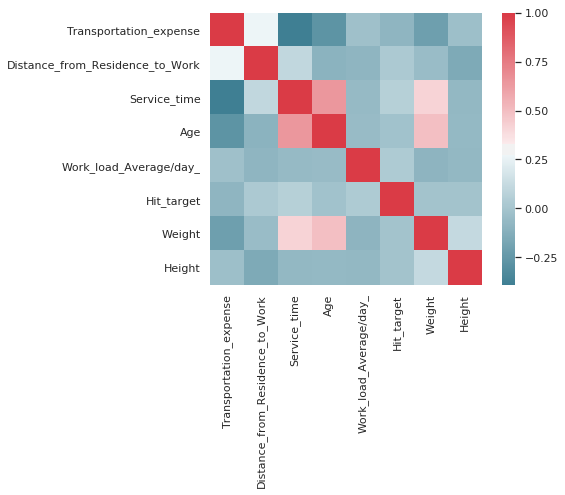

In [727]:
#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))

#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [728]:
obj_dtype

['ID',
 'Reason_for_absence',
 'Month_of_absence',
 'Disciplinary_failure',
 'Son',
 'Social_drinker',
 'Pet']

In [729]:
#Performing chi square test

#loop for chi square values
for i in obj_dtype:
    print(i)
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['Absenteeism_time_in_hours'], df[i]))
    print(p)

ID
7.705346449864873e-10
Reason_for_absence
3.038684341153542e-49
Month_of_absence
5.198801170459447e-09
Disciplinary_failure
1.7506819169177113e-117
Son
2.226887327859972e-08
Social_drinker
0.011539968647928535
Pet
0.12608552548493424


In [730]:
df = df.drop(['Weight', 'Day_of_the_week', 'Education', 'Pet'], axis = 1)

In [731]:
#Calling function 'dtype_separator' to segregate different data types
obj_dtype, num_dtype, bool_dtype, unknown_dtype = dtype_separator(df, df.columns)

In [732]:
num_dtype

['Transportation_expense',
 'Distance_from_Residence_to_Work',
 'Service_time',
 'Age',
 'Work_load_Average/day_',
 'Hit_target',
 'Height',
 'Body_mass_index',
 'Absenteeism_time_in_hours']

In [733]:
num_dtype.remove('Absenteeism_time_in_hours')

In [734]:
num_dtype

['Transportation_expense',
 'Distance_from_Residence_to_Work',
 'Service_time',
 'Age',
 'Work_load_Average/day_',
 'Hit_target',
 'Height',
 'Body_mass_index']

In [735]:
#Function to perform scaling analysis
scaling_fun(df,num_dtype,1)

Transportation_expense
Distance_from_Residence_to_Work
Service_time
Age
Work_load_Average/day_
Hit_target
Height
Body_mass_index


,ID,Reason_for_absence,Month_of_absence,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Son,Social_drinker,Social_smoker,Height,Body_mass_index,Absenteeism_time_in_hours
0,10,4,7,0,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,0,0.932081,0.774264,4.0
1,35,1,7,0,-1.551846,-1.120935,1.331988,2.267134,-0.841235,0.674640,1,1,1,0,0.932081,1.007552,0.0
2,2,2,7,0,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,-0.107467,1.007552,2.0
3,6,1,7,0,0.882703,-1.660136,0.372697,0.467751,-0.841235,0.674640,0,2,1,1,-1.147015,-0.625464,4.0
4,10,2,7,0,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,0,0.932081,0.774264,2.0
5,2,2,7,0,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,-0.107467,1.007552,2.0
6,9,2,7,0,2.122659,1.507666,-2.265352,-1.331632,-0.841235,0.674640,0,1,1,0,0.932081,0.074400,8.0
7,19,2,7,0,0.595396,1.372866,-0.346771,-0.022990,-0.841235,0.674640,0,4,1,0,-1.147015,-0.858752,4.0
8,13,1,7,0,-0.992354,-1.188335,0.372697,-0.350150,-0.841235,0.674640,0,2,1,0,-0.107467,-0.392176,3.0
9,0,2,7,0,0.217360,-1.255735,0.372697,0.140591,-0.841235,0.674640,0,1,0,0,0.932081,0.540976,8.0


In [736]:
df['Absenteeism_time_in_hours'].value_counts()

8.0     217
2.0     159
3.0     121
1.0      89
4.0      69
0.0      39
16.0     20
5.0      12
7.0       6
6.0       3
9.0       2
14.0      1
10.0      1
11.0      1
Name: Absenteeism_time_in_hours, dtype: int64

In [737]:
bins = [-1, 0,1, 5, 16]
labels = [0,1, 3 , 4]
df['Absenteeism_time_in_hours_cT'] = pd.cut(df['Absenteeism_time_in_hours'], bins=bins, labels=labels)

In [738]:
df

,ID,Reason_for_absence,Month_of_absence,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Disciplinary_failure,Son,Social_drinker,Social_smoker,Height,Body_mass_index,Absenteeism_time_in_hours,Absenteeism_time_in_hours_cT
0,10,4,7,0,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,0,0.932081,0.774264,4.0,3
1,35,1,7,0,-1.551846,-1.120935,1.331988,2.267134,-0.841235,0.674640,1,1,1,0,0.932081,1.007552,0.0,0
2,2,2,7,0,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,-0.107467,1.007552,2.0,3
3,6,1,7,0,0.882703,-1.660136,0.372697,0.467751,-0.841235,0.674640,0,2,1,1,-1.147015,-0.625464,4.0,3
4,10,2,7,0,1.033917,0.429265,0.132875,-0.513731,-0.841235,0.674640,0,2,1,0,0.932081,0.774264,2.0,3
5,2,2,7,0,-0.629439,1.440266,1.331988,0.304171,-0.841235,0.674640,0,0,1,0,-0.107467,1.007552,2.0,3
6,9,2,7,0,2.122659,1.507666,-2.265352,-1.331632,-0.841235,0.674640,0,1,1,0,0.932081,0.074400,8.0,4
7,19,2,7,0,0.595396,1.372866,-0.346771,-0.022990,-0.841235,0.674640,0,4,1,0,-1.147015,-0.858752,4.0,3
8,13,1,7,0,-0.992354,-1.188335,0.372697,-0.350150,-0.841235,0.674640,0,2,1,0,-0.107467,-0.392176,3.0,3
9,0,2,7,0,0.217360,-1.255735,0.372697,0.140591,-0.841235,0.674640,0,1,0,0,0.932081,0.540976,8.0,4


/home/gid/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


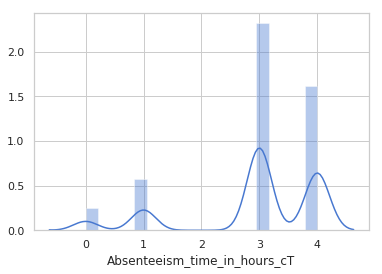

In [739]:
#now transforming the target variable
target = (df['Absenteeism_time_in_hours_cT'])
sns.distplot(target)
plt.savefig('ct.pdf')

In [740]:
df = df.drop(['Absenteeism_time_in_hours'], axis = 1)

In [741]:
#Import Libraries for decision tree
from sklearn.cross_validation import train_test_split

#Divide data into train and test
X = df.iloc[:,:16]
Y = df.iloc[:,16]
Y = Y.astype('int')
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.5,random_state = 0)

### Decision Tree Classifier

In [742]:
# Modeling Decision tree
clf = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

In [743]:
#Prediction
y_pred = clf.predict(X_test)

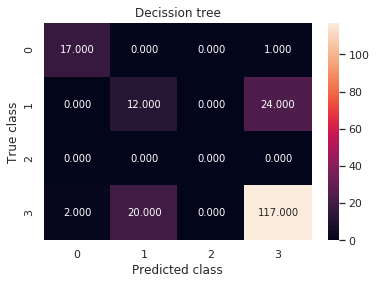

In [744]:
#printing confusion matrix
forest_cm = metrics.confusion_matrix(y_pred, y_test,[0,1,2,3])
sns.heatmap(forest_cm, annot=True, fmt='.3f' )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Decission tree')
plt.savefig('dt.pdf')

In [745]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, clf.predict(X_test))))

Accuracy: 0.597


### Logistic Regression Multinomial classifier

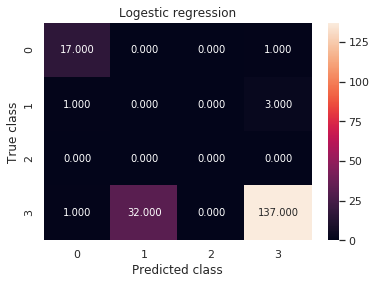

In [746]:
#Building logestical regression model
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=1000)
clf.fit(X_train, y_train)
#prediction
y_pred=clf.predict(X_test)

#printing confusion matrix
logr_cm = metrics.confusion_matrix(y_pred, y_test,[0,1,2,3])
sns.heatmap(logr_cm, annot=True, fmt='.3f' )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logestic regression')
plt.savefig('Logestic_regression')

In [747]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, clf.predict(X_test))))

Accuracy: 0.616


### Random Forest Multiclass classifier

In [748]:
#Random Forest model
RF_model = RandomForestClassifier(n_estimators = 500).fit(X_train, y_train)

In [749]:
#Prediction
RF_Predictions = RF_model.predict(X_test)

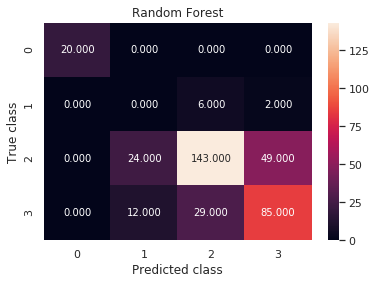

In [750]:
#printing confusion matrix
rf_cm = metrics.confusion_matrix(y_pred, RF_Predictions)
sns.heatmap(rf_cm, annot=True, fmt='.3f' )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [751]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, RF_model.predict(X_test))))

Accuracy: 0.670


### KNN

In [752]:
# Buildin KNN Model
KNN_model = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

In [753]:
#predict test cases
KNN_Predictions = KNN_model.predict(X_test)

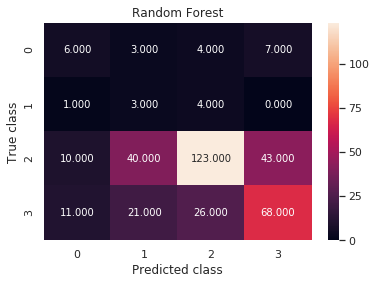

In [754]:
#printing confusion matrix
rf_cm = metrics.confusion_matrix(y_pred, KNN_Predictions)
sns.heatmap(rf_cm, annot=True, fmt='.3f' )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [755]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, KNN_model.predict(X_test))))

Accuracy: 0.505


### Naive Bayes

In [756]:
#Naive Bayes implementation
NB_model = GaussianNB().fit(X_train, y_train)

In [757]:
#predict test cases
NB_Predictions = NB_model.predict(X_test)

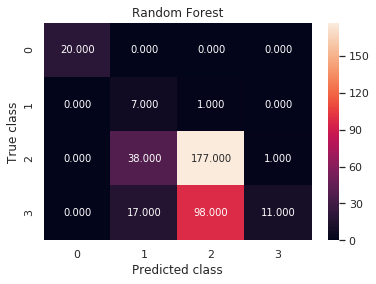

In [758]:
#printing confusion matrix
rf_cm = metrics.confusion_matrix(y_pred, NB_Predictions)
sns.heatmap(rf_cm, annot=True, fmt='.3f' )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [759]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, NB_model.predict(X_test))))

Accuracy: 0.473


# Predict loss for 2011 from previous years data

In [760]:
loss_df = df1

In [761]:
loss_df

,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,...,Disciplinary_failure,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours
0,10,4,7,1,0,289.0,36.0,13.0,33.0,240.0,...,0,0,2,1,0,1,90.0,172.0,30.0,4.0
1,35,1,7,1,0,118.0,13.0,18.0,50.0,240.0,...,1,0,1,1,0,0,98.0,172.0,31.0,0.0
2,2,2,7,2,0,179.0,51.0,18.0,38.0,240.0,...,0,0,0,1,0,0,89.0,170.0,31.0,2.0
3,6,1,7,3,0,279.0,5.0,14.0,39.0,240.0,...,0,0,2,1,1,0,68.0,168.0,24.0,4.0
4,10,2,7,3,0,289.0,36.0,13.0,33.0,240.0,...,0,0,2,1,0,1,90.0,172.0,30.0,2.0
5,2,2,7,4,0,179.0,51.0,18.0,38.0,240.0,...,0,0,0,1,0,0,89.0,170.0,31.0,2.0
6,9,2,7,4,0,361.0,52.0,3.0,28.0,240.0,...,0,0,1,1,0,3,80.0,172.0,27.0,8.0
7,19,2,7,4,0,260.0,50.0,11.0,36.0,240.0,...,0,0,4,1,0,0,65.0,168.0,23.0,4.0
8,13,1,7,0,0,155.0,12.0,14.0,34.0,240.0,...,0,0,2,1,0,0,95.0,170.0,25.0,3.0
9,0,2,7,0,0,235.0,11.0,14.0,37.0,240.0,...,0,2,1,0,0,1,88.0,172.0,29.0,8.0


In [762]:
# Calculating average work loss per day
loss_df['work_loss_average/day'] = 0
for i  in range(len(loss_df)):
    loss_df['work_loss_average/day'].loc[i] = ((loss_df['Work_load_Average/day_'].loc[i])/24)*loss_df['Absenteeism_time_in_hours'].loc[i]

/home/gid/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [763]:
loss_df

,ID,Reason_for_absence,Month_of_absence,Day_of_the_week,Seasons,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,...,Education,Son,Social_drinker,Social_smoker,Pet,Weight,Height,Body_mass_index,Absenteeism_time_in_hours,work_loss_average/day
0,10,4,7,1,0,289.0,36.0,13.0,33.0,240.0,...,0,2,1,0,1,90.0,172.0,30.0,4.0,40.000000
1,35,1,7,1,0,118.0,13.0,18.0,50.0,240.0,...,0,1,1,0,0,98.0,172.0,31.0,0.0,0.000000
2,2,2,7,2,0,179.0,51.0,18.0,38.0,240.0,...,0,0,1,0,0,89.0,170.0,31.0,2.0,20.000000
3,6,1,7,3,0,279.0,5.0,14.0,39.0,240.0,...,0,2,1,1,0,68.0,168.0,24.0,4.0,40.000000
4,10,2,7,3,0,289.0,36.0,13.0,33.0,240.0,...,0,2,1,0,1,90.0,172.0,30.0,2.0,20.000000
5,2,2,7,4,0,179.0,51.0,18.0,38.0,240.0,...,0,0,1,0,0,89.0,170.0,31.0,2.0,20.000000
6,9,2,7,4,0,361.0,52.0,3.0,28.0,240.0,...,0,1,1,0,3,80.0,172.0,27.0,8.0,80.000000
7,19,2,7,4,0,260.0,50.0,11.0,36.0,240.0,...,0,4,1,0,0,65.0,168.0,23.0,4.0,40.000000
8,13,1,7,0,0,155.0,12.0,14.0,34.0,240.0,...,0,2,1,0,0,95.0,170.0,25.0,3.0,30.000000
9,0,2,7,0,0,235.0,11.0,14.0,37.0,240.0,...,2,1,0,0,1,88.0,172.0,29.0,8.0,80.000000


In [764]:
loss_df_month = loss_df.groupby('Month_of_absence').sum()

In [765]:
loss_df_month

,Transportation_expense,Distance_from_Residence_to_Work,Service_time,Age,Work_load_Average/day_,Hit_target,Weight,Height,Body_mass_index,Absenteeism_time_in_hours,work_loss_average/day
Month_of_absence,,,,,,,,,,,
1.0,9106.0,1210.0,597.0,1748.0,15742.0,4821.0,3924.0,8531.0,1310.0,171.0,2252.833333
2.0,14905.0,2585.0,946.0,2540.0,19458.0,6999.0,5643.0,12204.0,1921.0,279.0,3164.875000
3.0,19000.0,2777.0,1194.0,3158.0,23307.0,8475.0,6740.0,14781.0,2300.0,452.0,5281.916667
4.0,11954.0,1434.0,649.0,1942.0,14547.0,5014.0,4176.0,9033.0,1391.0,240.0,2728.875000
5.0,14151.0,1570.0,766.0,2298.0,15871.0,6224.0,5031.0,10907.0,1643.0,273.0,2794.166667
6.0,11179.0,1547.0,694.0,2086.0,14857.0,5228.0,4377.0,9395.0,1464.0,249.0,2815.083333
7.0,15701.0,2023.0,811.0,2407.0,16993.0,6460.0,5461.0,11596.0,1825.0,392.0,4129.750000
8.0,13122.0,1711.0,659.0,1991.0,12864.0,5019.0,4377.0,9216.0,1490.0,248.0,2438.000000
9.0,12165.0,1723.0,710.0,2015.0,14316.0,4952.0,4354.0,9168.0,1494.0,205.0,2298.666667


In [766]:
loss = loss_df_month[['Absenteeism_time_in_hours', 'work_loss_average/day']]

In [767]:
loss = loss.rename(columns={'Absenteeism_time_in_hours': 'Total Absenteeism time in a month (hrs)', 
                            'work_loss_average/day': 'Work loss per month'})

In [768]:
loss

,Total Absenteeism time in a month (hrs),Work loss per month
Month_of_absence,,
1.0,171.0,2252.833333
2.0,279.0,3164.875000
3.0,452.0,5281.916667
4.0,240.0,2728.875000
5.0,273.0,2794.166667
6.0,249.0,2815.083333
7.0,392.0,4129.750000
8.0,248.0,2438.000000
9.0,205.0,2298.666667
